In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from simulations import sim_randomised, sim_constrained, sim_automated
import random
import matplotlib.pyplot as plt
from torch.distributions import Categorical

#GNN related imports
import torch_geometric.nn as geom_nn

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Data
from torch_geometric.data import Batch

import torch.optim as optim


import math


In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
class ActorCritic(nn.Module):
    def __init__(self, gnn_output_dim, n_actions, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        self.n_actions = n_actions
        
        self.actor = nn.Sequential(
            nn.Linear(gnn_output_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(gnn_output_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, graph_feature_vector,action_mask,temperature=1.0):
        logits = self.actor(graph_feature_vector) / temperature
        #print(logits, "direct logits")
        logits += action_mask
        #print(logits)
        
        action_probs = F.softmax(logits, dim=-1)
        state_value = self.critic(graph_feature_vector)
        return action_probs, state_value

I choosed GraphConv as I want a general-purpose graph convolution that can be configured in various ways.
Might use MessagePassing in need to implement a custom GNN layer that involves a novel form of message passing between nodes.

In [25]:
class StateGNN(nn.Module):
    def __init__(self, node_feature_dim, output_dim, num_layers=3, hidden_dim=128):
        super(StateGNN, self).__init__()
        # Define GNN layers
        
        #self.conv1 = geom_nn.GraphConv(node_feature_dim, 256)
        #self.conv2 = geom_nn.GraphConv(256, 128)
        #self.conv3 = geom_nn.GraphConv(128, 64)
        # An output layer that produces the feature vector for the actor model
        
        self.num_layers = num_layers
        if num_layers == 1:
            self.conv = geom_nn.GraphConv(node_feature_dim, output_dim)
        else:
            # Multi-layer model
            self.convs = torch.nn.ModuleList()
        
            self.convs.append(geom_nn.GraphConv(node_feature_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.convs.append(geom_nn.GraphConv(hidden_dim, hidden_dim))
            self.convs.append(geom_nn.GraphConv(hidden_dim, output_dim))


        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GNN layers
        #x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
        #x = F.relu(self.conv3(x, edge_index))
        
        for layer in range(self.num_layers):
            x = F.relu(self.convs[layer](x,edge_index))
        
        # Global pooling to create a graph-level feature vector
        x = geom_nn.global_mean_pool(x, data.batch)

        # Output layer
        return x

In [26]:
class PPO:
    def __init__(self, 
                 node_feature_dim,
                 gnn_output_dim, 
                 n_actions,
                 lr_actor,
                 lr_critic,
                 lr_graph,
                 gamma,
                 K_epochs,
                 eps_clip,
                 gae_lambda):
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda

        self.gnn_processor = StateGNN(node_feature_dim, gnn_output_dim)
        self.policy = ActorCritic(gnn_output_dim, n_actions)
        self.optimizer = optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic},
            {'params': self.gnn_processor.parameters(), 'lr': lr_graph}
        ])
        
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9999)

        self.policy_old = ActorCritic(gnn_output_dim, n_actions)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state_data, memory,action_mask, temperature=1.0):
        
        # Not sure if I need it
        #state = torch.FloatTensor(state.reshape(1, -1))
        
        gnn_output = self.gnn_processor(state_data)
        
        with torch.no_grad():
            masked_action_probs, _ = self.policy_old(gnn_output, action_mask, temperature)
        
        dist = Categorical(masked_action_probs)
        action = dist.sample()
        
        
        memory.states.append(state_data)
        memory.actions.append(action)
        memory.masks.append(torch.tensor(action_mask))
        memory.logprobs.append(dist.log_prob(action))

        return action

    def update(self, memory):
        gae, targets = self.calculate_gae_and_targets(memory)


        old_states = Batch.from_data_list(memory.states)
        old_actions = torch.squeeze(torch.stack(memory.actions)).detach()
        old_masks = torch.squeeze(torch.stack(memory.masks)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).detach()
        losses = []
        
        # Normalizing the rewards
        gae = torch.tensor(gae)
        gae = (gae - gae.mean()) / (gae.std() + 1e-7)

        for _ in range(self.K_epochs):
            # Evaluate old actions and values
            gnn_outputs = self.gnn_processor(old_states)
            logprobs, state_values = self.policy(gnn_outputs,old_masks)
            state_values = torch.squeeze(state_values)
            dist_entropy = -torch.sum(logprobs * torch.exp(logprobs), dim=1)
            new_logprobs = logprobs.gather(1, old_actions.view(-1, 1)).squeeze()
            
            # Find the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(new_logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * gae
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * gae
            
            # Final loss
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, targets) - 0.05*dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
            losses.append(loss.mean().detach().cpu().numpy())
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        return losses
        
    def calculate_gae_and_targets(self, memory):
        gae = 0
        targets = []
        gae_values = []
        values = memory.values + [0]
    
        for i in reversed(range(len(memory.rewards))):
            delta = memory.rewards[i] + self.gamma * values[i+1] * (1 - memory.is_terminals[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * gae * (1 - memory.is_terminals[i])
            gae_values.insert(0, gae)
            targets.insert(0, gae + values[i])

        gae_values = torch.tensor(gae_values, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)

        return gae_values, targets


In [27]:
class Memory:
    def __init__(self):
        self.actions = []
        self.masks = []
        self.states = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []
        self.values = []


    def clear_memory(self):
        del self.actions[:]
        del self.masks[:]
        del self.states[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.logprobs[:]
        del self.values[:]


In [28]:
def show(losses, success_rates):
    figure, axis = plt.subplots(2, 1,figsize=(20, 15) )

    x = range(len(losses))
    a, b = np.polyfit(x,losses , 1)

    axis[0].plot(x, losses)

    x = range(len(success_rates))
    # Creating the plot

    a, b = np.polyfit(x,success_rates , 1)

    axis[1].scatter(x, success_rates)

    axis[1].plot(x, a*x+b,color='red',linewidth=4.5)

    plt.show()   

26


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  25  is done!


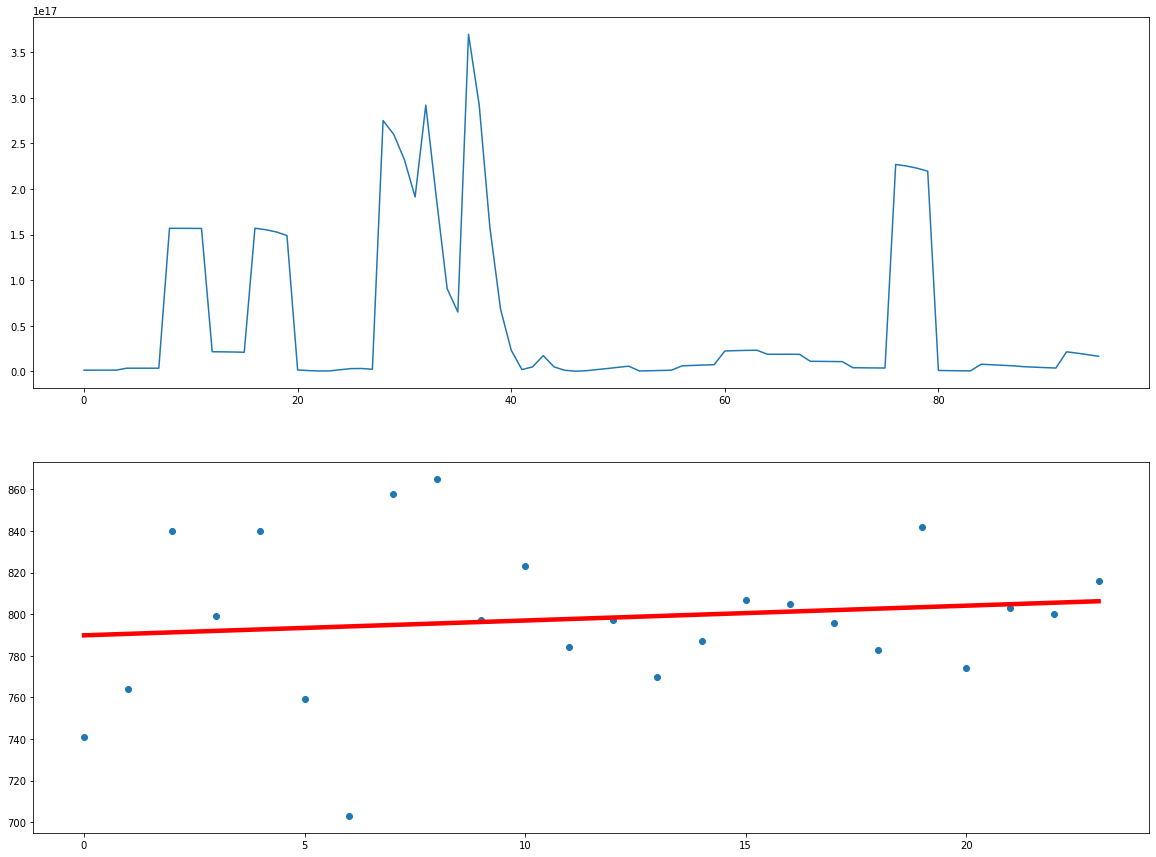

1.908
Epoch 25: Current Learning Rate: [0.0004988013789885311, 0.007781301512221086, 0.00039904110319082507], Current Success Rate: 816


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  50  is done!


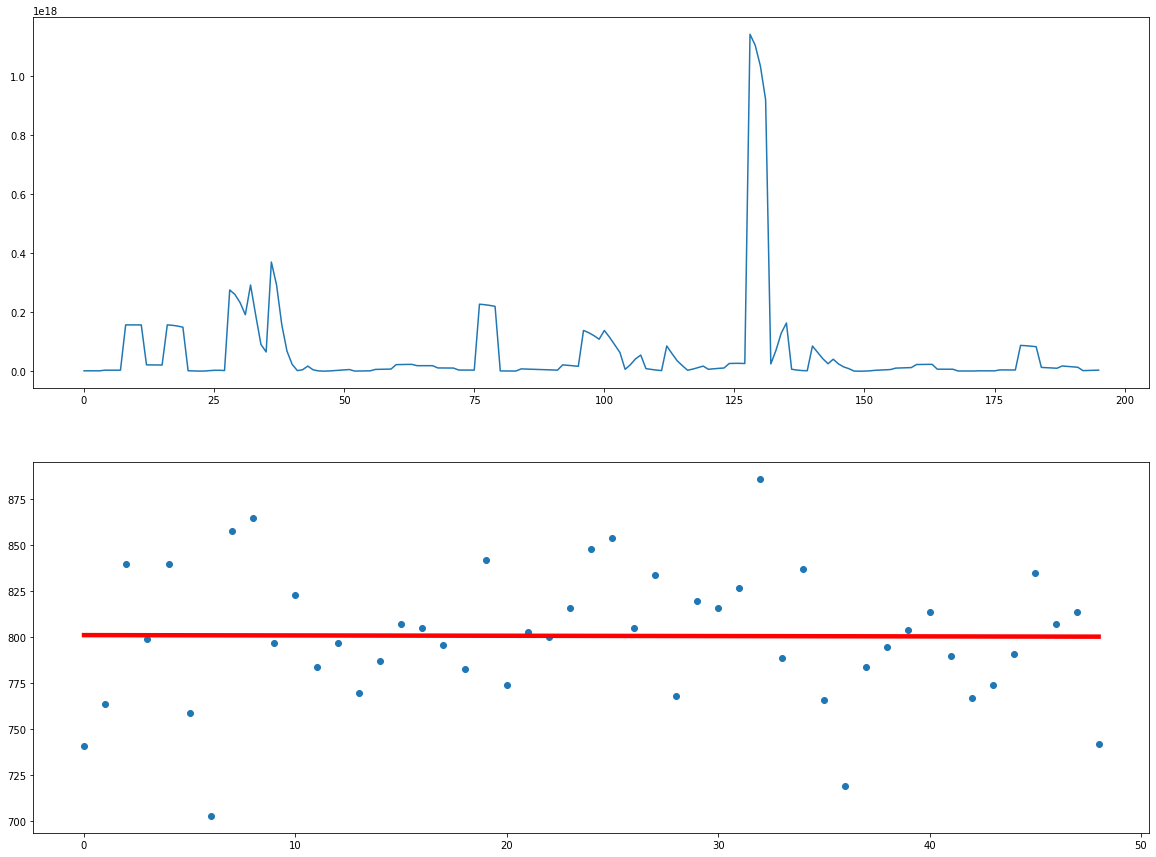

1.808
Epoch 50: Current Learning Rate: [0.0004975558707985845, 0.007761871584457916, 0.00039804469663886775], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  75  is done!


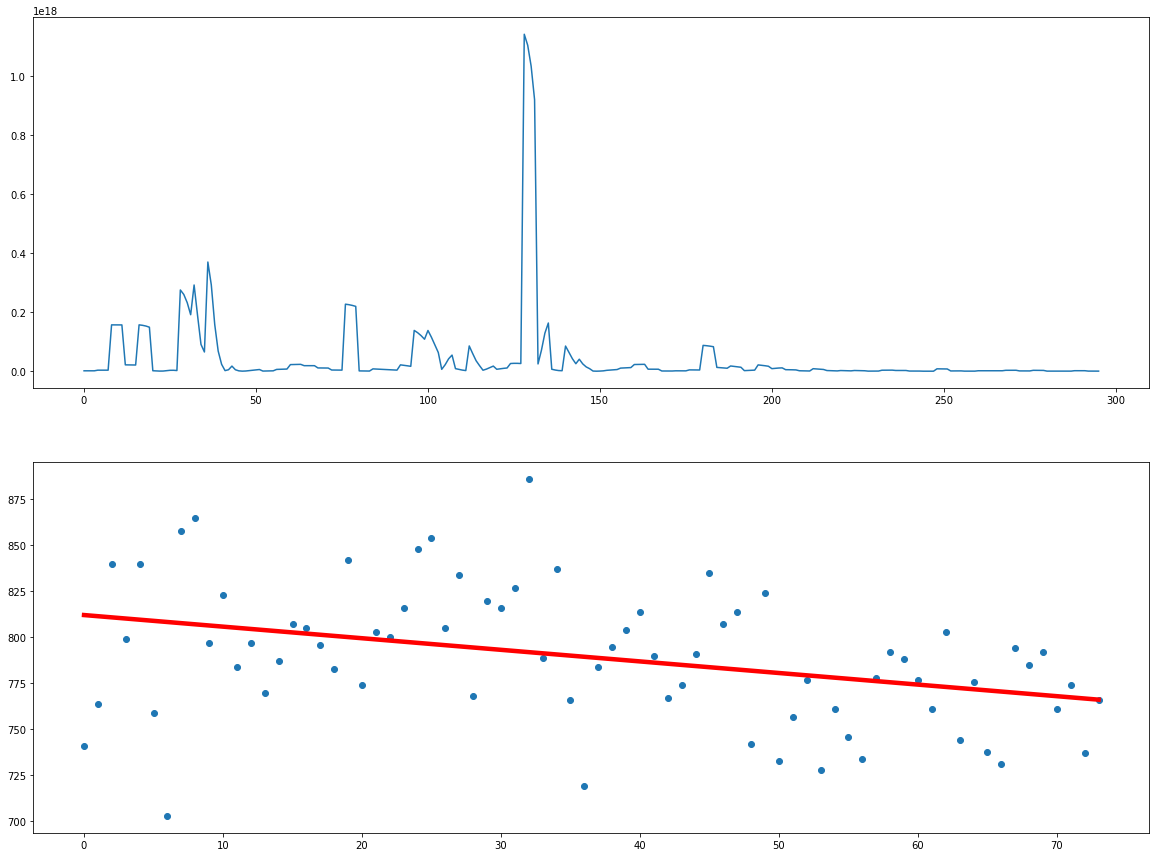

1.708
Epoch 75: Current Learning Rate: [0.0004963134726454515, 0.007742490173269038, 0.0003970507781163612], Current Success Rate: 766


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  100  is done!


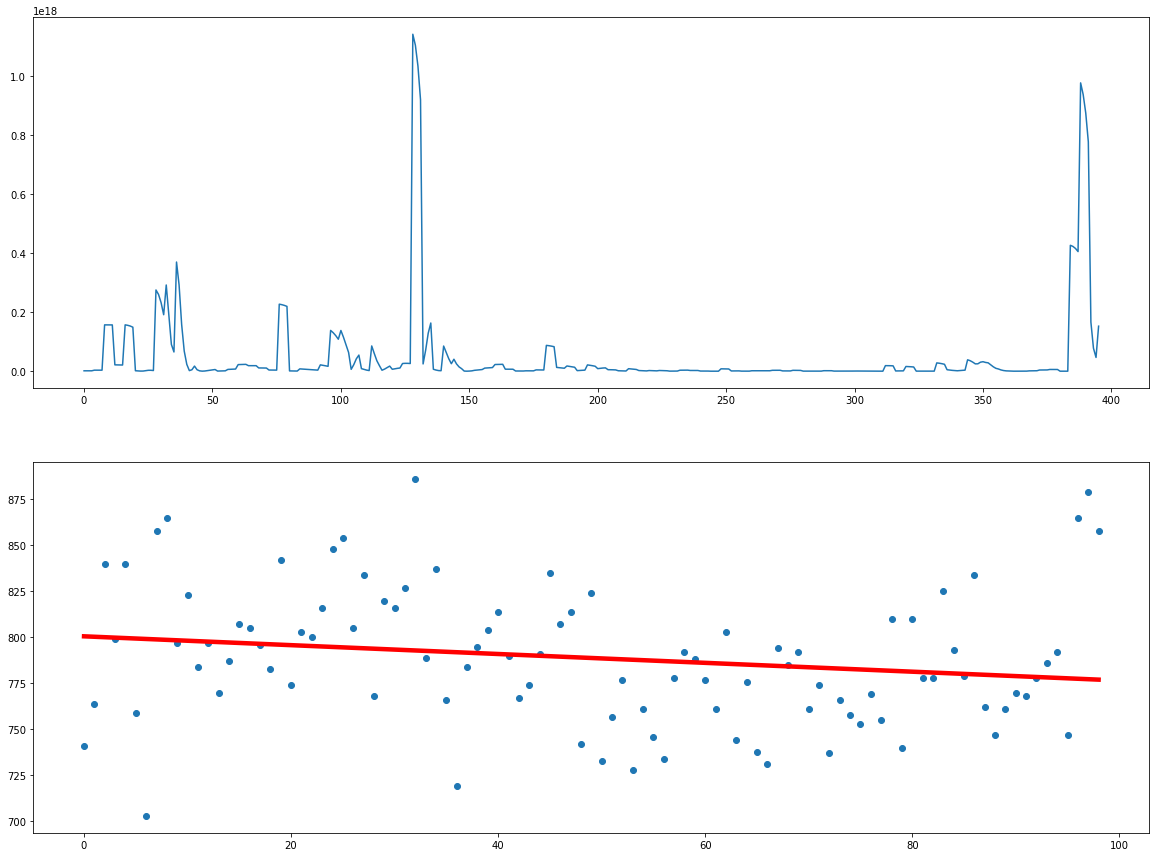

1.608
Epoch 100: Current Learning Rate: [0.0004950741767633626, 0.007723157157508451, 0.00039605934141069007], Current Success Rate: 858


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  125  is done!


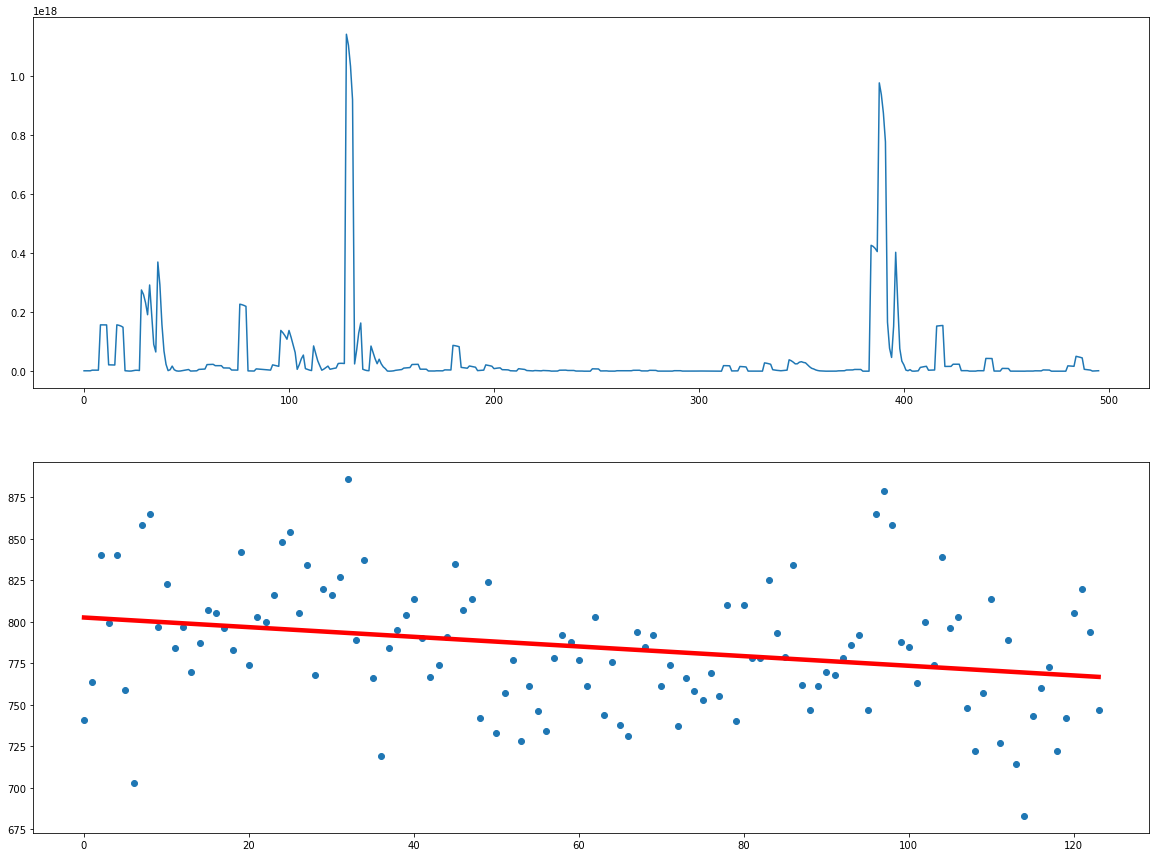

1.508
Epoch 125: Current Learning Rate: [0.0004938379754059397, 0.007703872416332658, 0.00039507038032475213], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  150  is done!


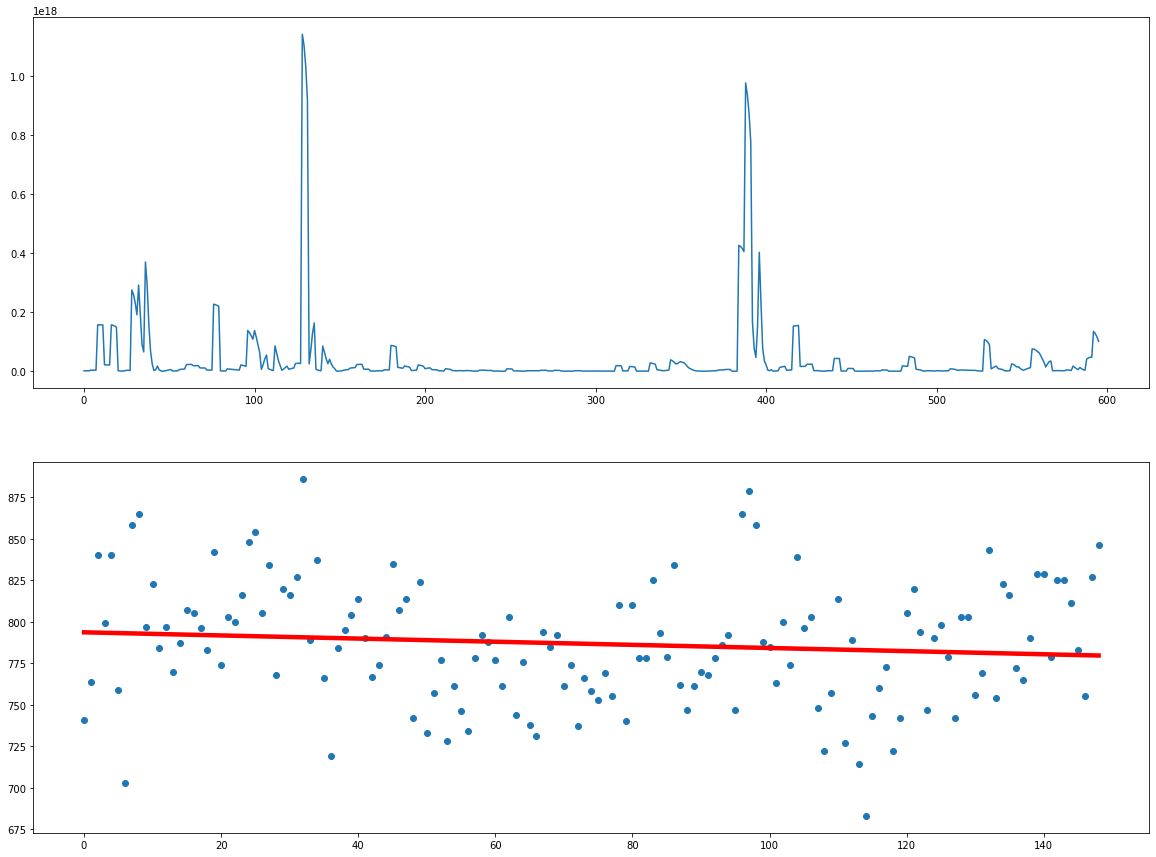

1.408
Epoch 150: Current Learning Rate: [0.0004926048608461484, 0.007684635829199913, 0.00039408388867691915], Current Success Rate: 846


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  175  is done!


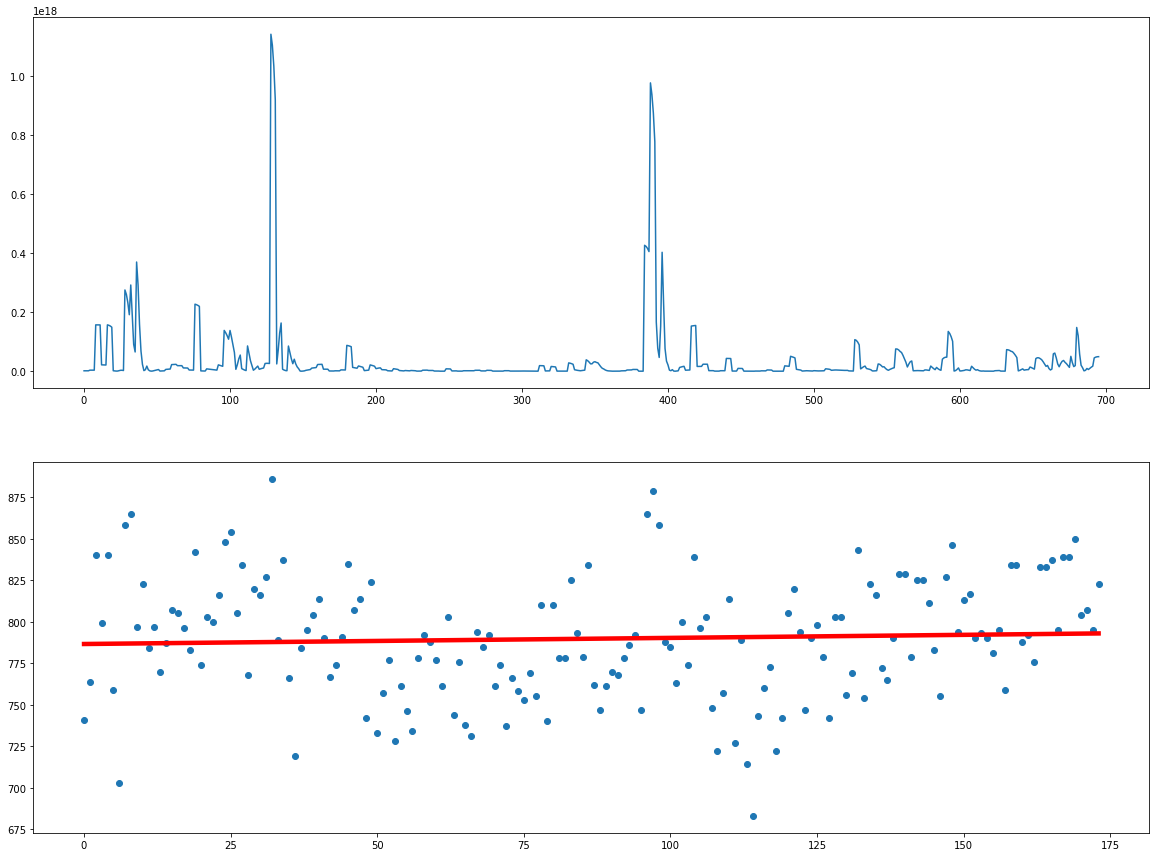

1.3079999999999998
Epoch 175: Current Learning Rate: [0.0004913748253762472, 0.007665447275869457, 0.00039309986030099835], Current Success Rate: 823


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  200  is done!


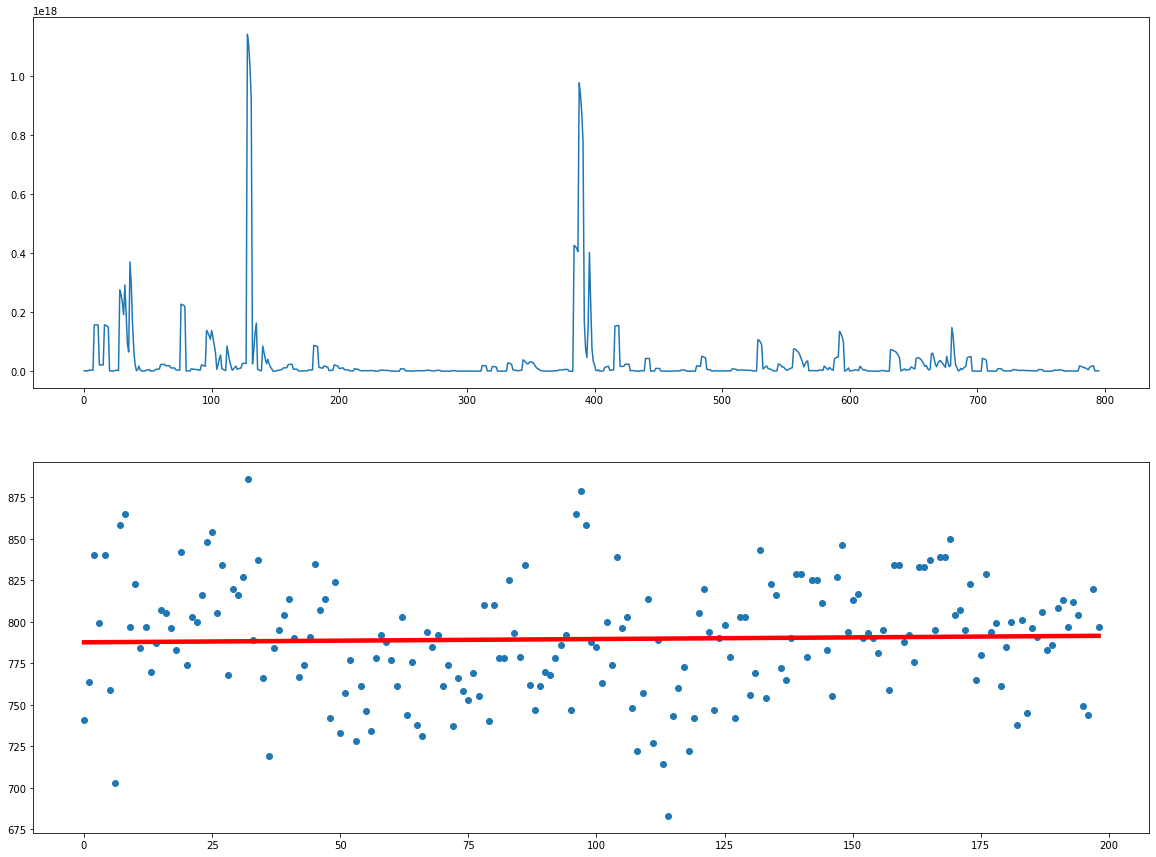

1.208
Epoch 200: Current Learning Rate: [0.0004901478613077421, 0.007646306636400777, 0.00039211828904619426], Current Success Rate: 797


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  225  is done!


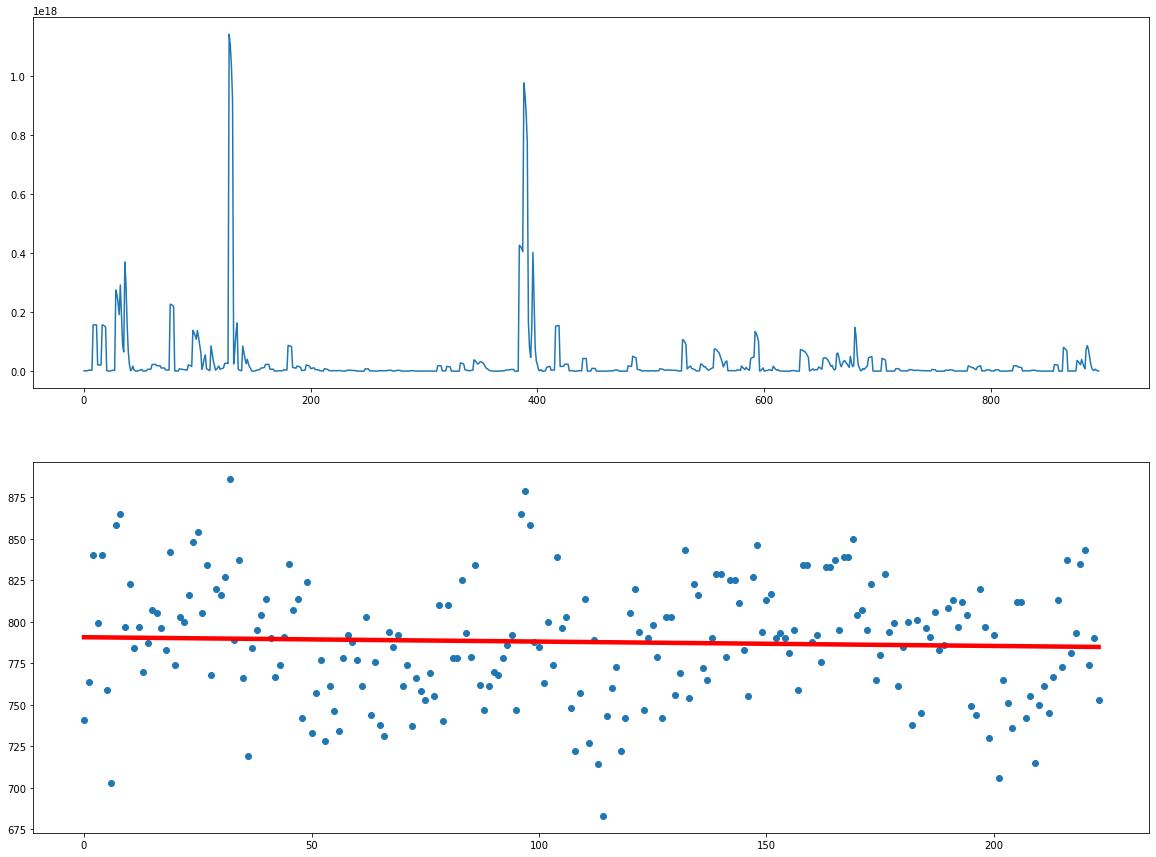

1.108
Epoch 225: Current Learning Rate: [0.0004889239609713366, 0.007627213791152849, 0.00039113916877706983], Current Success Rate: 753


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  250  is done!


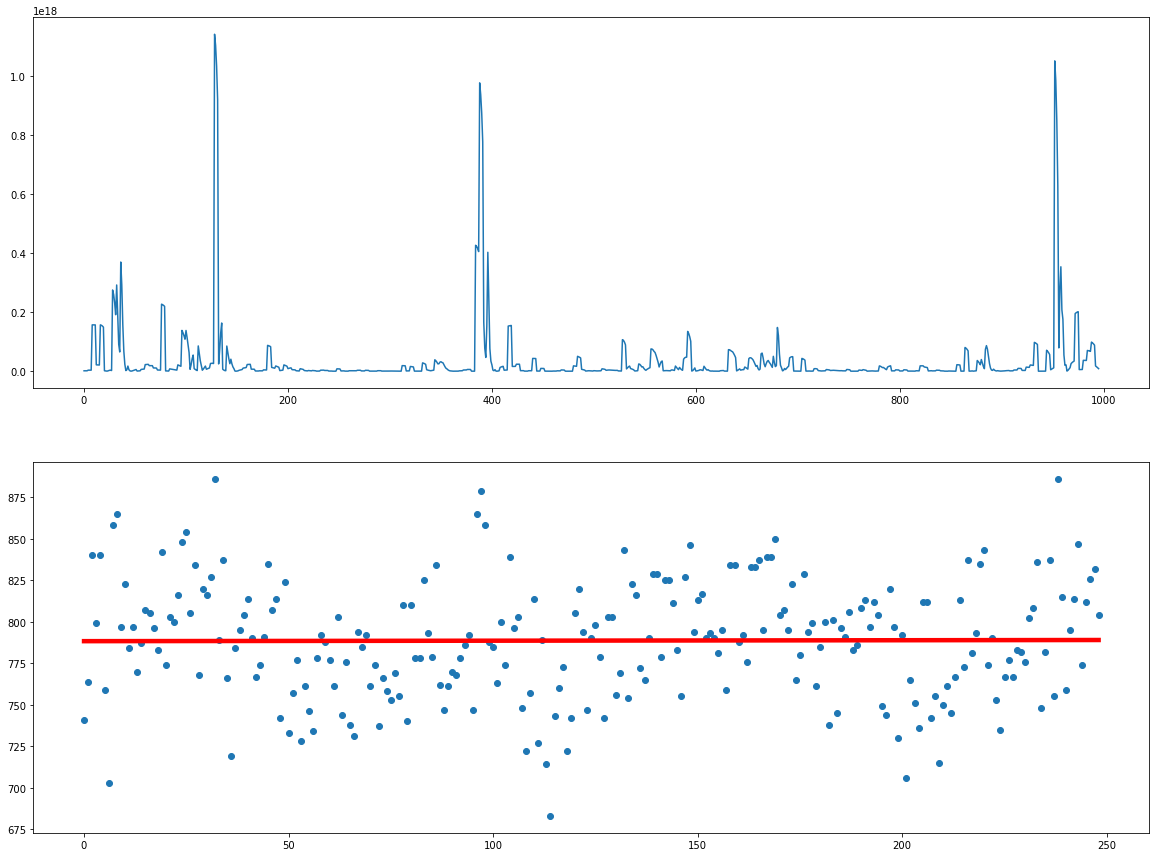

1.008
Epoch 250: Current Learning Rate: [0.0004877031167168844, 0.007608168620783397, 0.00039016249337350806], Current Success Rate: 804


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  275  is done!


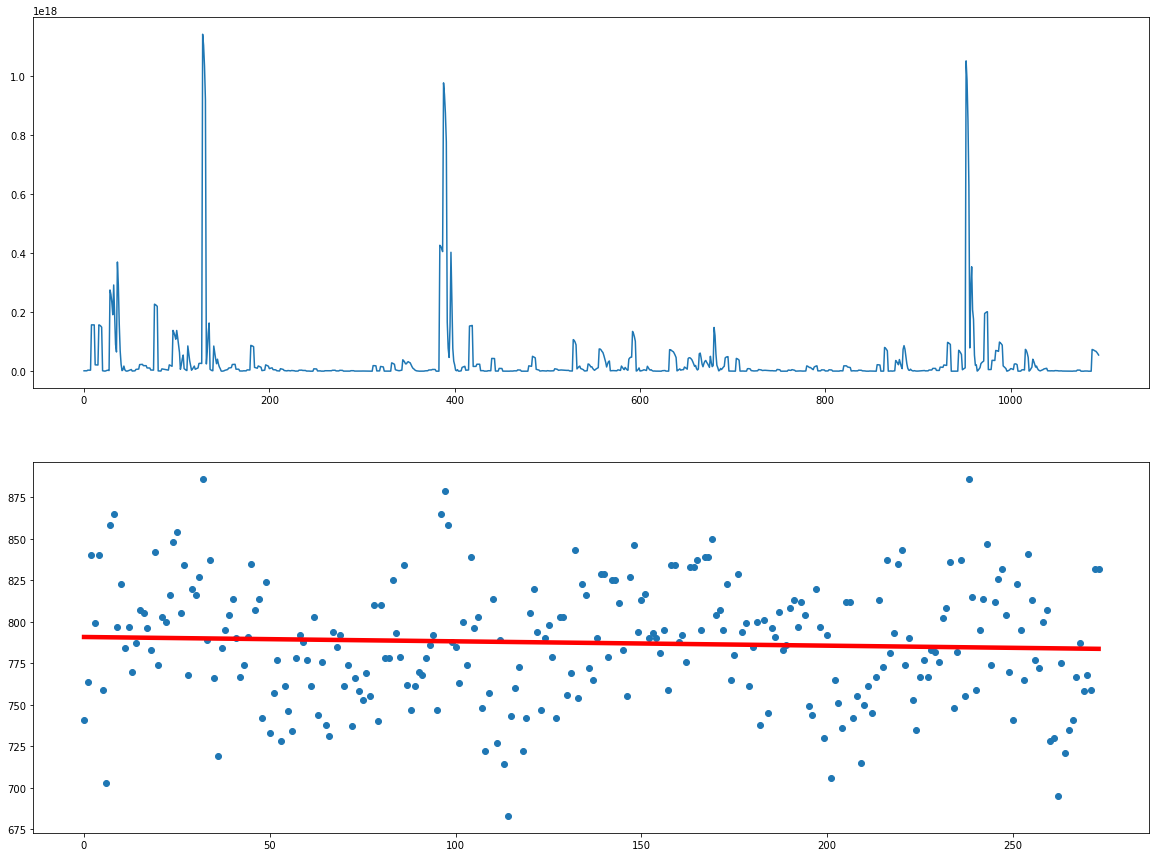

1
Epoch 275: Current Learning Rate: [0.000486485320913342, 0.007589171006248136, 0.00038918825673067426], Current Success Rate: 832


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  300  is done!


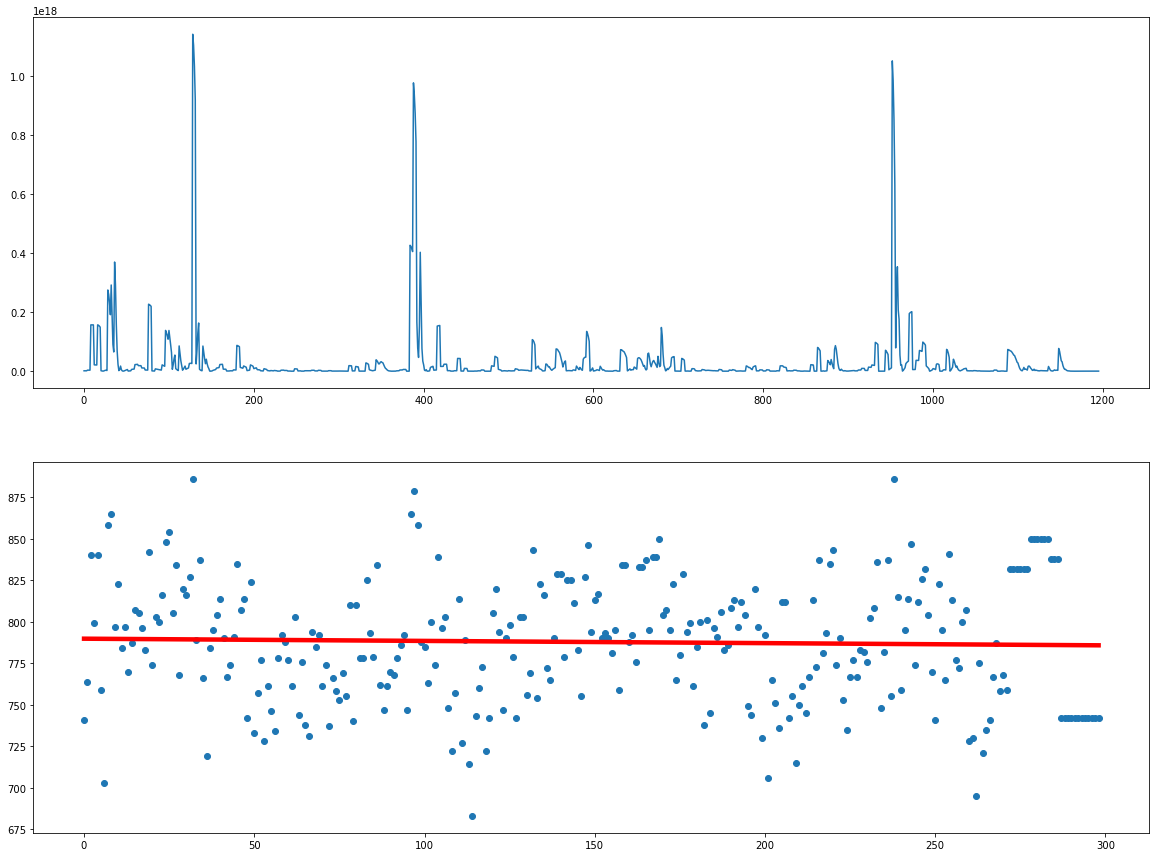

1
Epoch 300: Current Learning Rate: [0.00048527056594872044, 0.007570220828800039, 0.00038821645275897705], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  325  is done!


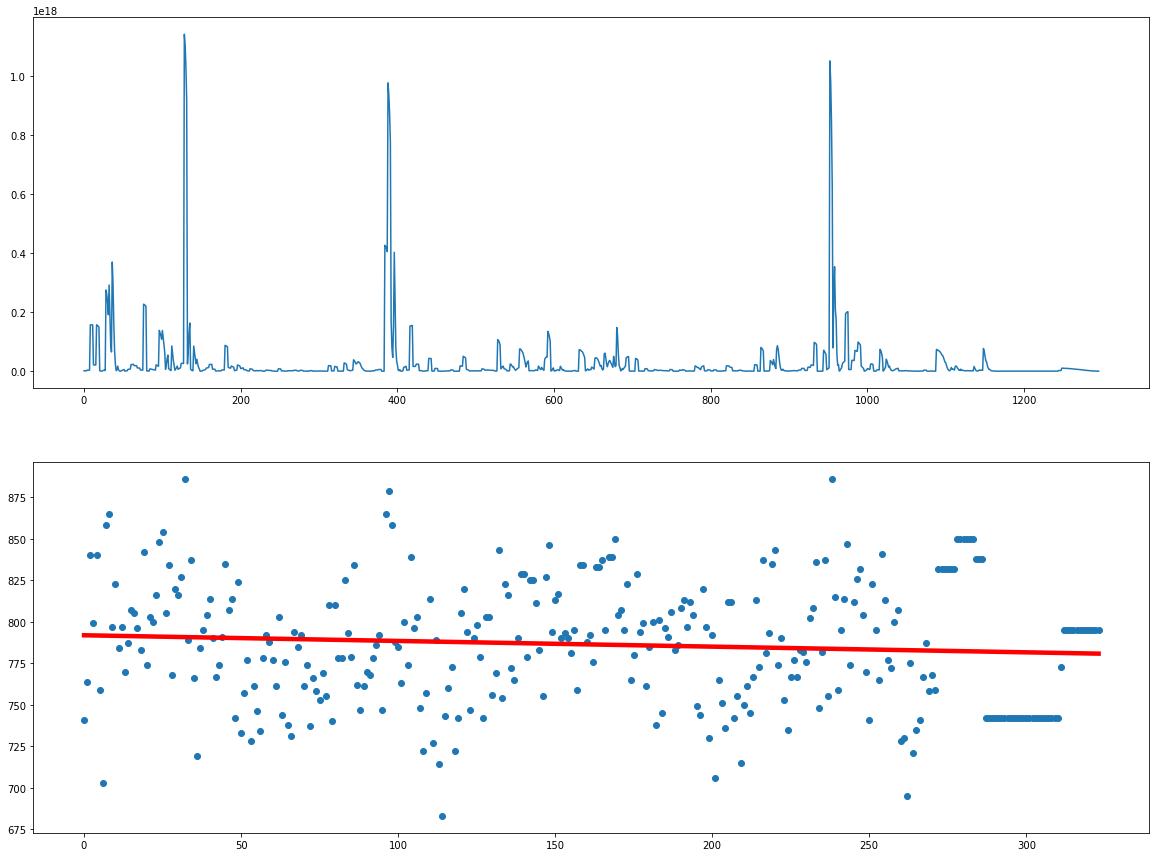

1
Epoch 325: Current Learning Rate: [0.000484058844230038, 0.007551317969988589, 0.0003872470753840311], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  350  is done!


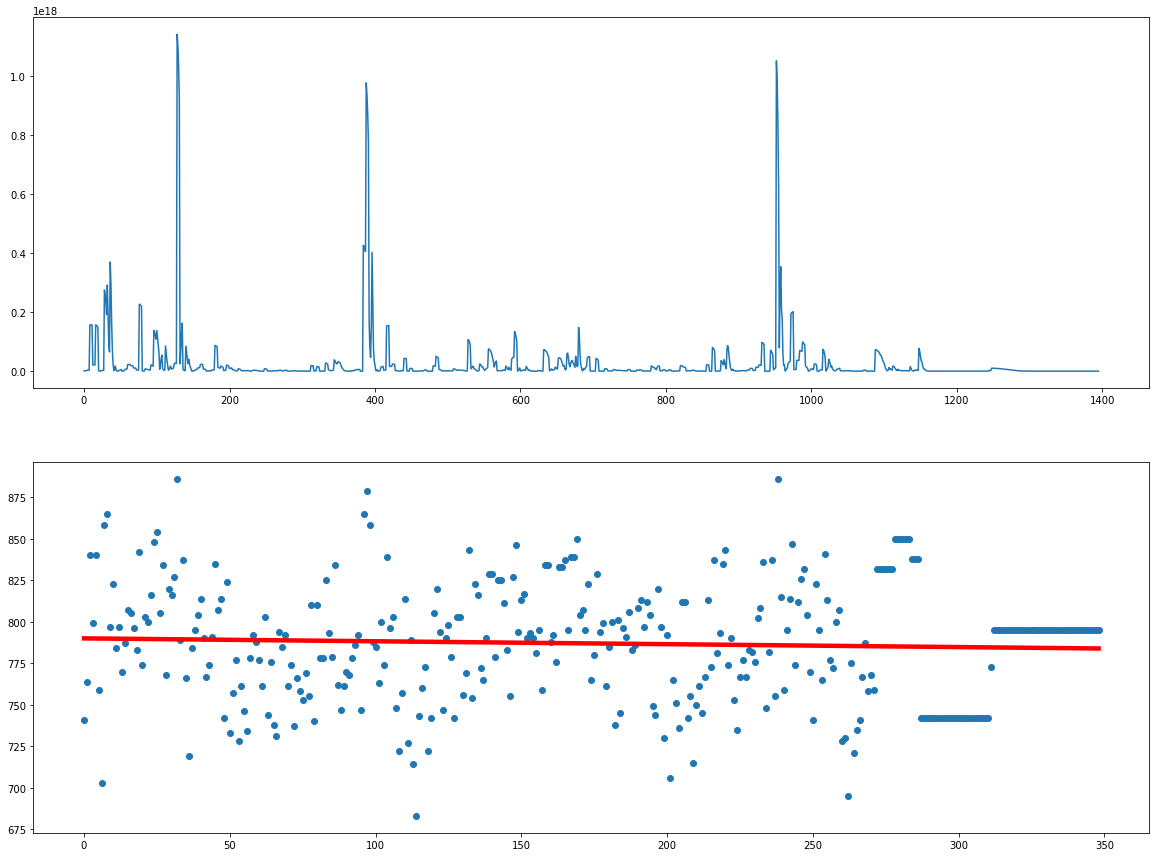

1
Epoch 350: Current Learning Rate: [0.00048285014818327235, 0.007532462311659046, 0.0003862801185466186], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  375  is done!


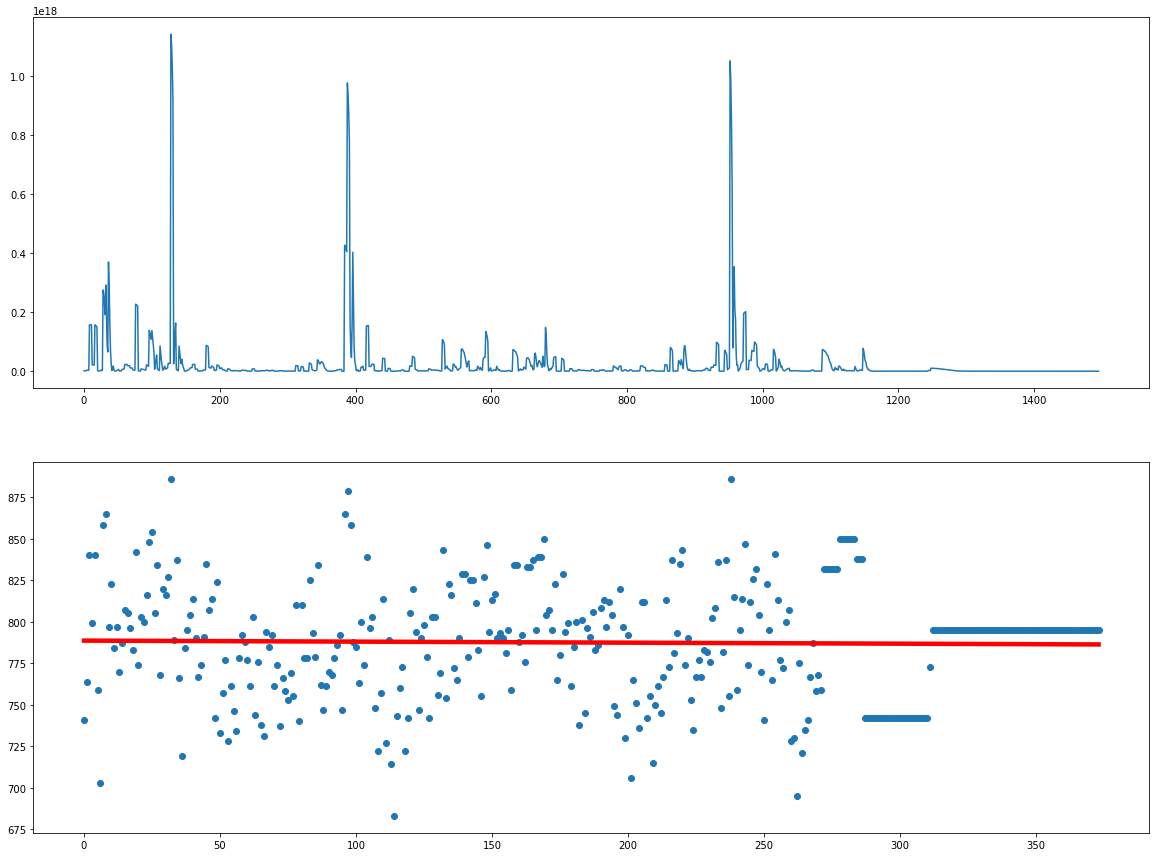

1
Epoch 375: Current Learning Rate: [0.0004816444702533138, 0.007513653735951698, 0.000385315576202652], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  400  is done!


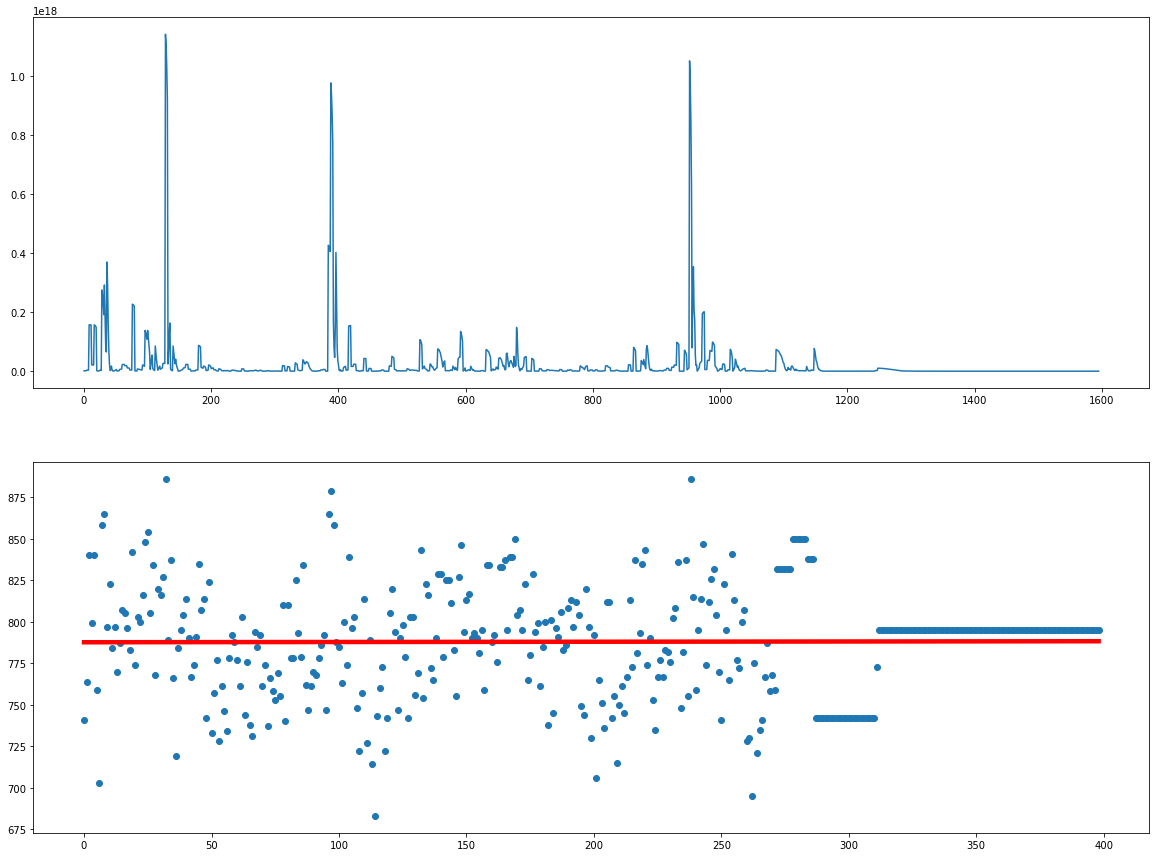

1
Epoch 400: Current Learning Rate: [0.00048044180290391817, 0.007494892125301126, 0.00038435344232313546], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  425  is done!


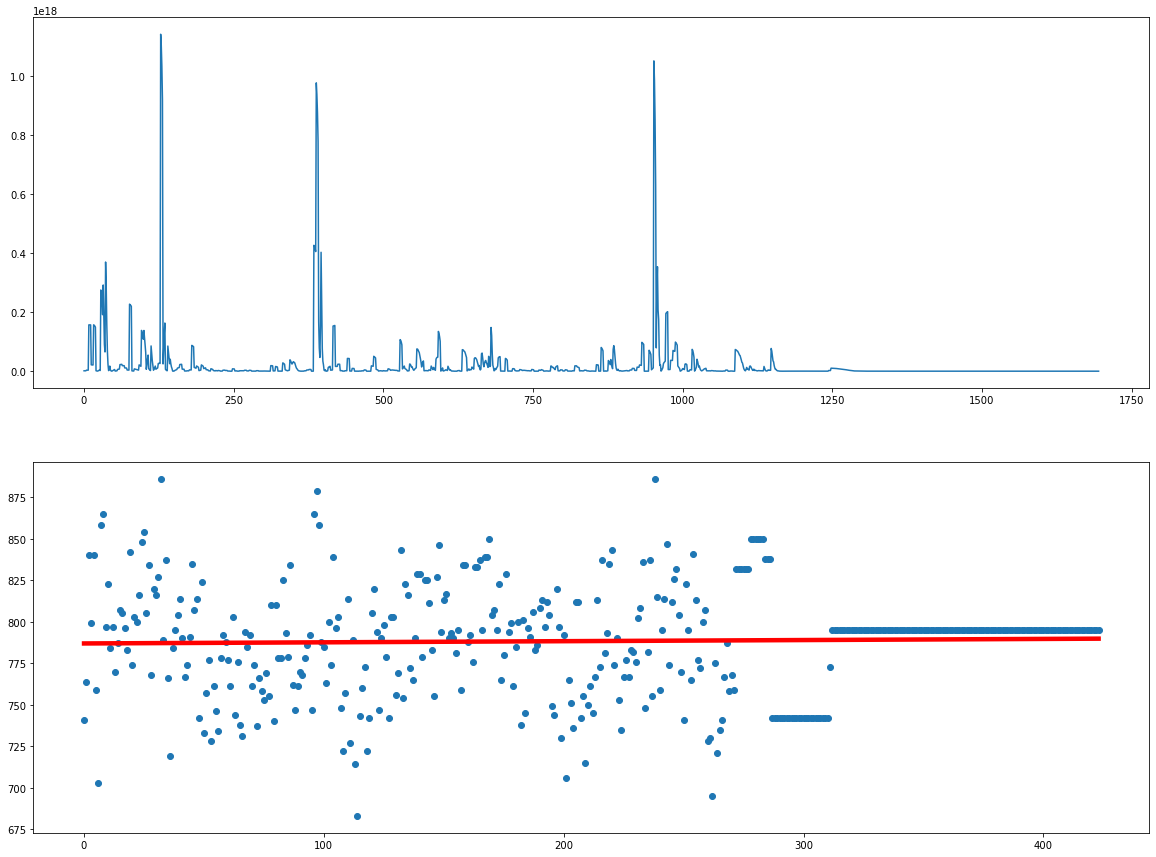

1
Epoch 425: Current Learning Rate: [0.0004792421386176586, 0.007476177362435479, 0.0003833937108941278], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  450  is done!


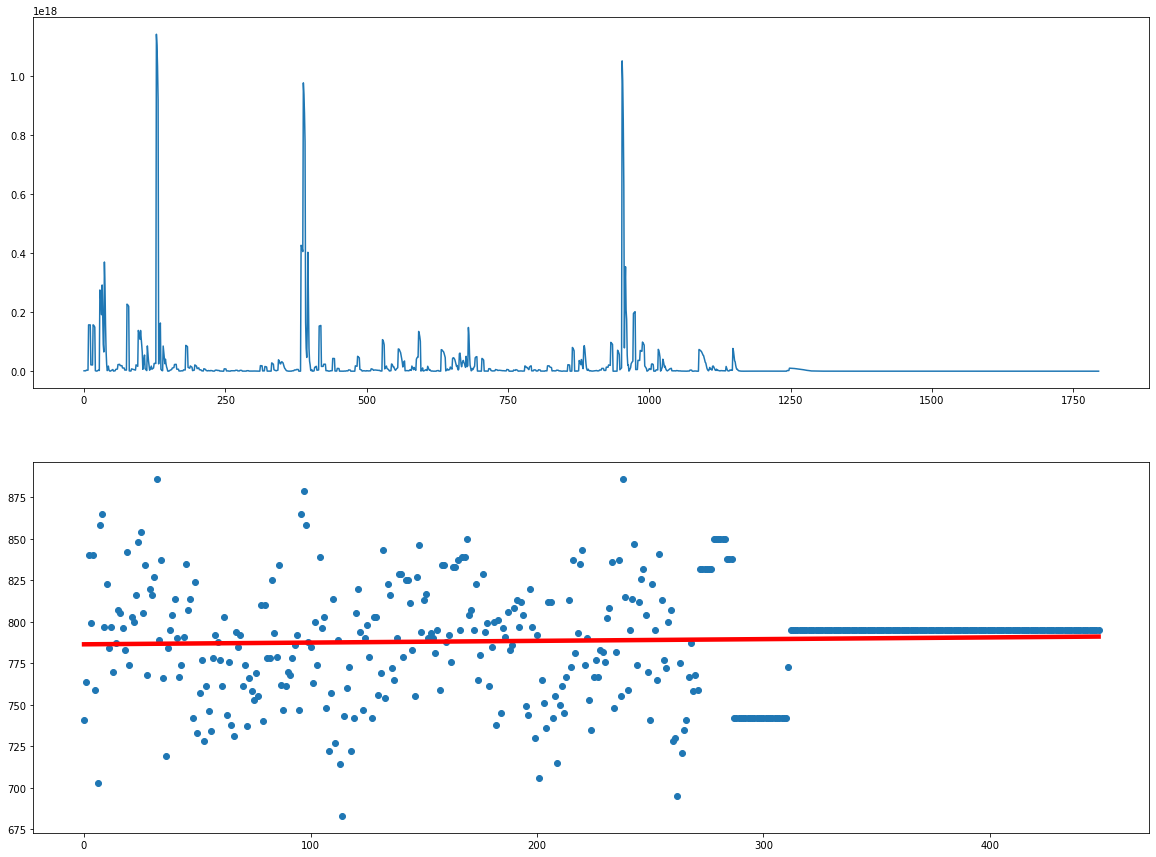

1
Epoch 450: Current Learning Rate: [0.0004780454698958795, 0.007457509330375725, 0.00038243637591670455], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  475  is done!


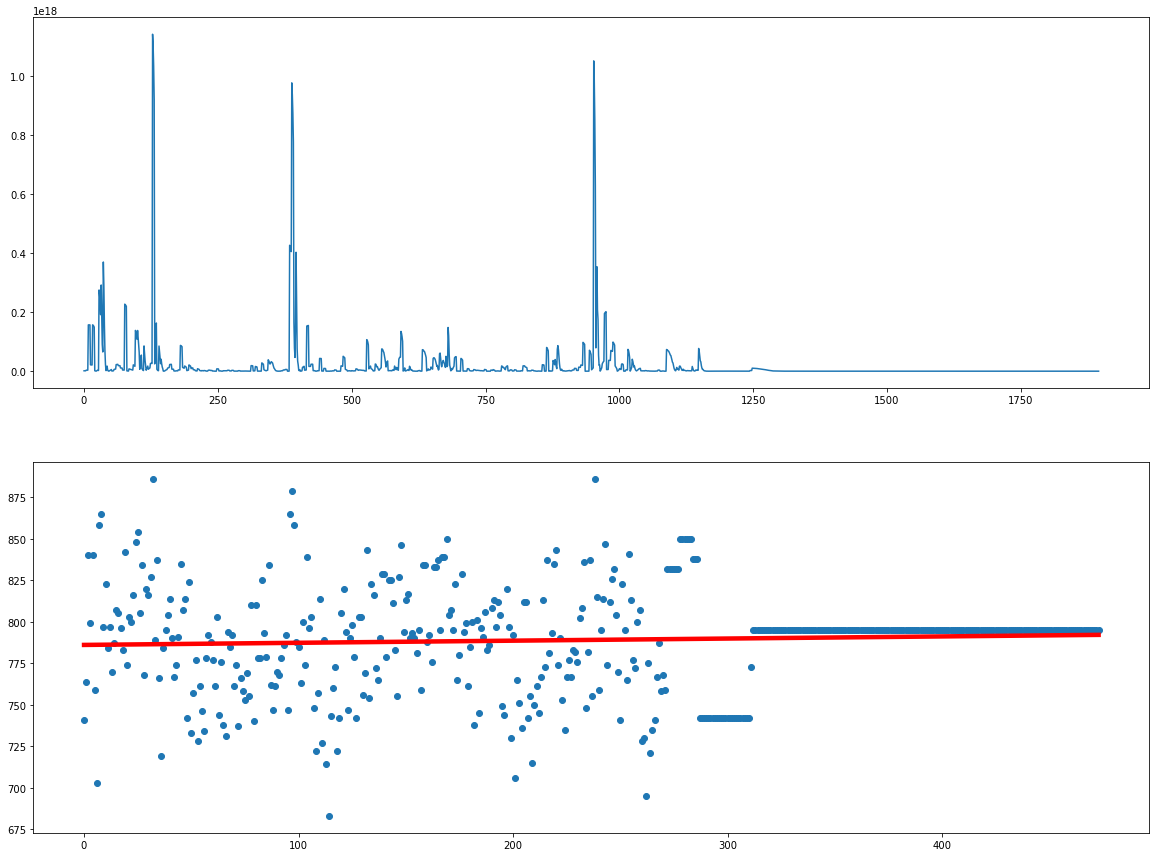

1
Epoch 475: Current Learning Rate: [0.0004768517892586495, 0.007438887912434936, 0.0003814814314069204], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  500  is done!


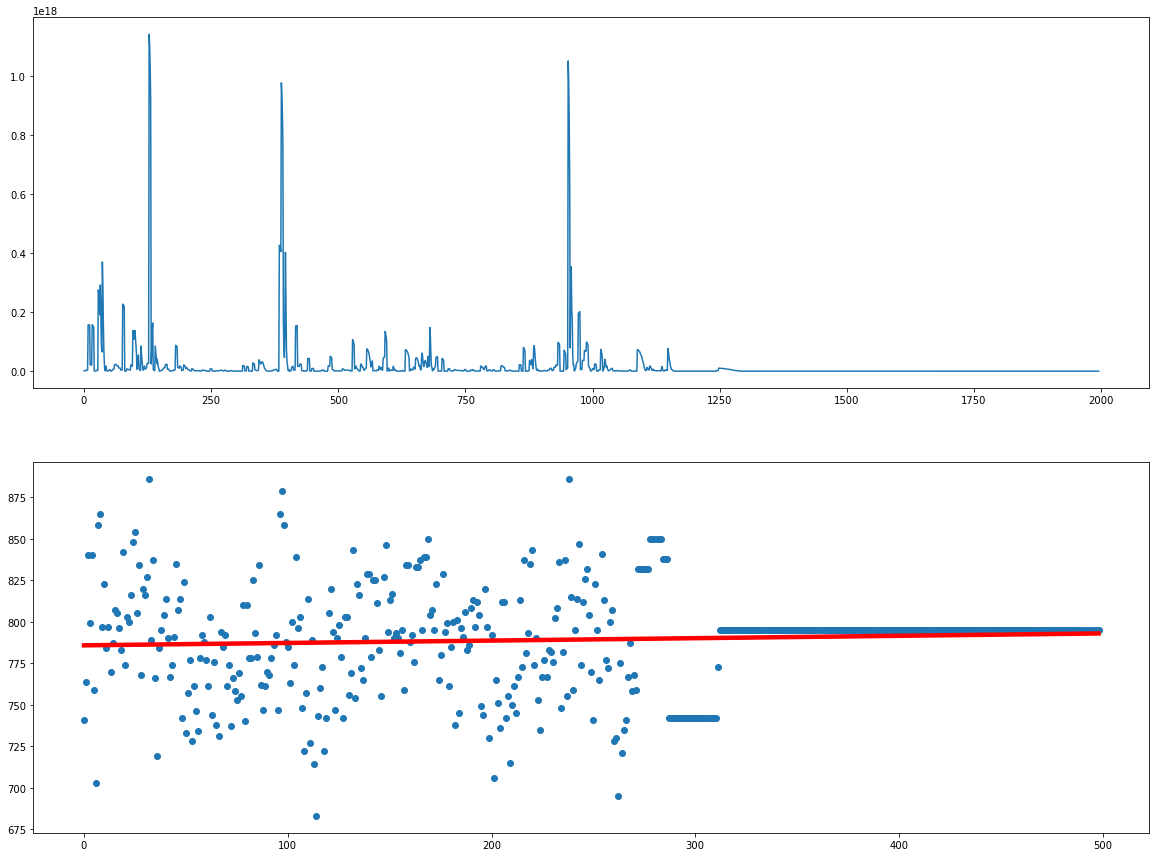

1
Epoch 500: Current Learning Rate: [0.00047566108924471475, 0.007420312992217551, 0.0003805288713957723], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  525  is done!


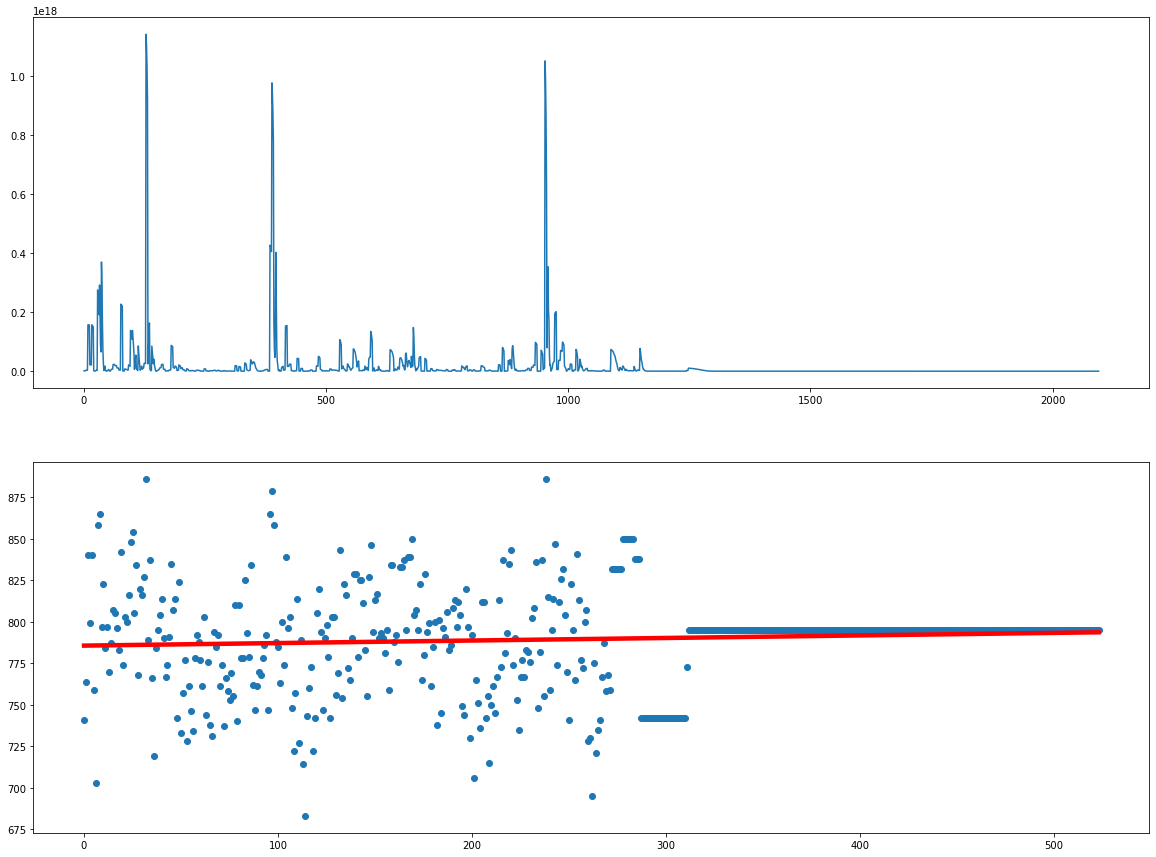

1
Epoch 525: Current Learning Rate: [0.0004744733624114516, 0.007401784453618647, 0.00037957868992916197], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  550  is done!


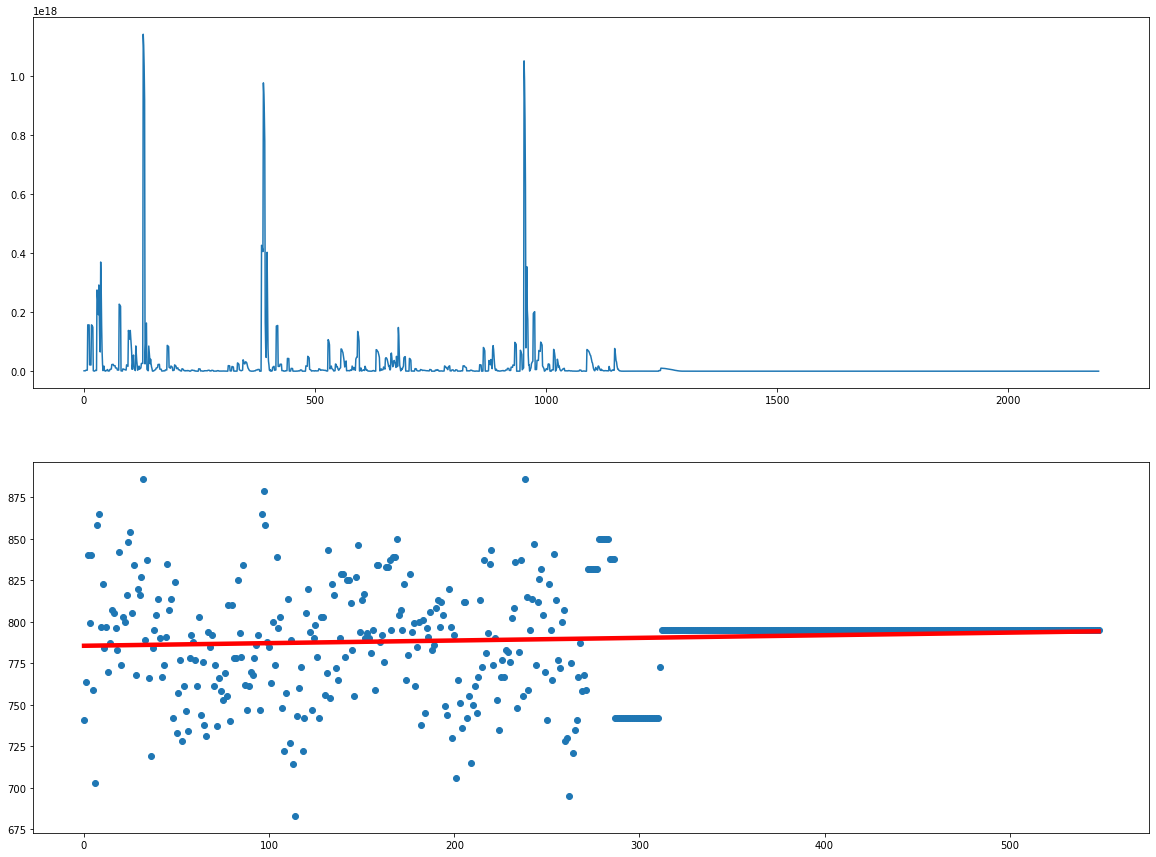

1
Epoch 550: Current Learning Rate: [0.00047328860133482155, 0.007383302180823218, 0.0003786308810678579], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  575  is done!


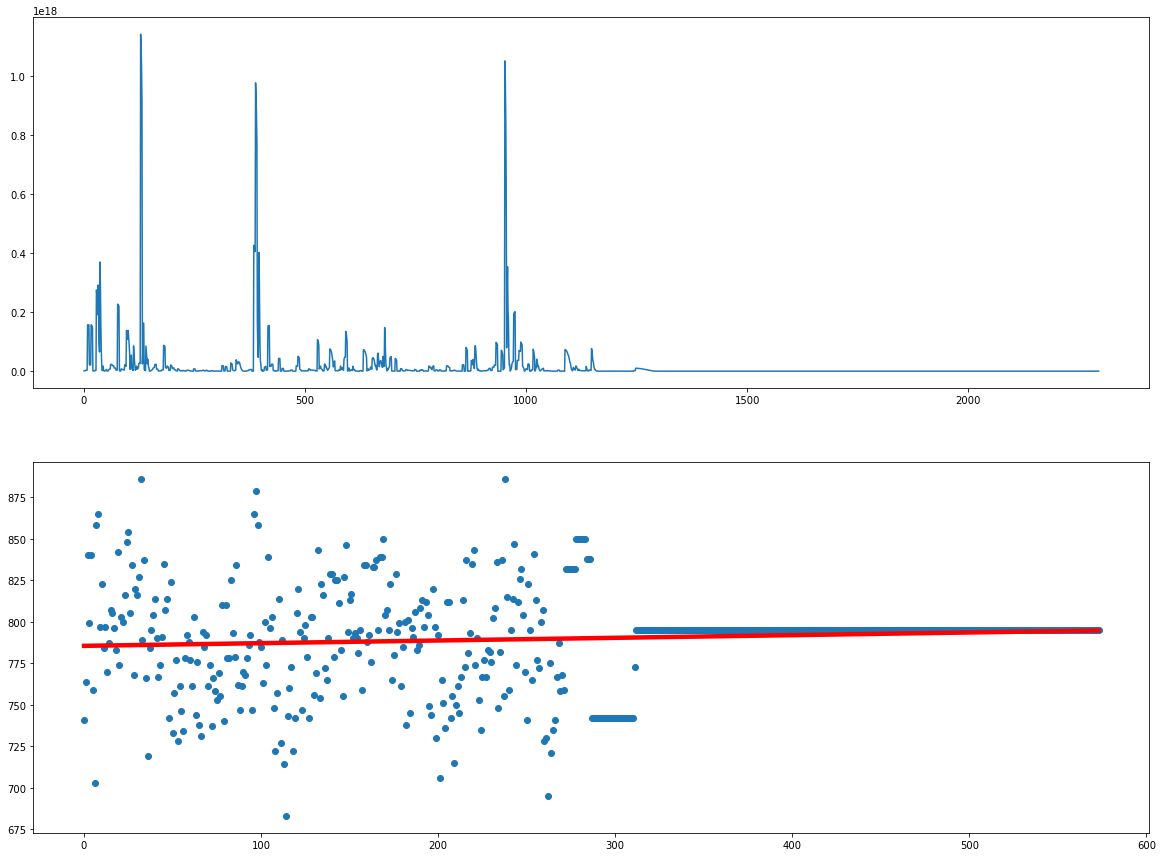

1
Epoch 575: Current Learning Rate: [0.0004721067986093233, 0.007364866058305447, 0.00037768543888745936], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  600  is done!


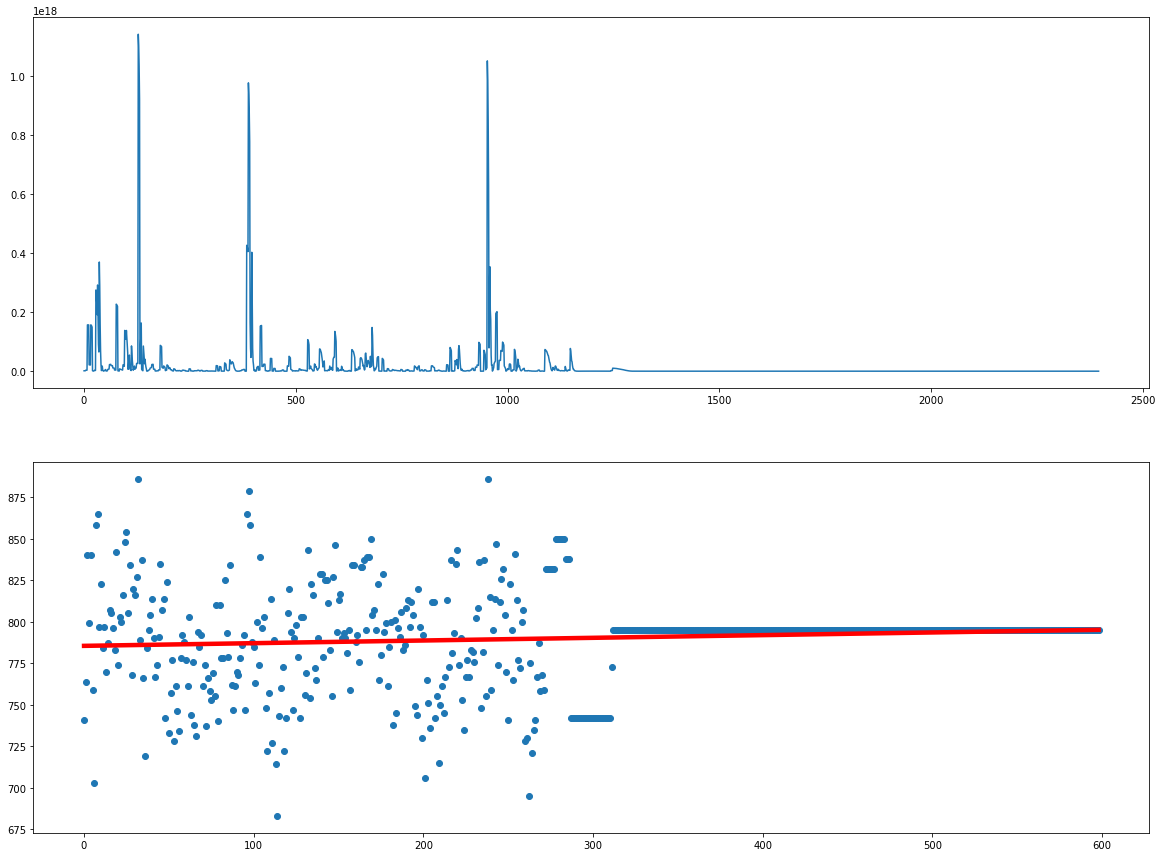

1
Epoch 600: Current Learning Rate: [0.0004709279468479474, 0.007346475970827981, 0.0003767423574783585], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  625  is done!


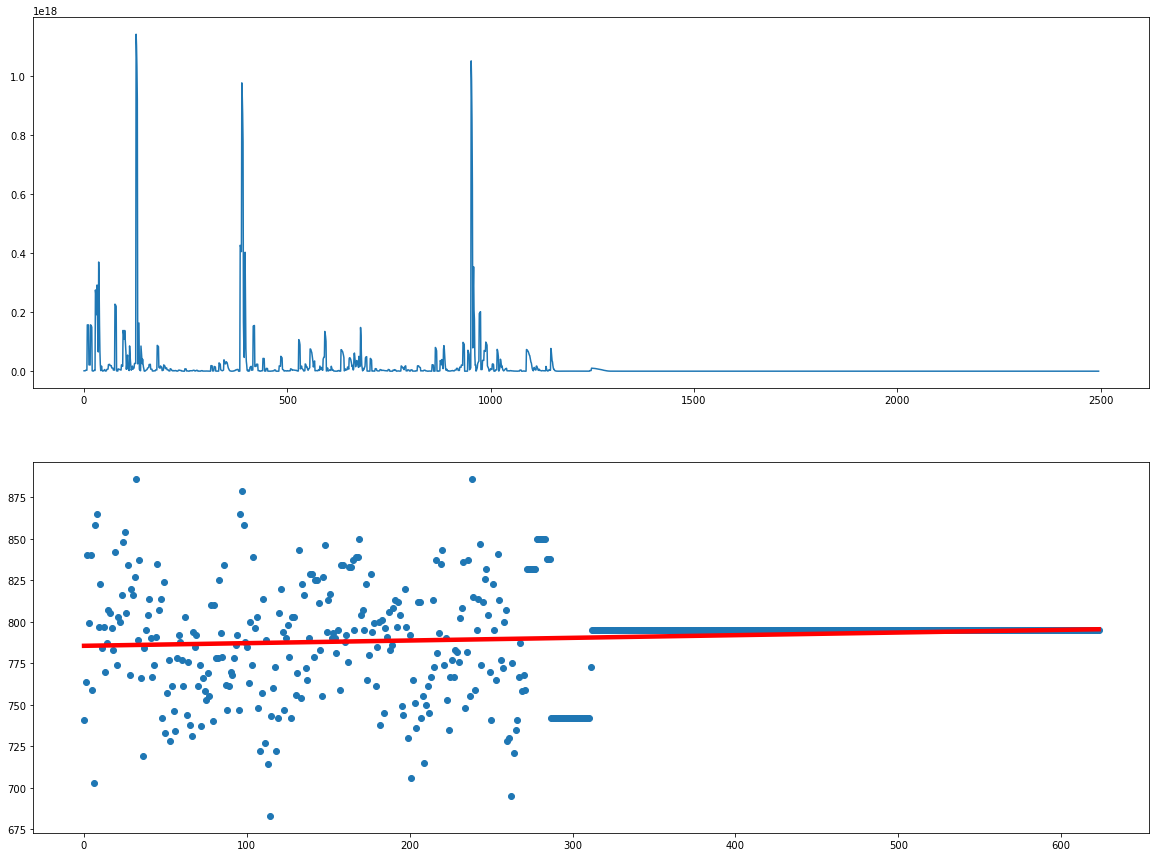

1
Epoch 625: Current Learning Rate: [0.00046975203868212937, 0.007328131803441222, 0.000375801630945704], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  650  is done!


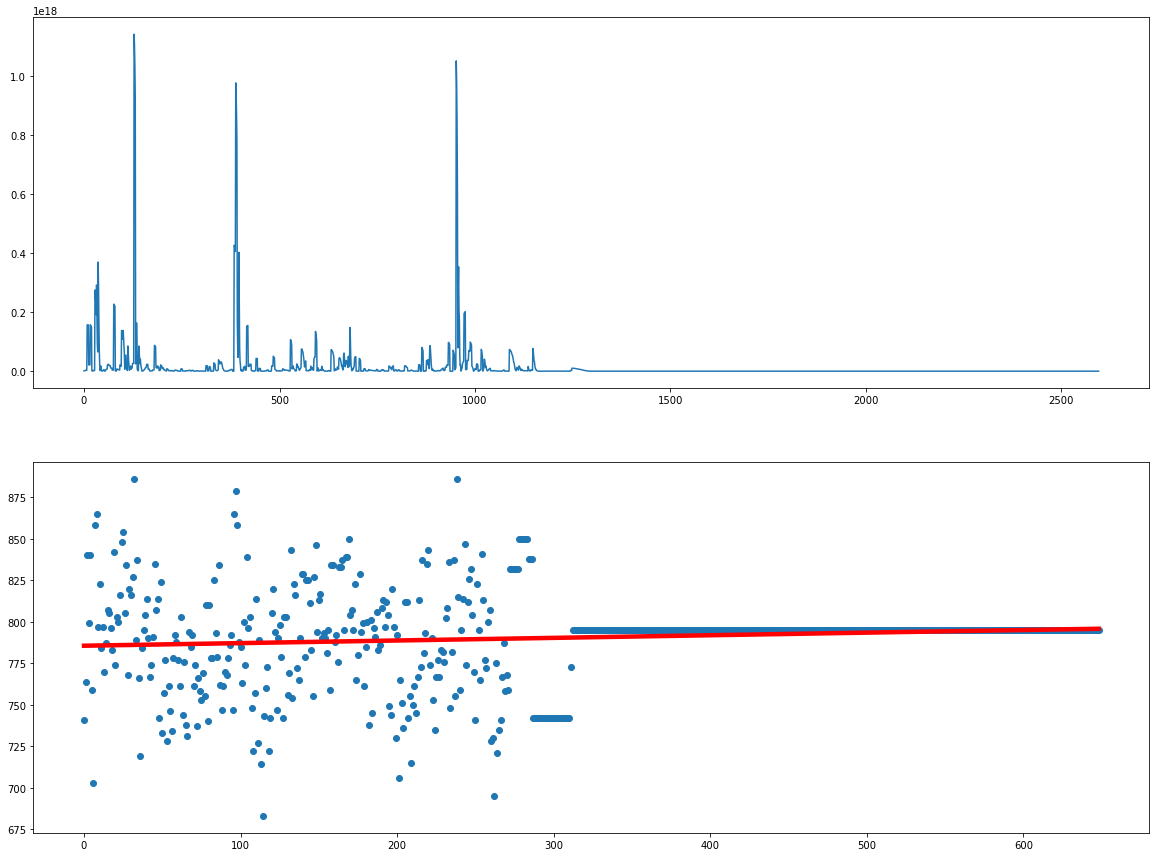

1
Epoch 650: Current Learning Rate: [0.00046857906676170446, 0.007309833441482595, 0.000374863253409364], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  675  is done!


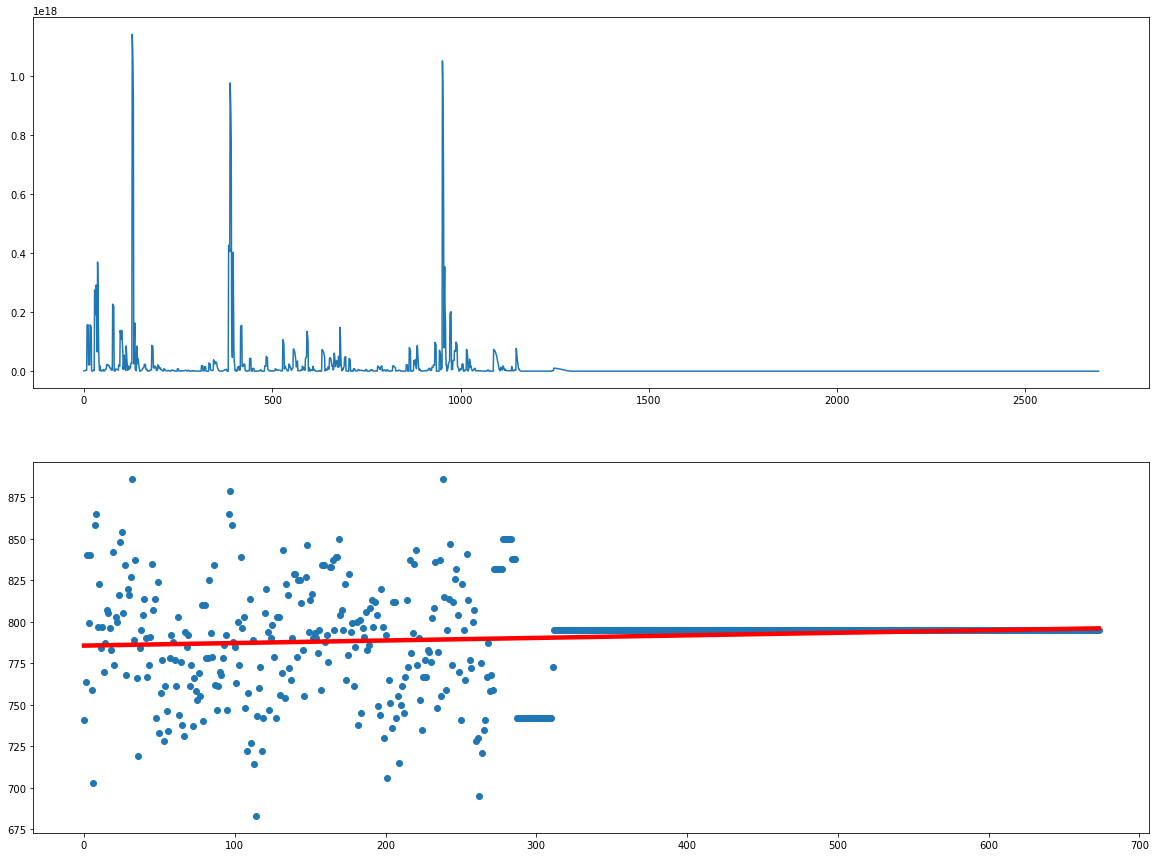

1
Epoch 675: Current Learning Rate: [0.00046740902375486126, 0.007291580770575839, 0.0003739272190038896], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  700  is done!


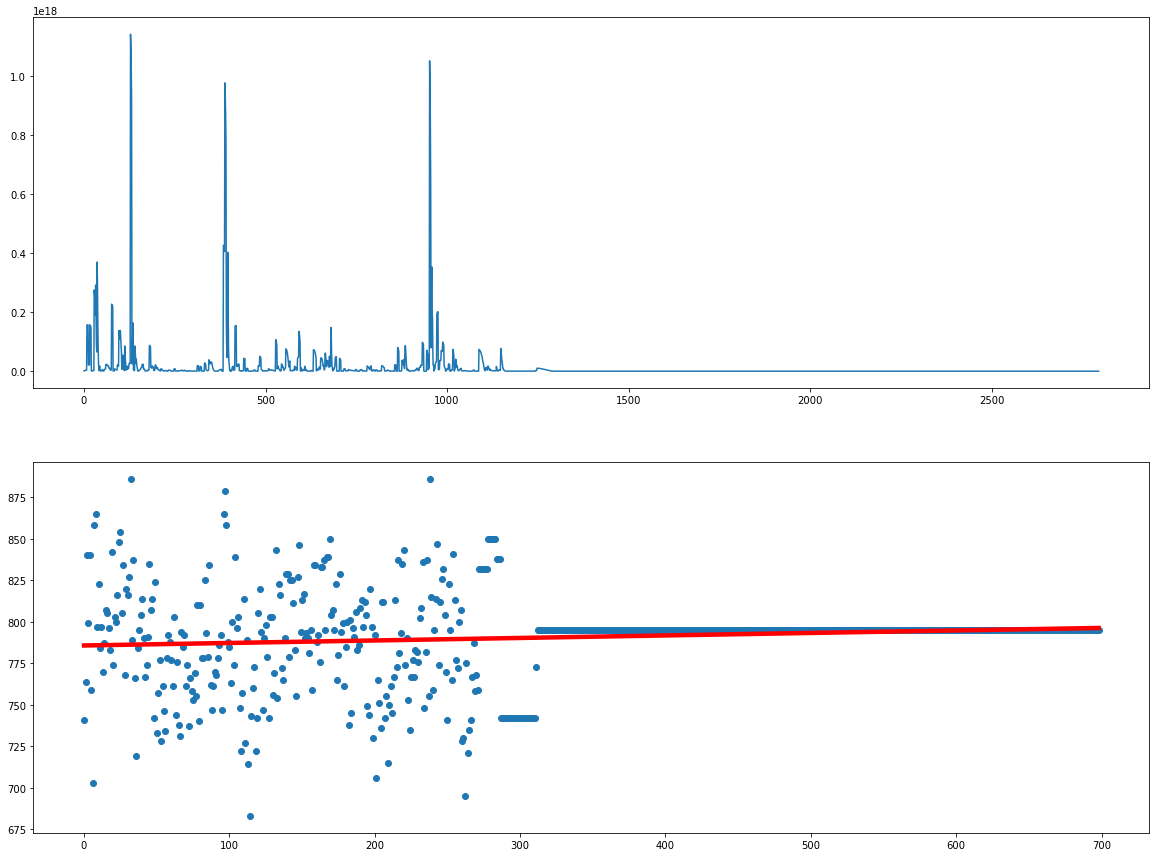

1
Epoch 700: Current Learning Rate: [0.00046624190234809576, 0.007273373676630296, 0.00037299352187847724], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  725  is done!


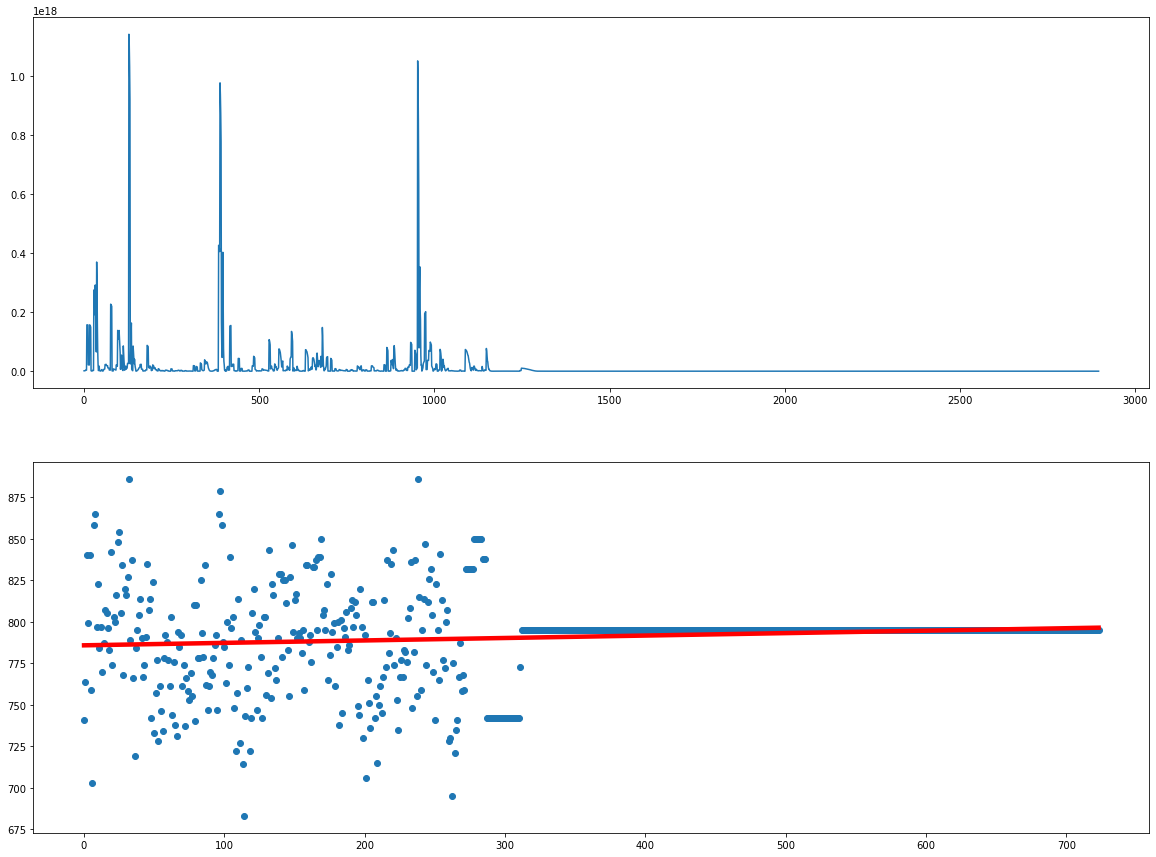

1
Epoch 725: Current Learning Rate: [0.0004650776952461659, 0.00725521204584019, 0.0003720621561969333], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  750  is done!


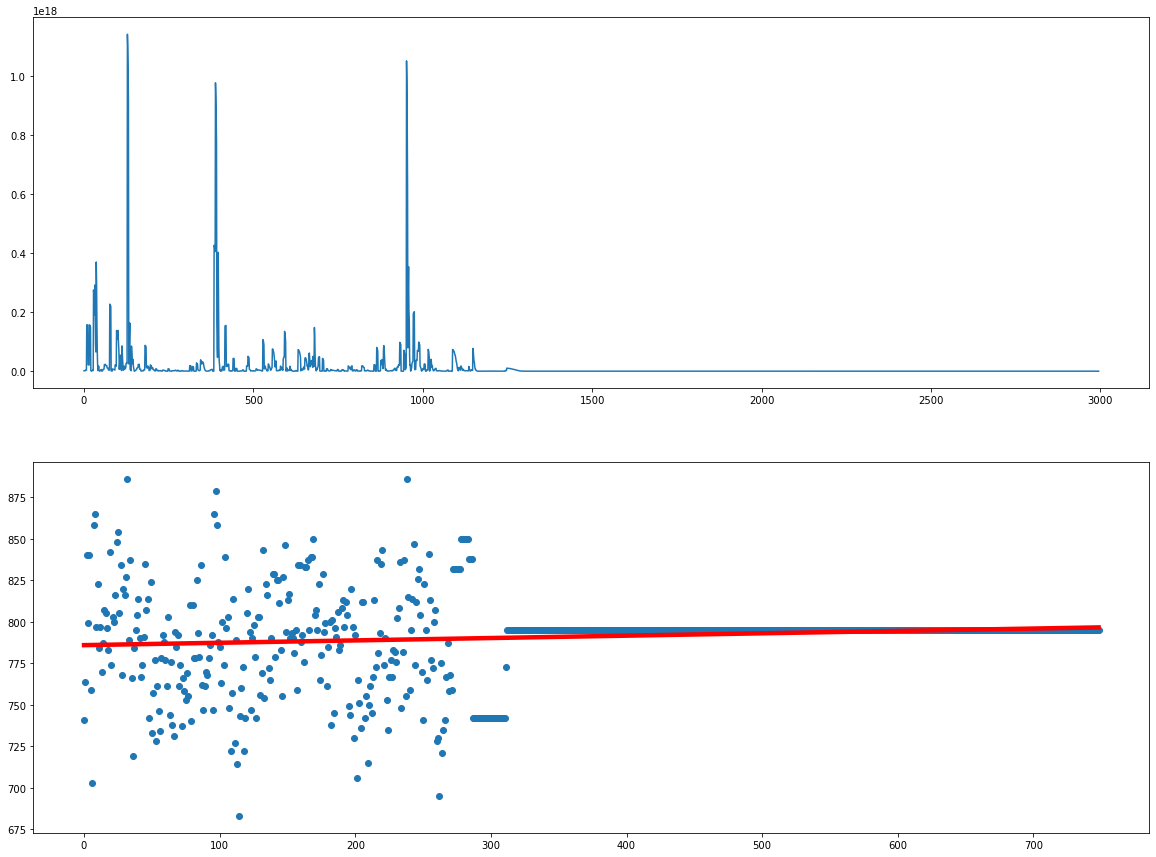

1
Epoch 750: Current Learning Rate: [0.0004639163951720458, 0.007237095764683917, 0.0003711331161376372], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  775  is done!


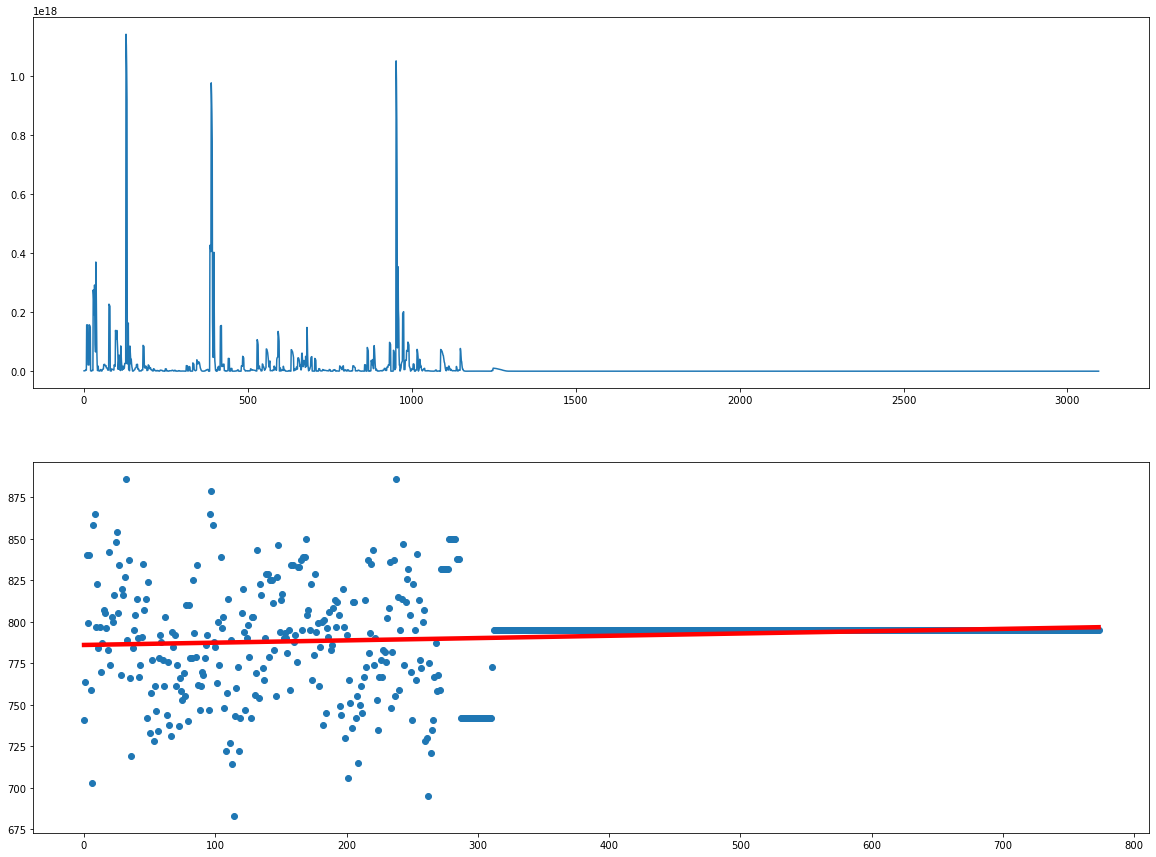

1
Epoch 775: Current Learning Rate: [0.00046275799486688023, 0.0072190247199233355, 0.0003702063958935047], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  800  is done!


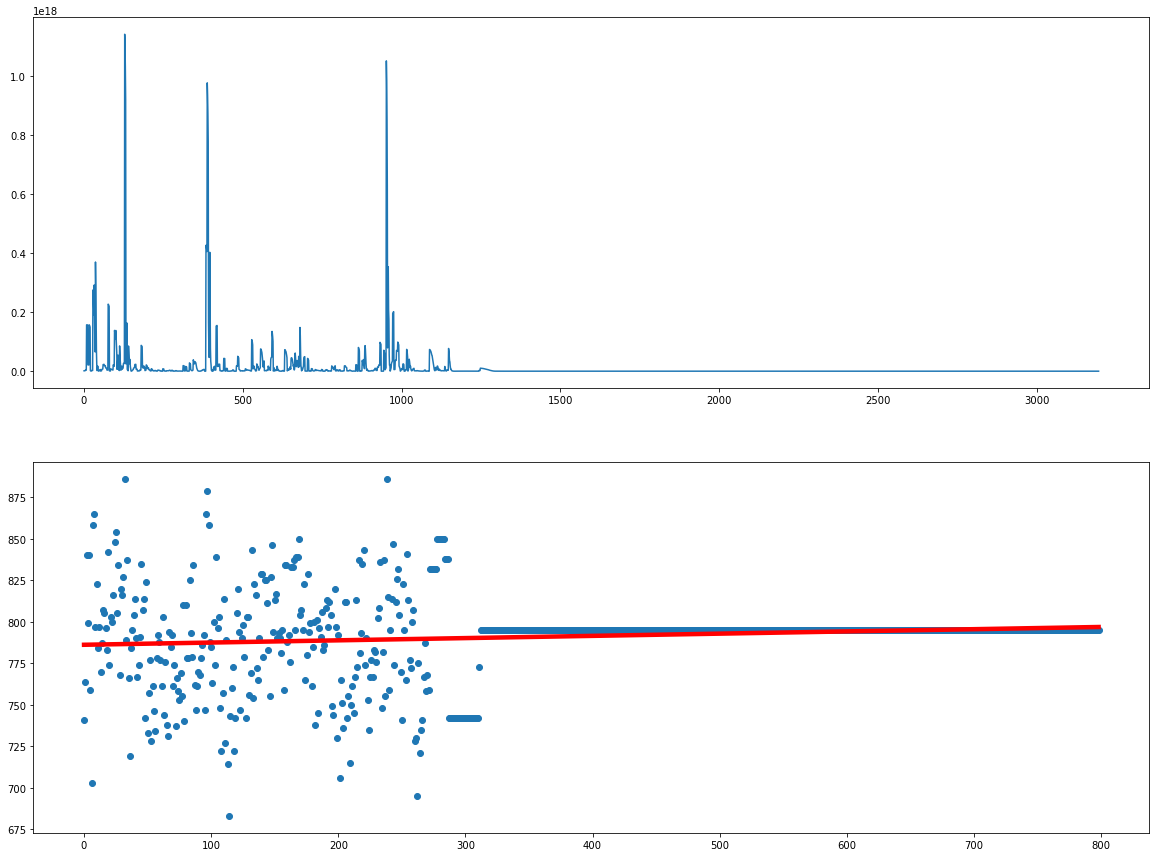

1
Epoch 800: Current Learning Rate: [0.00046160248708993954, 0.007200998798603059, 0.00036928198967195225], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  825  is done!


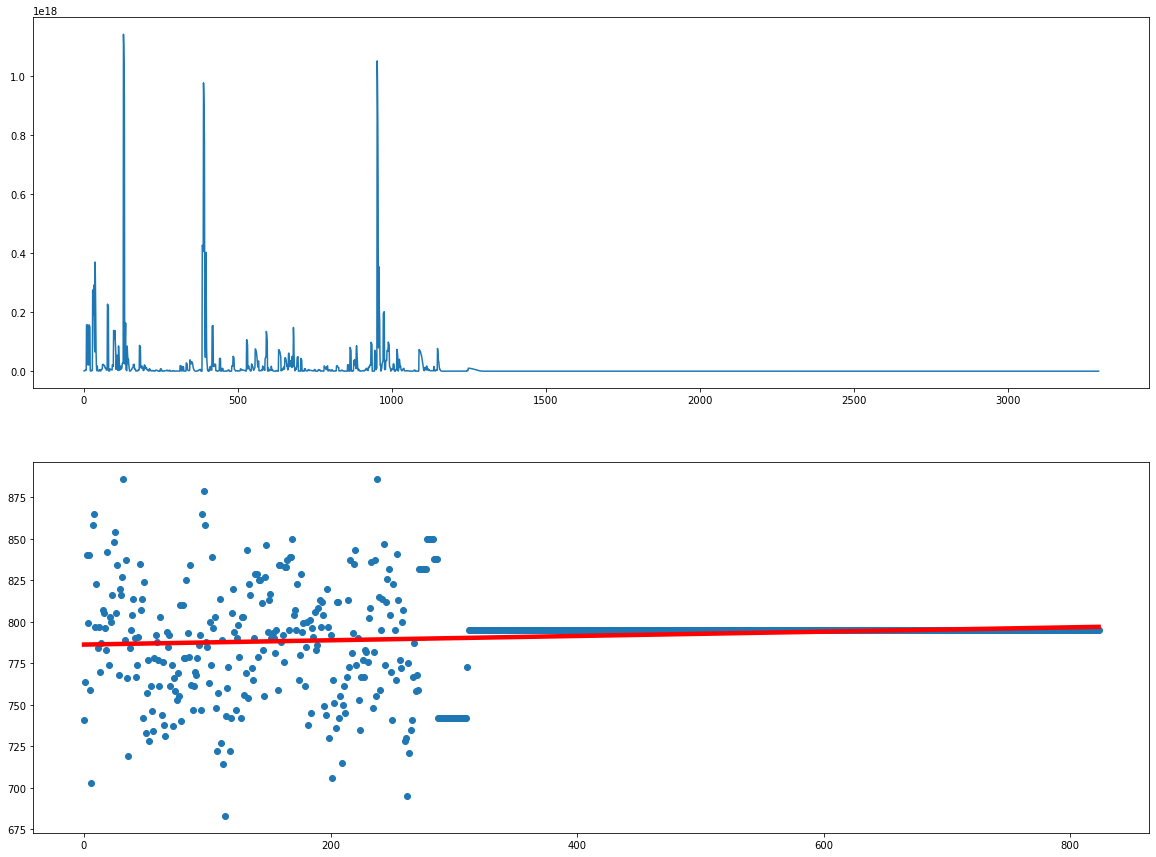

1
Epoch 825: Current Learning Rate: [0.0004604498646185741, 0.007183017888049759, 0.00036835989169485984], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  850  is done!


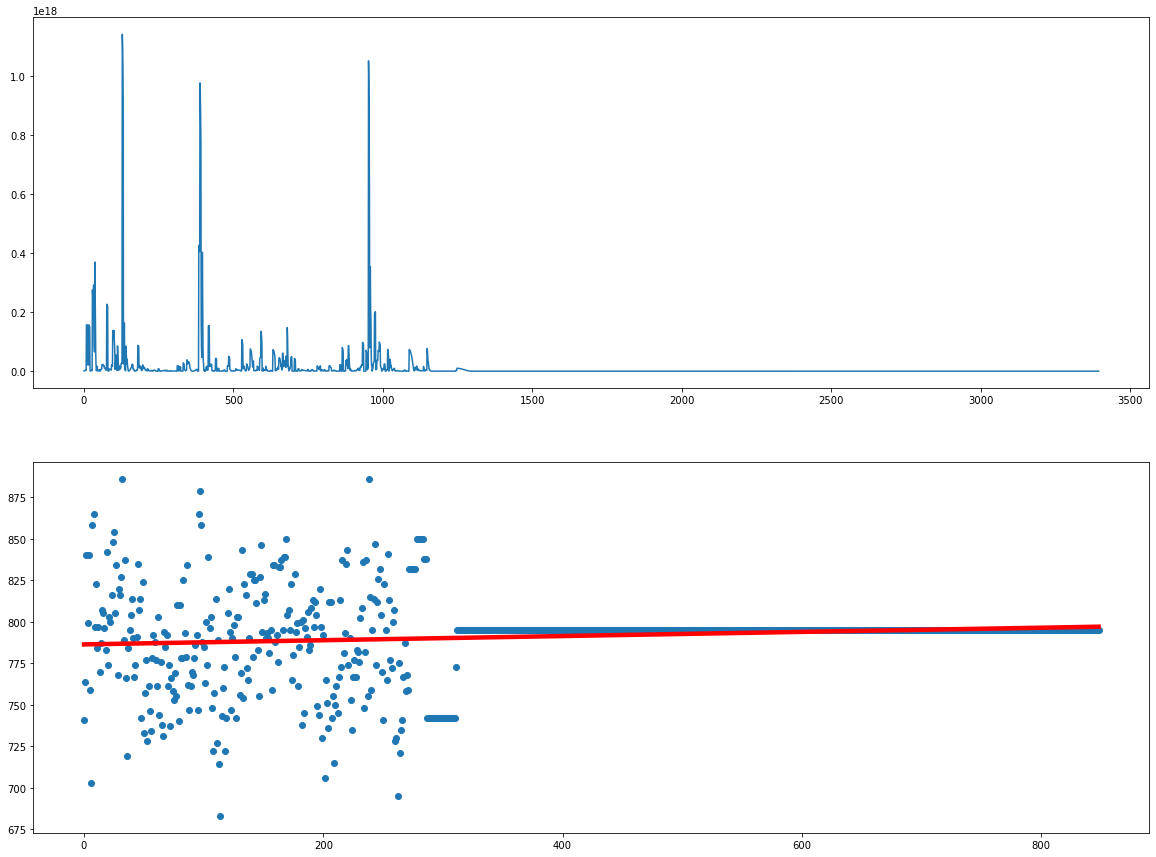

1
Epoch 850: Current Learning Rate: [0.0004593001202481692, 0.0071650818758714424, 0.0003674400961985359], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  875  is done!


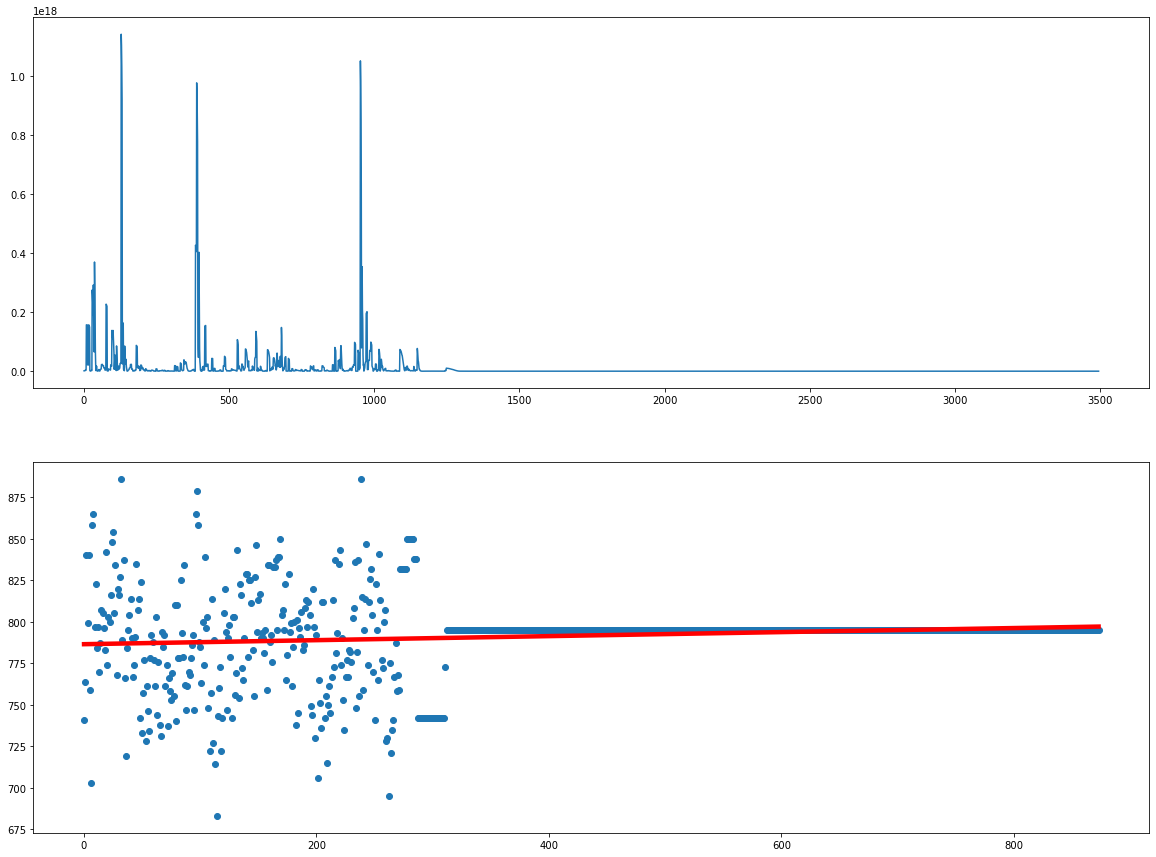

1
Epoch 875: Current Learning Rate: [0.00045815324679210015, 0.007147190649956767, 0.00036652259743368075], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  900  is done!


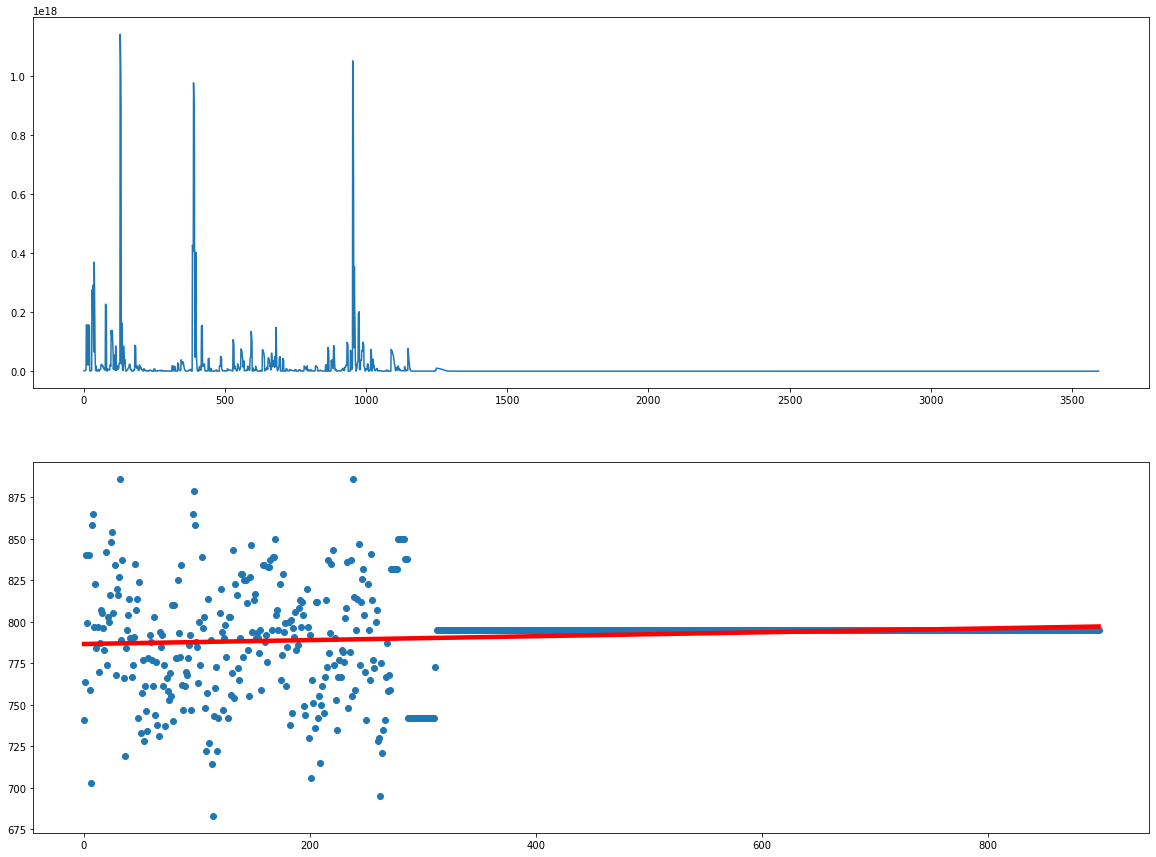

1
Epoch 900: Current Learning Rate: [0.00045700923708168726, 0.007129344098474325, 0.00036560738966535044], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  925  is done!


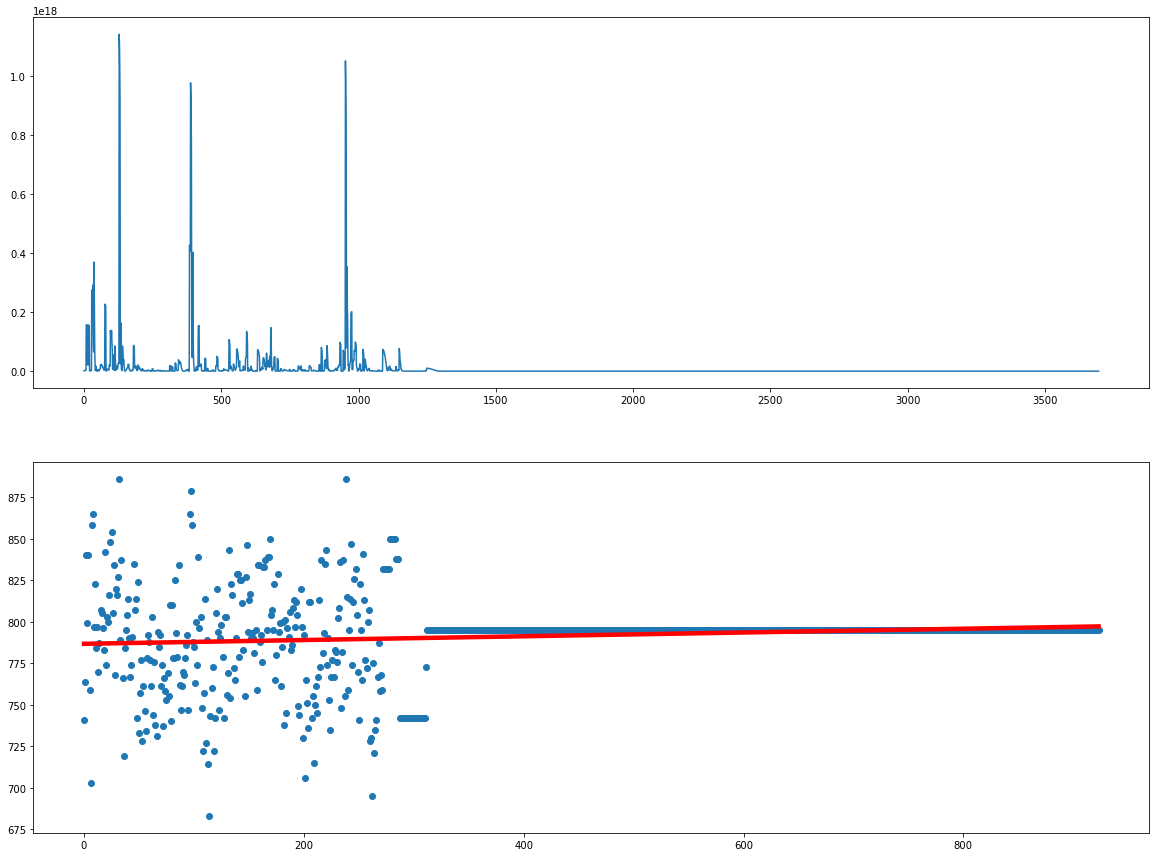

1
Epoch 925: Current Learning Rate: [0.00045586808396615093, 0.0071115421098719616, 0.00036469446717292143], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  950  is done!


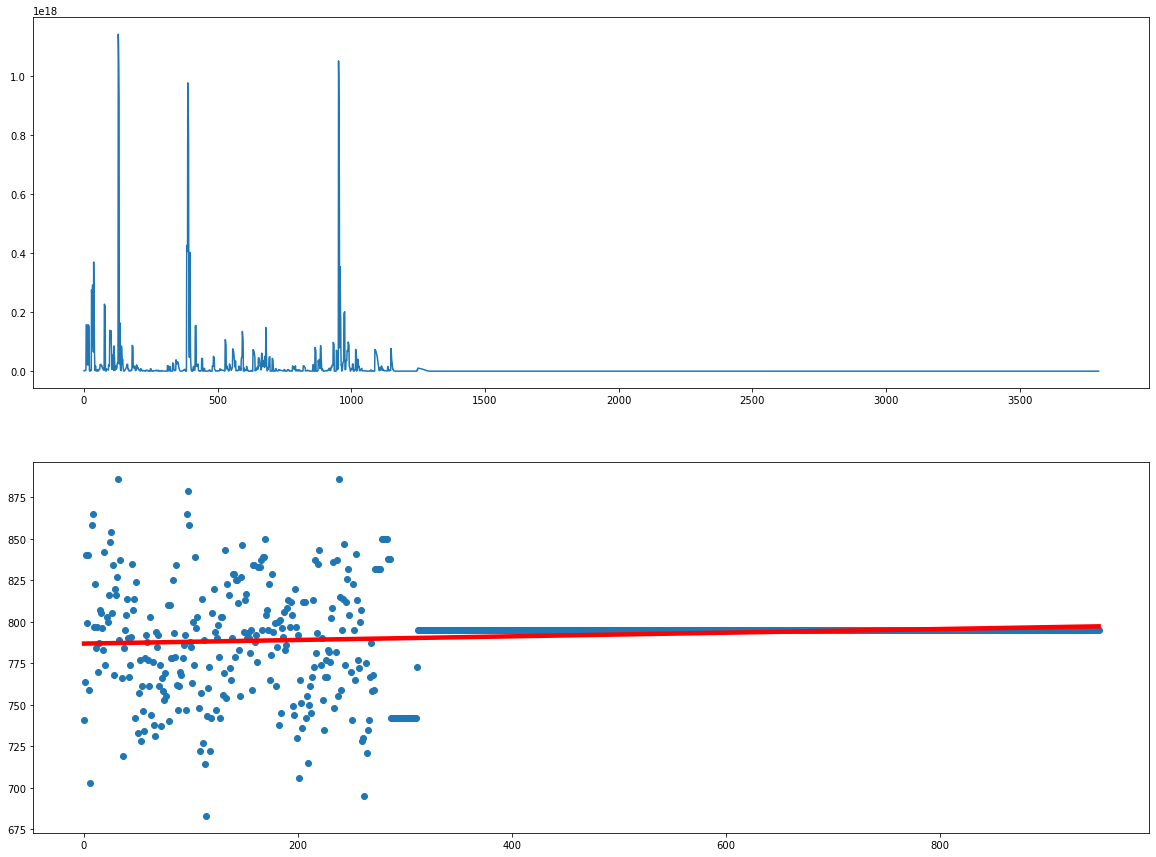

1
Epoch 950: Current Learning Rate: [0.00045472978031256745, 0.007093784572876059, 0.0003637838242500546], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  975  is done!


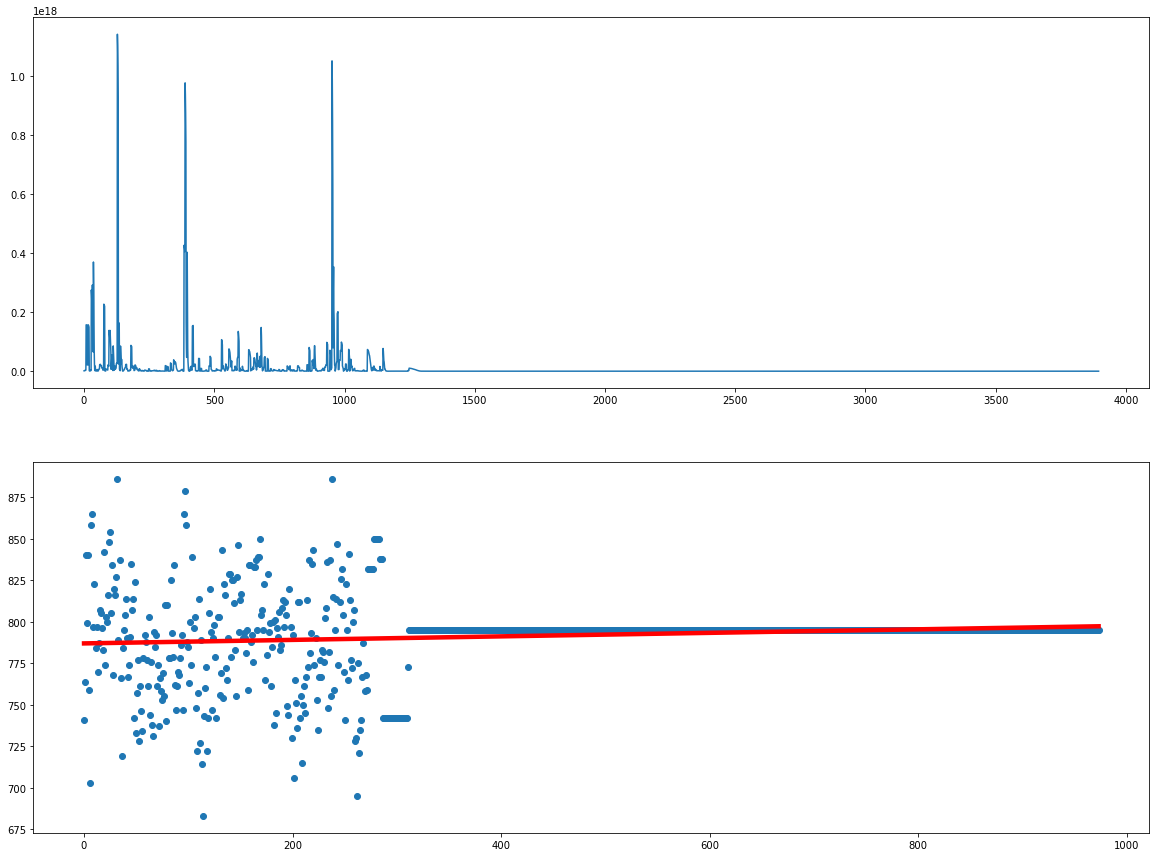

1
Epoch 975: Current Learning Rate: [0.00045359431900582353, 0.007076071376490854, 0.0003628754552046596], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1000  is done!


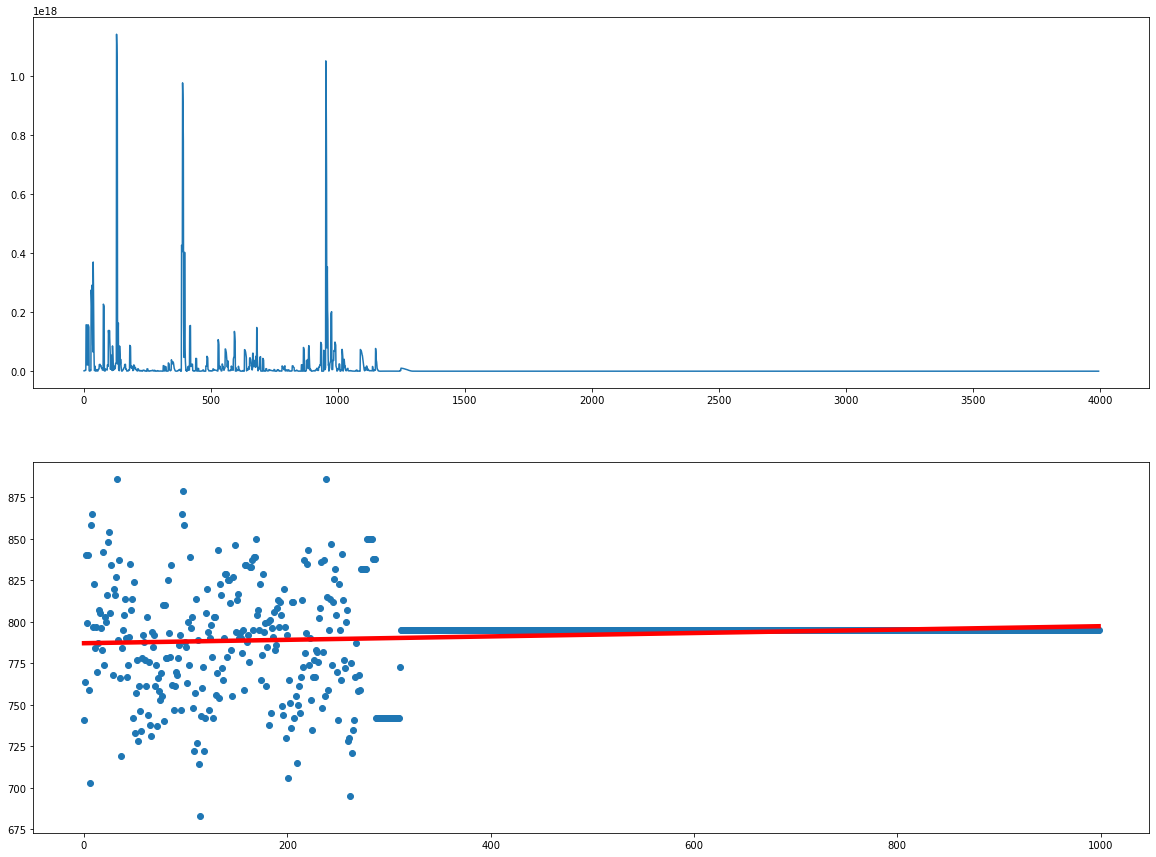

1
Epoch 1000: Current Learning Rate: [0.00045246169294857274, 0.007058402409997742, 0.00036196935435885895], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1025  is done!


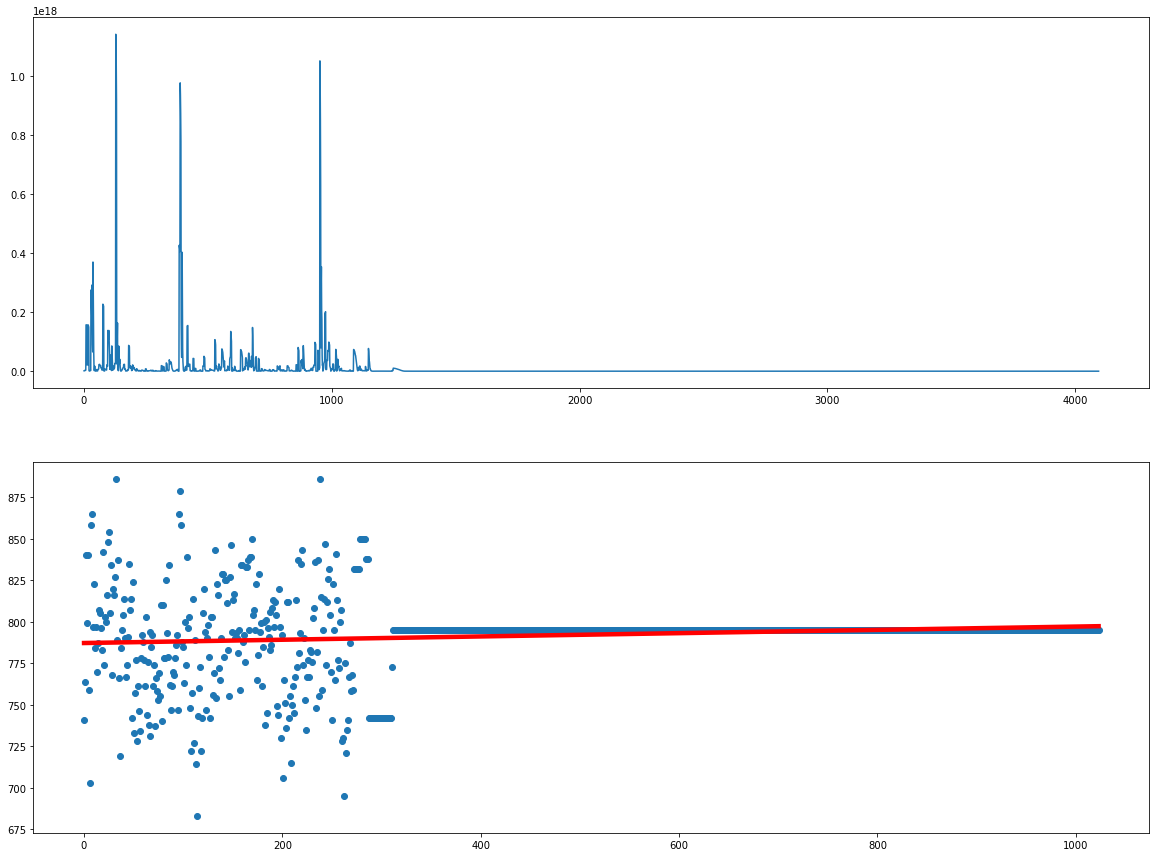

1
Epoch 1025: Current Learning Rate: [0.00045133189506119055, 0.0070407775629545795, 0.0003610655160489531], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1050  is done!


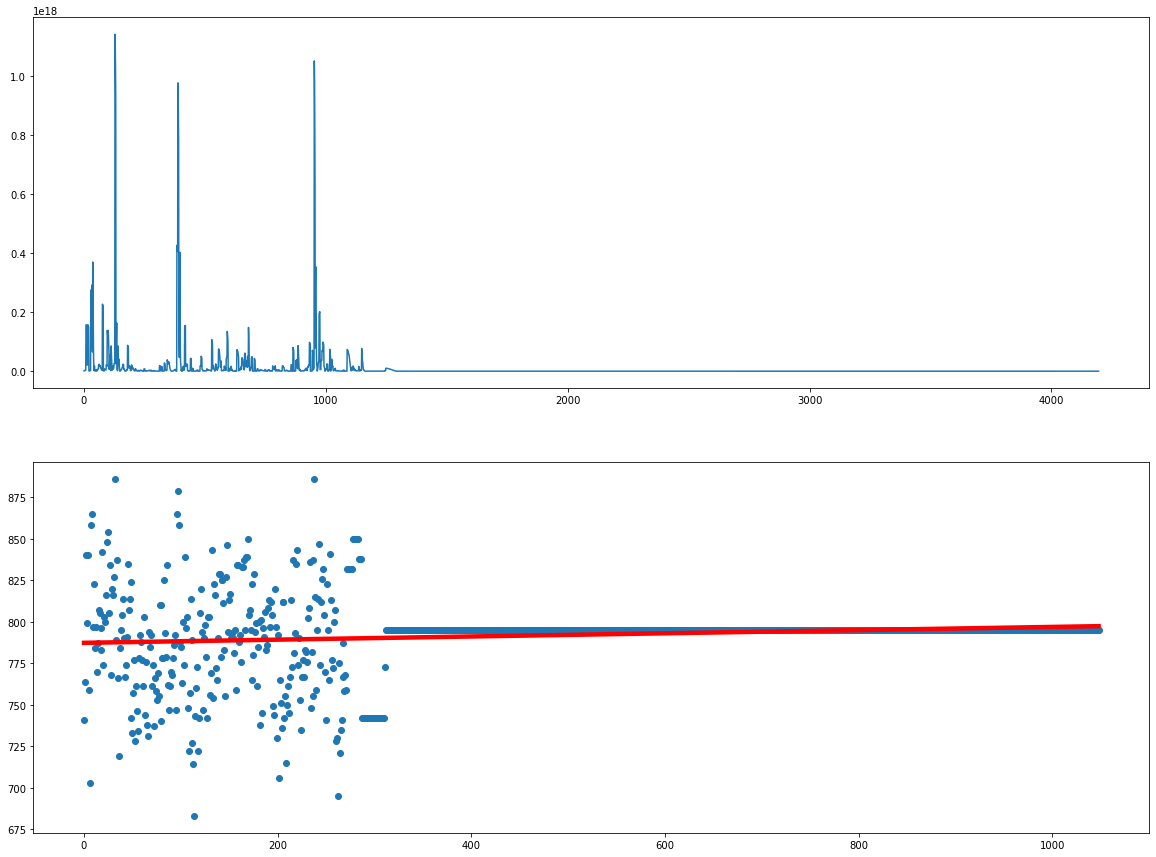

1
Epoch 1050: Current Learning Rate: [0.0004502049182817302, 0.0070231967251949984, 0.00036016393462538483], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1075  is done!


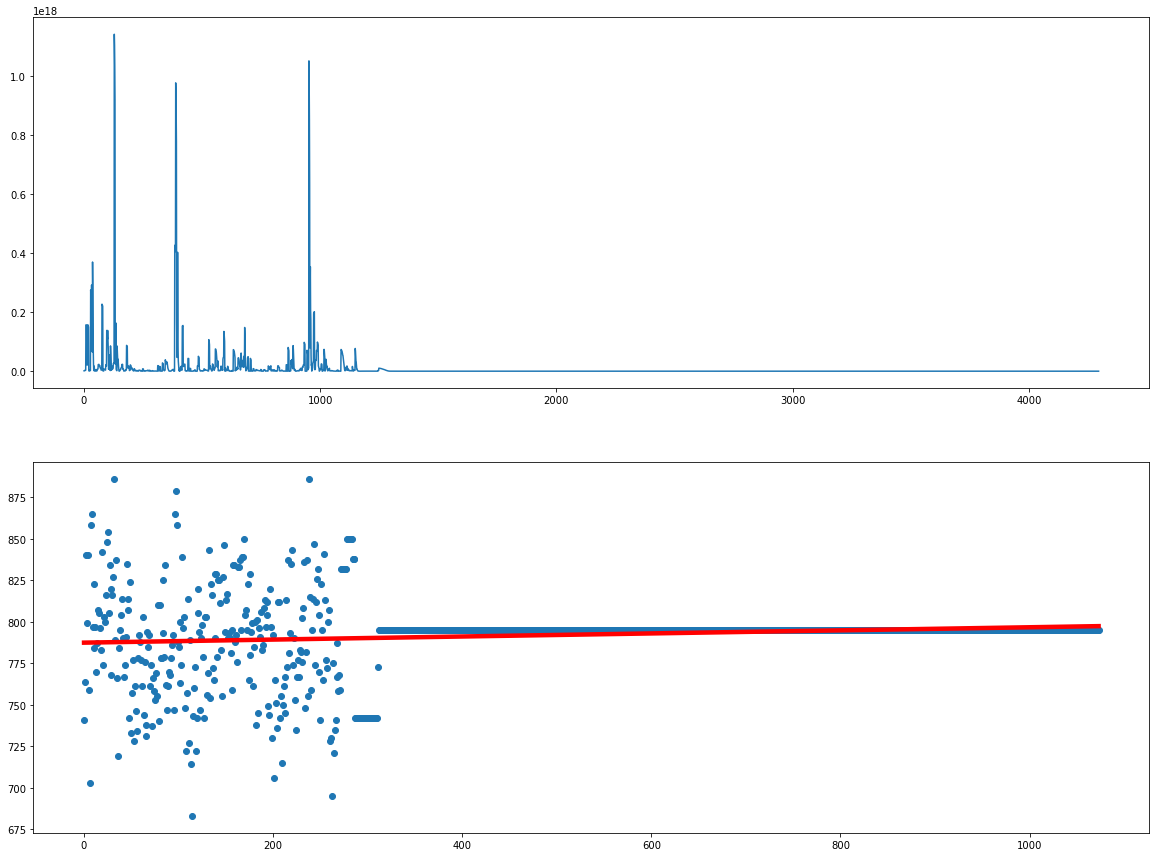

1
Epoch 1075: Current Learning Rate: [0.0004490807555658787, 0.007005659786827717, 0.00035926460445270385], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1100  is done!


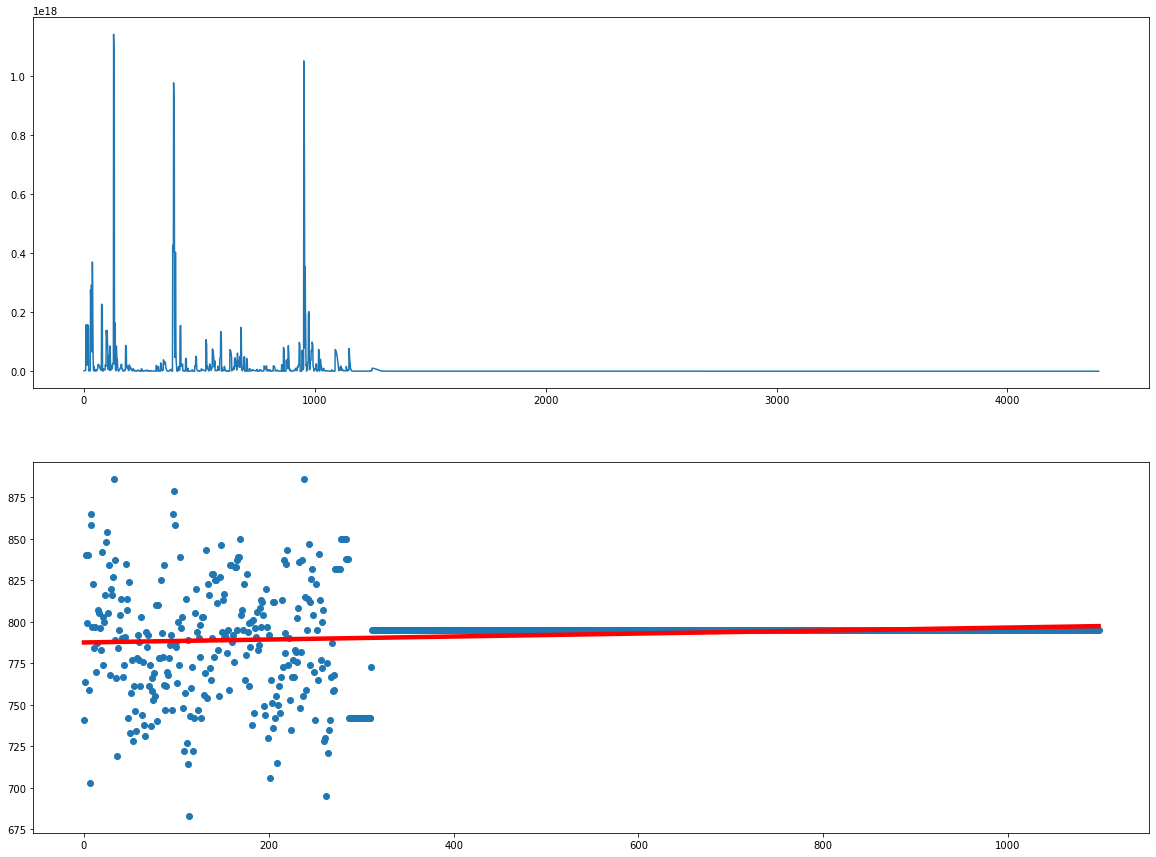

1
Epoch 1100: Current Learning Rate: [0.000447959399886913, 0.006988166638235849, 0.00035836751990953134], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1125  is done!


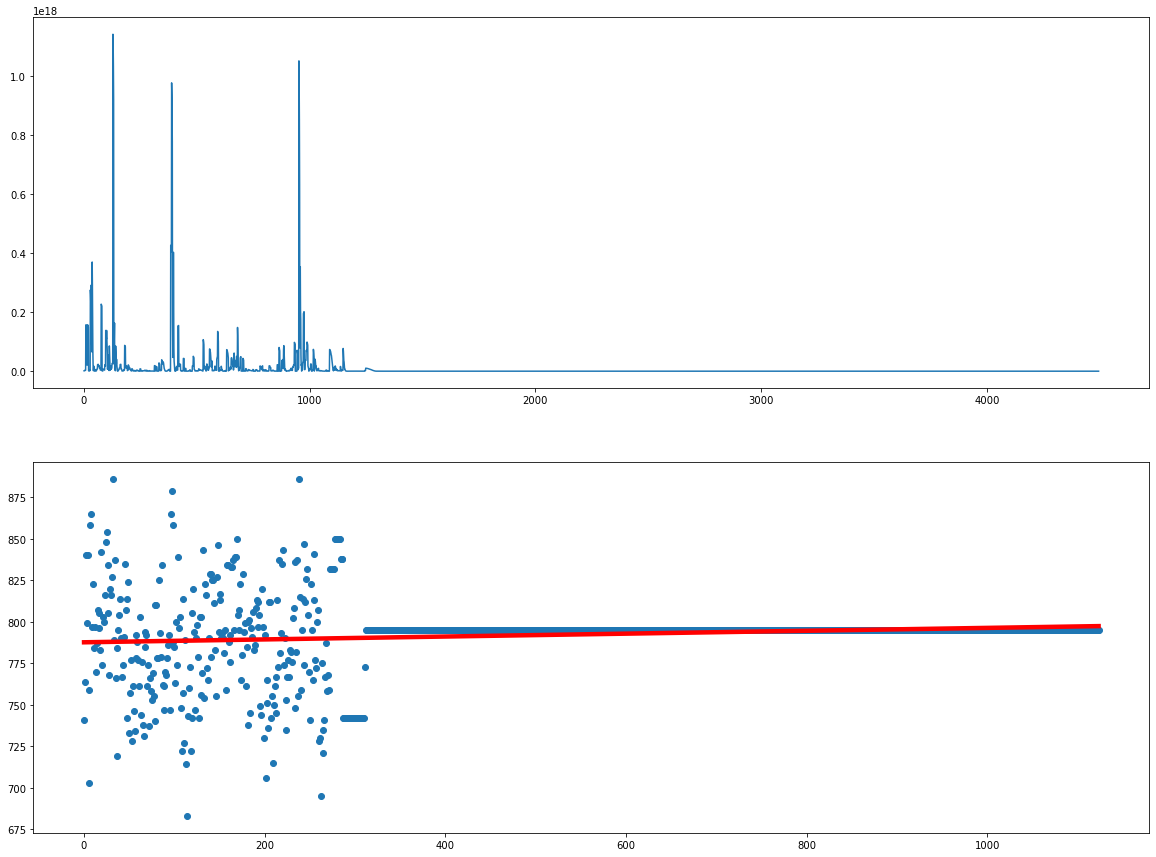

1
Epoch 1125: Current Learning Rate: [0.00044684084423565534, 0.006970717170076228, 0.0003574726753885251], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1150  is done!


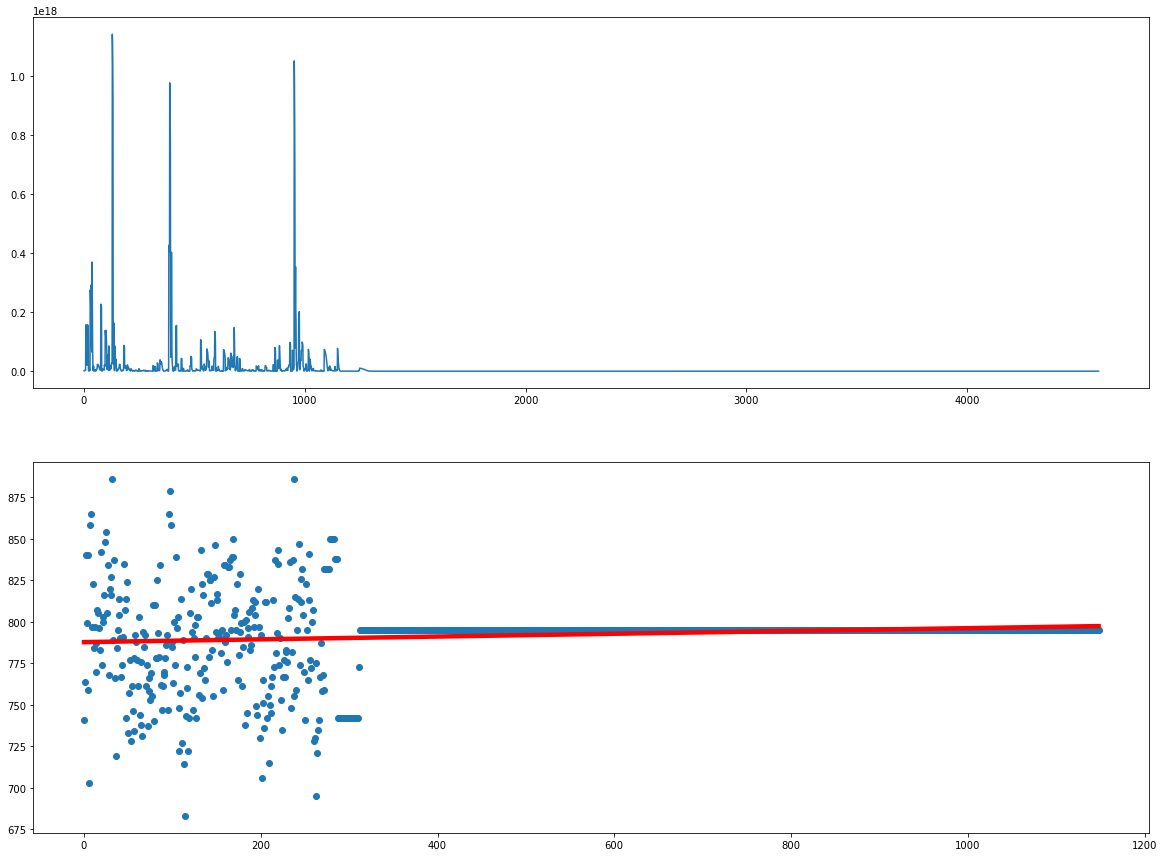

1
Epoch 1150: Current Learning Rate: [0.00044572508162043004, 0.006953311273278712, 0.00035658006529634483], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1175  is done!


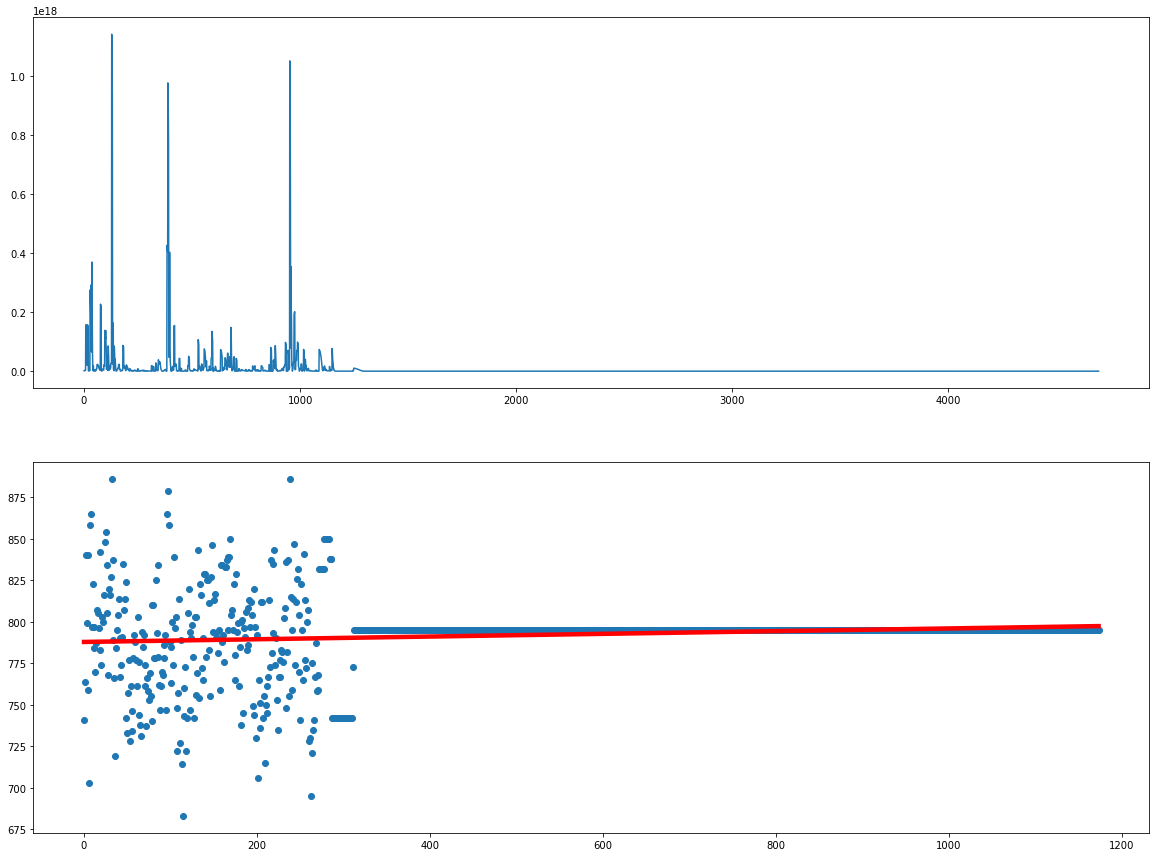

1
Epoch 1175: Current Learning Rate: [0.0004446121050670199, 0.006935948839045514, 0.0003556896840536168], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1200  is done!


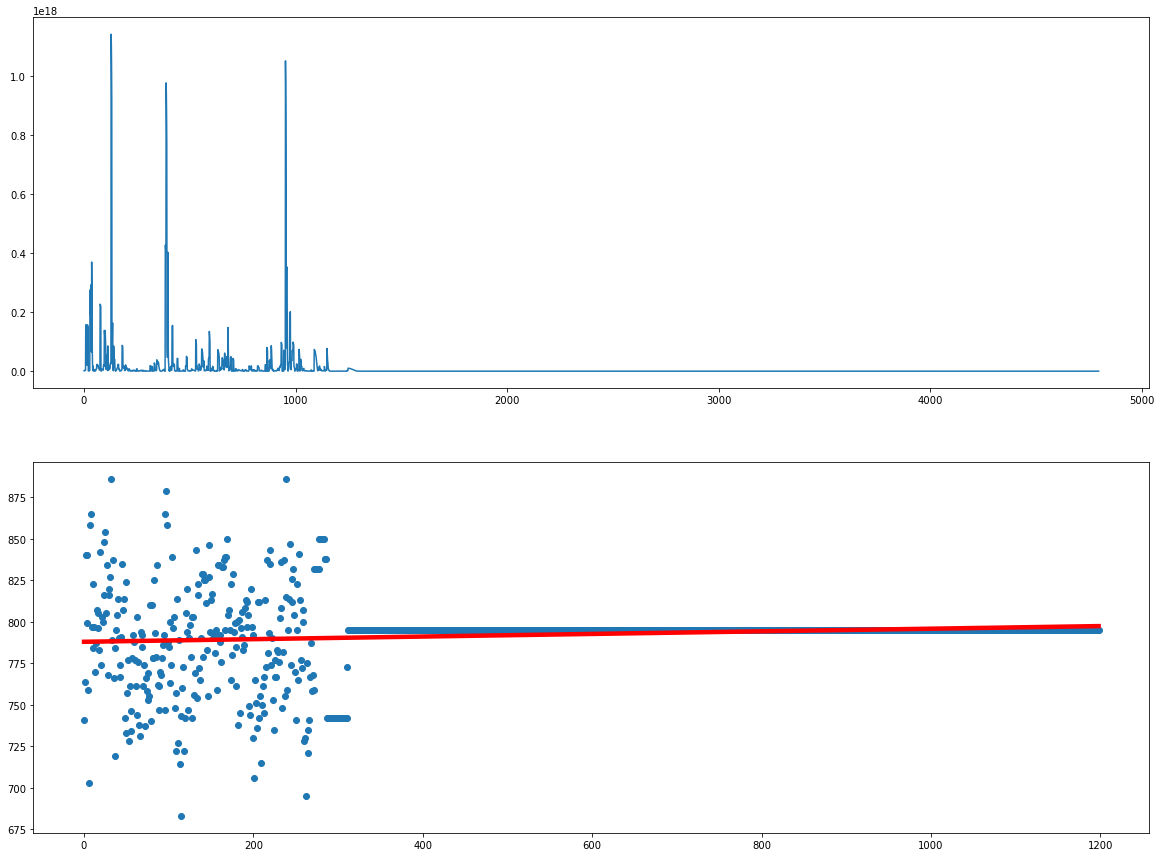

1
Epoch 1200: Current Learning Rate: [0.00044350190761862203, 0.0069186297588505075, 0.0003548015260948984], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1225  is done!


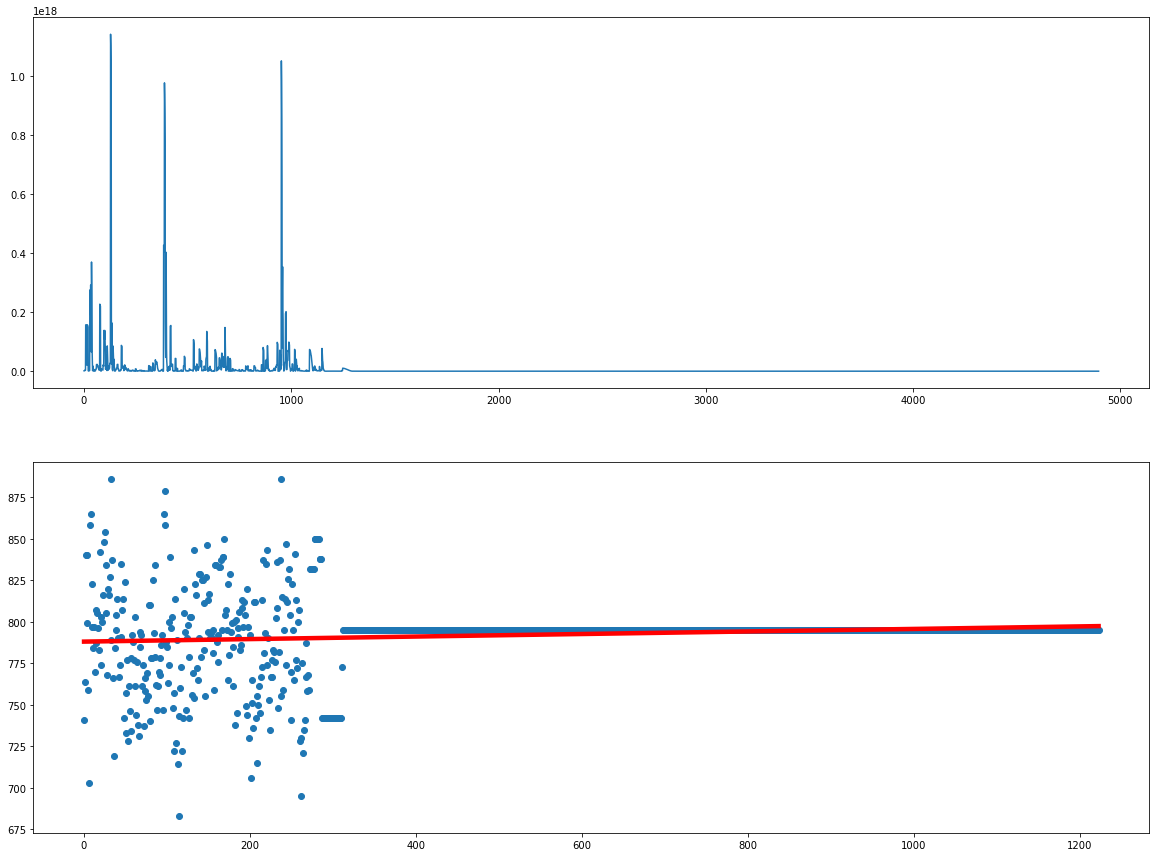

1
Epoch 1225: Current Learning Rate: [0.00044239448233580496, 0.00690135392443856, 0.00035391558586864467], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1250  is done!


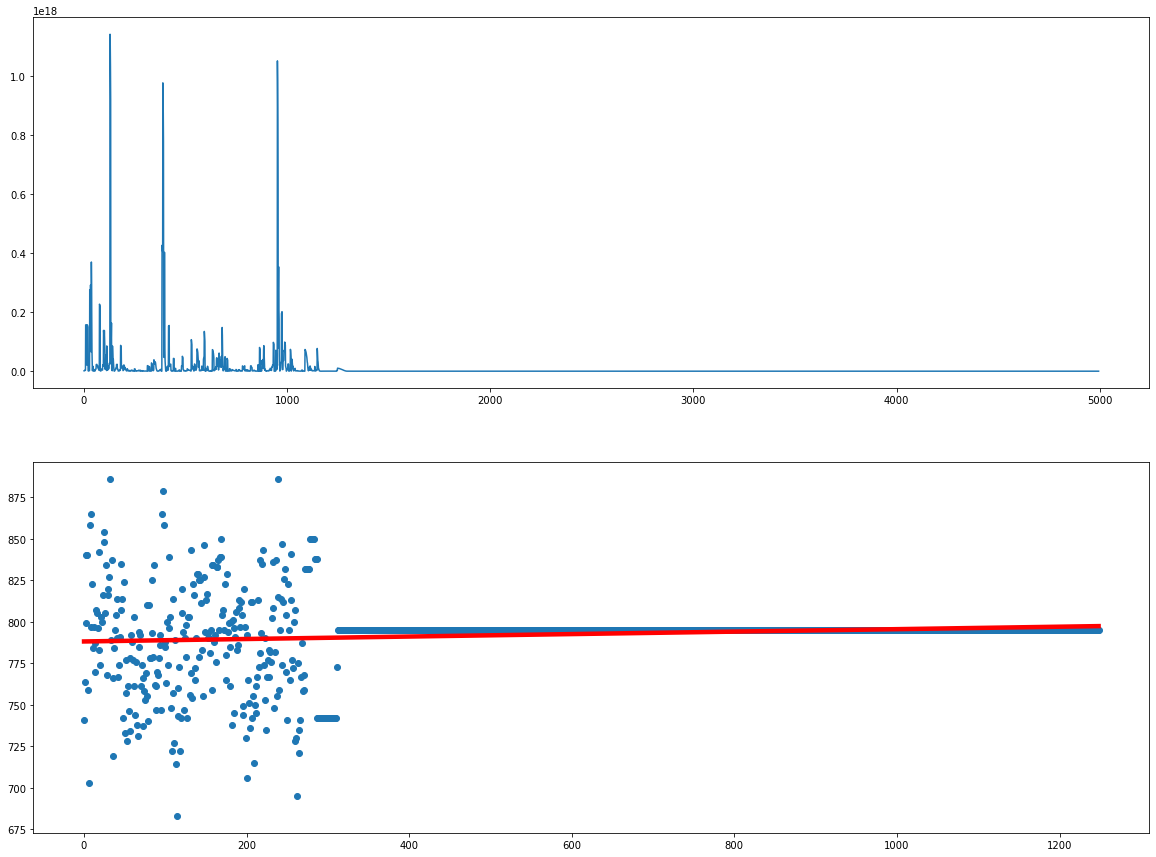

1
Epoch 1250: Current Learning Rate: [0.00044128982229646473, 0.006884121227824851, 0.00035303185783717235], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1275  is done!


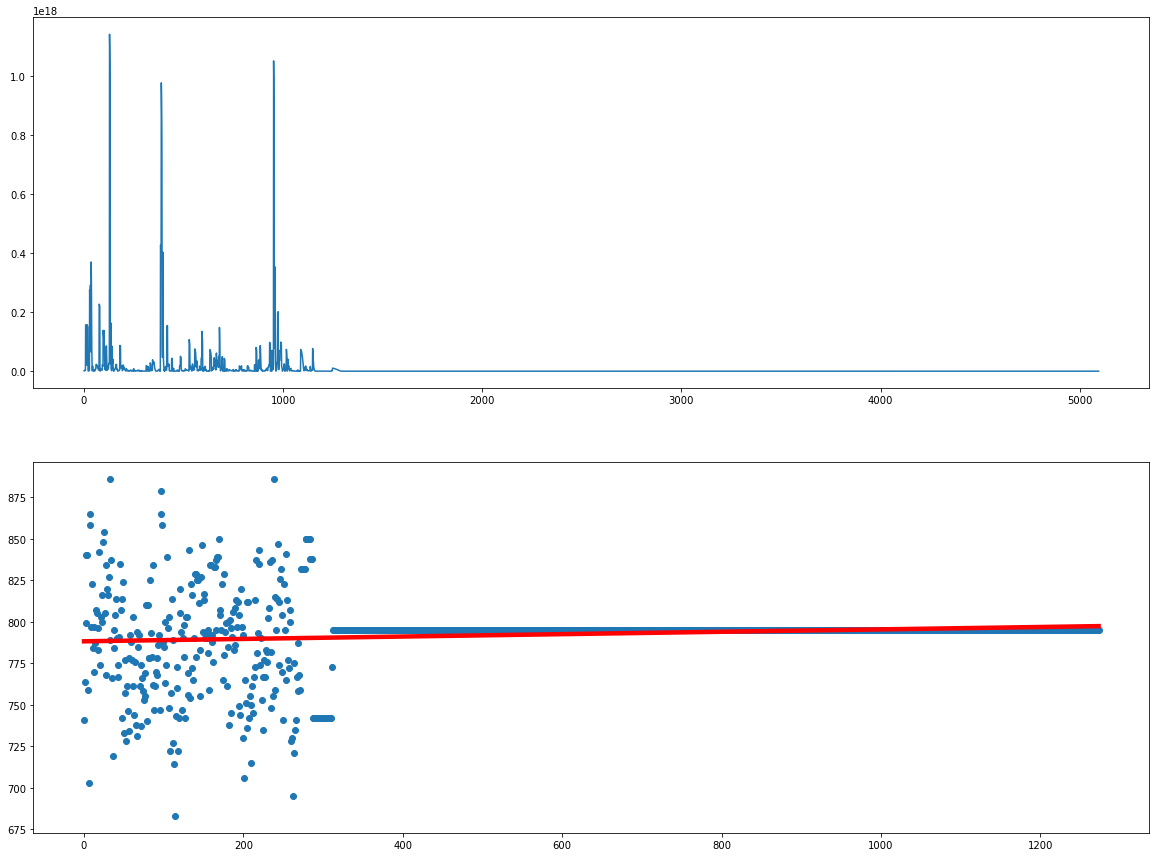

1
Epoch 1275: Current Learning Rate: [0.0004401879205957819, 0.006866931561294198, 0.00035215033647662615], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1300  is done!


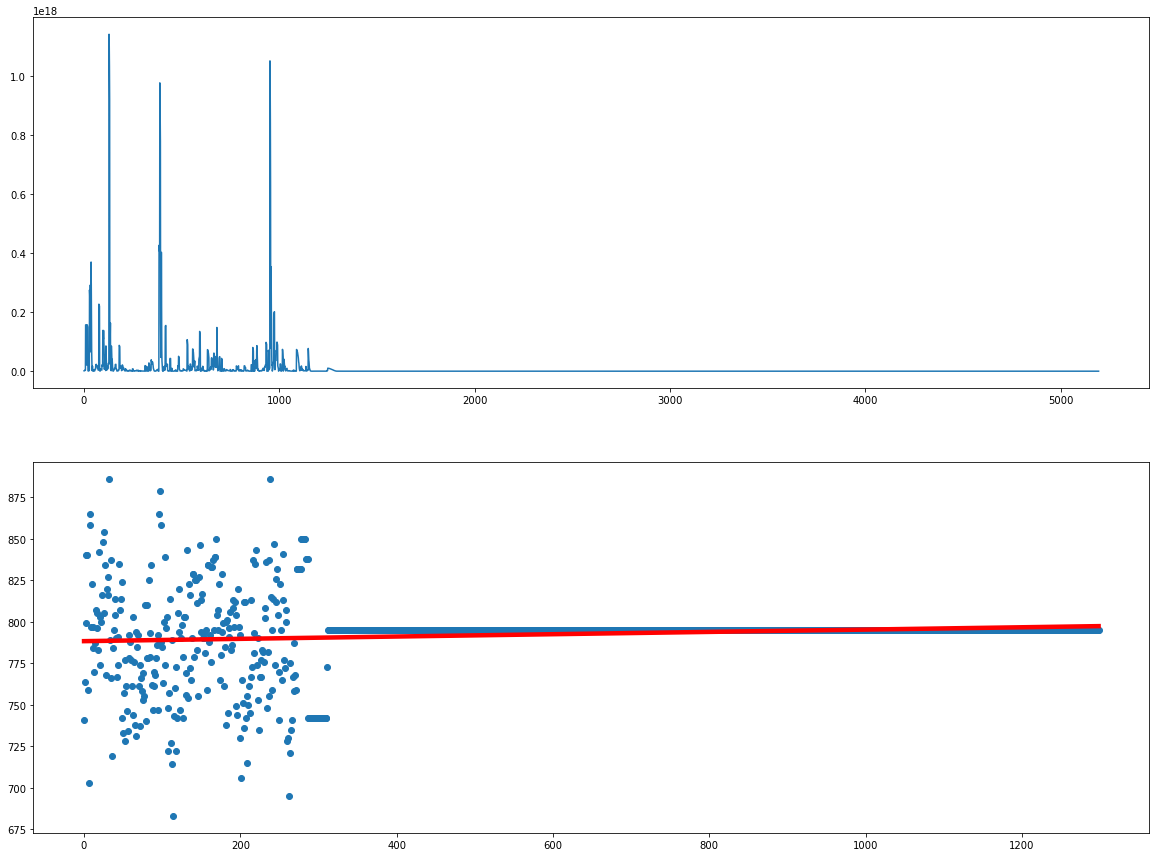

1
Epoch 1300: Current Learning Rate: [0.0004390887703461787, 0.00684978481740039, 0.00035127101627694356], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1325  is done!


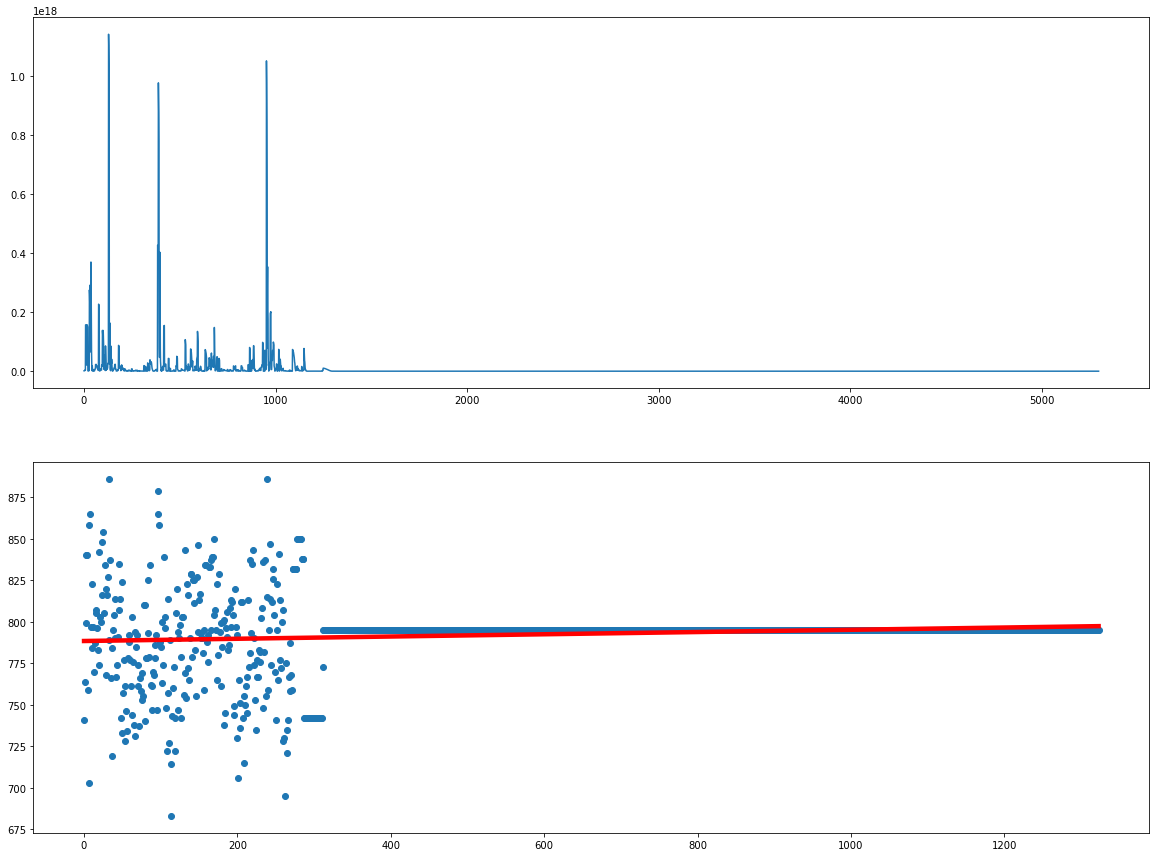

1
Epoch 1325: Current Learning Rate: [0.00043799236467727536, 0.006832680888965497, 0.00035039389174182107], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1350  is done!


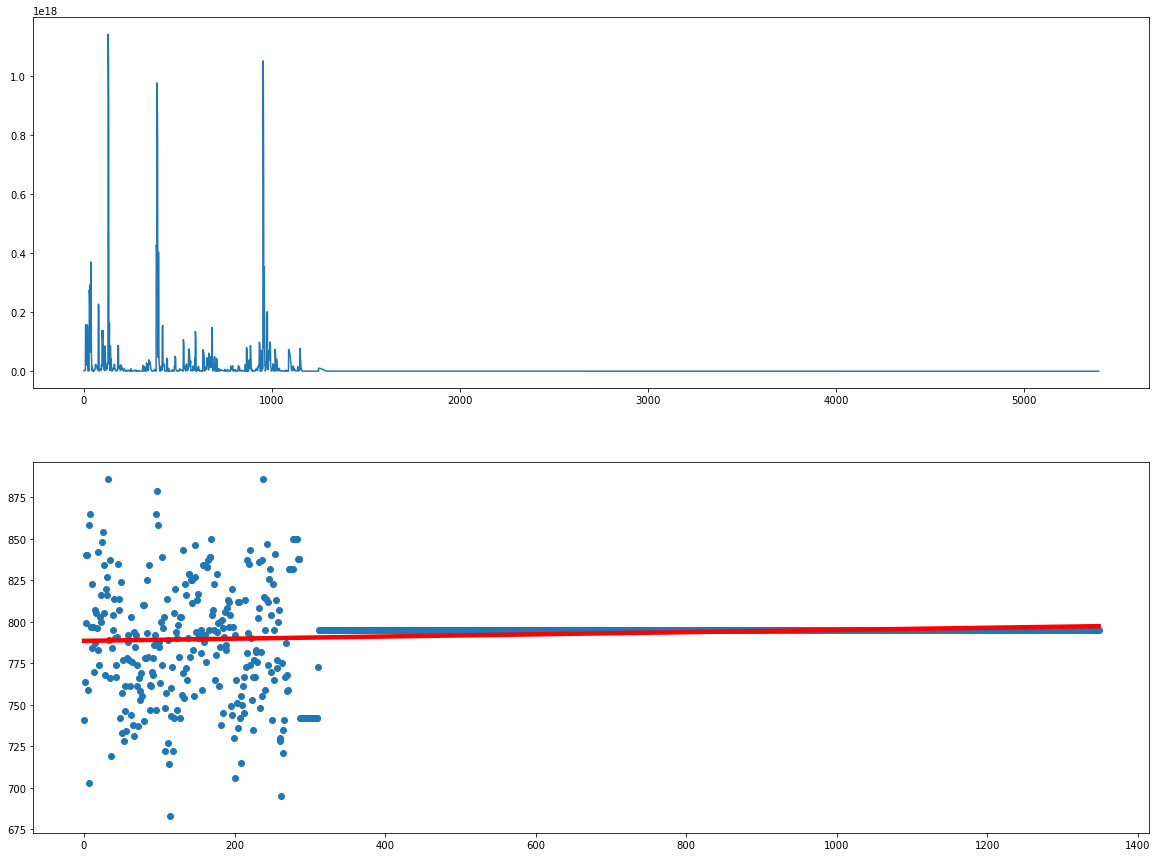

1
Epoch 1350: Current Learning Rate: [0.0004368986967358478, 0.006815619669079225, 0.00034951895738867897], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1375  is done!


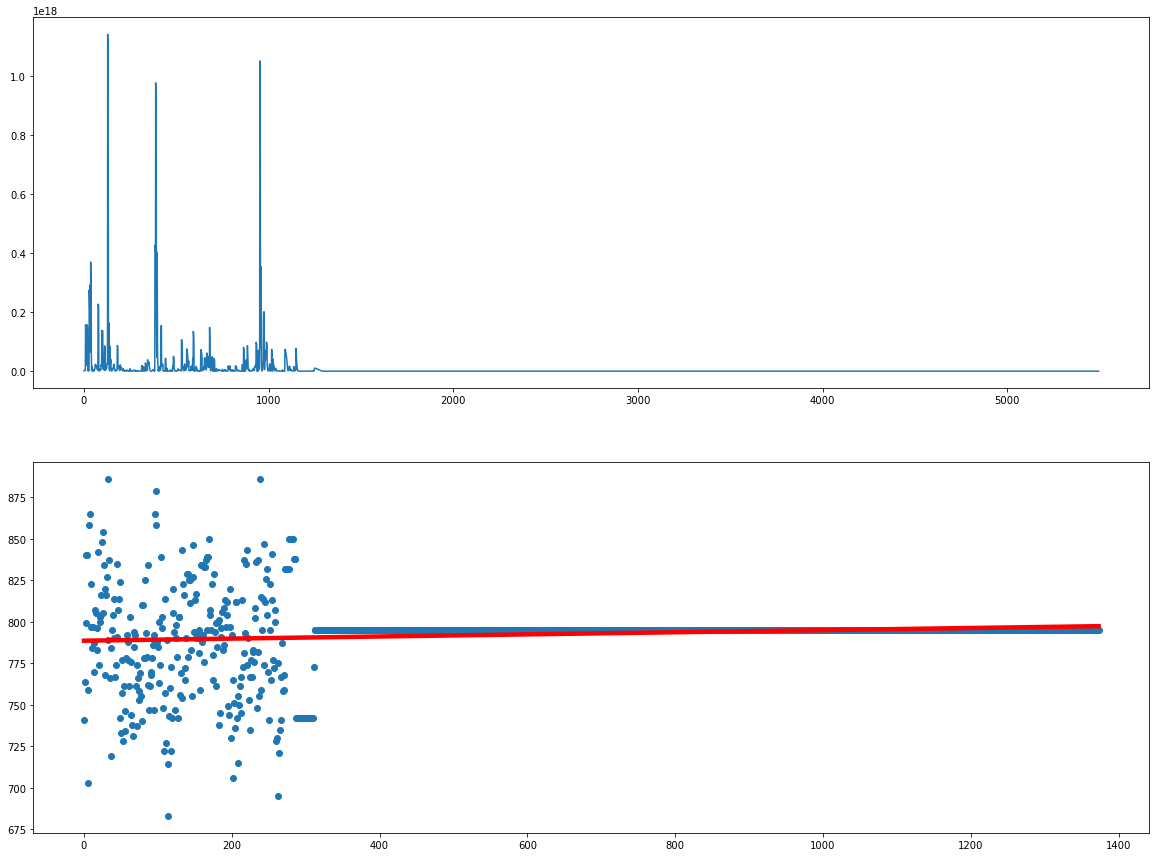

1
Epoch 1375: Current Learning Rate: [0.0004358077596857839, 0.006798601051098229, 0.00034864620774862796], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1400  is done!


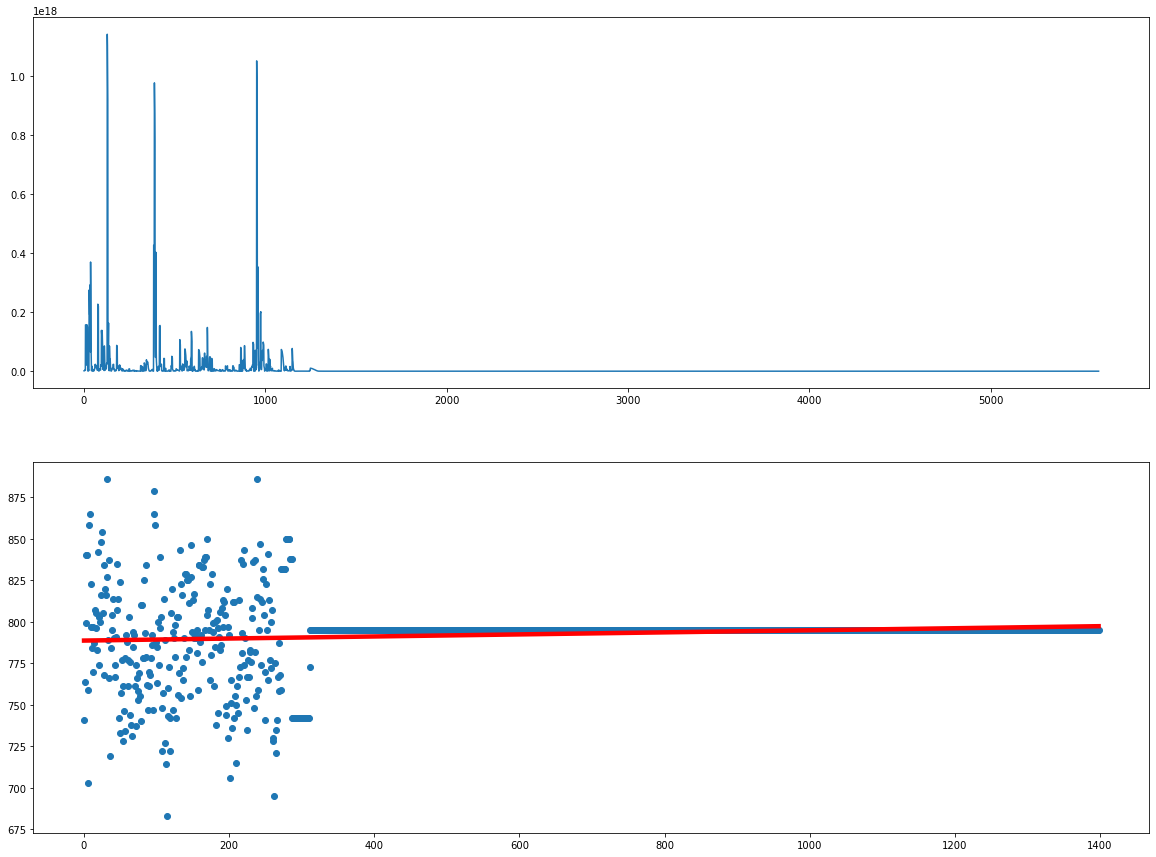

1
Epoch 1400: Current Learning Rate: [0.0004347195467080417, 0.006781624928645455, 0.00034777563736643424], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1425  is done!


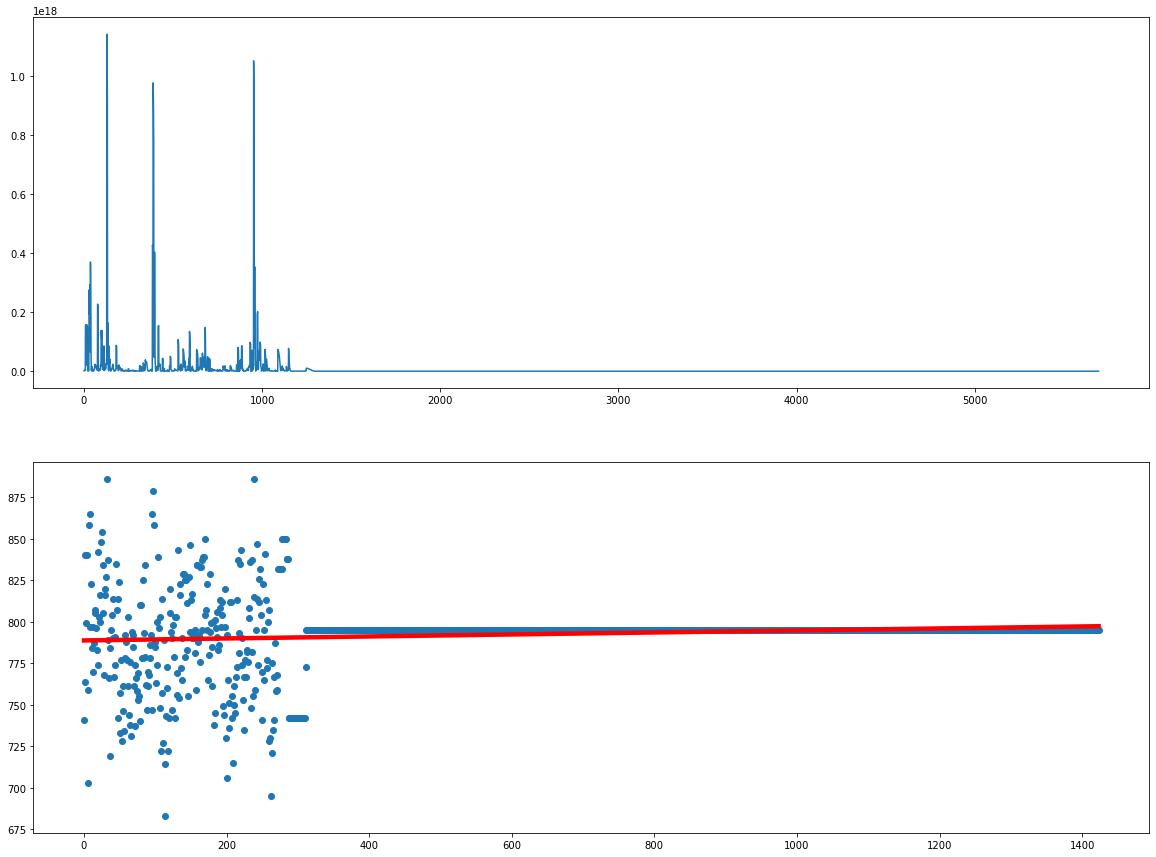

1
Epoch 1425: Current Learning Rate: [0.00043363405100060653, 0.006764691195609467, 0.0003469072408004861], Current Success Rate: 795


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1450  is done!


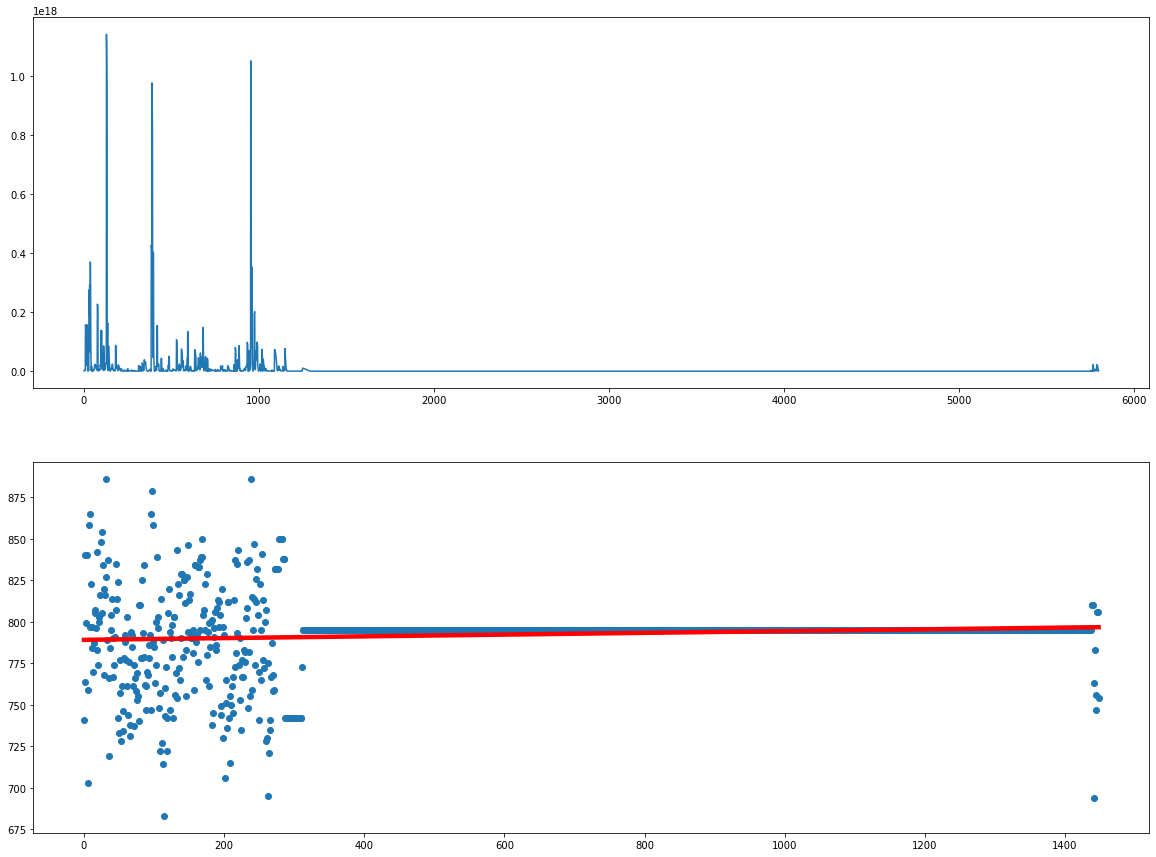

1
Epoch 1450: Current Learning Rate: [0.0004325512657784481, 0.006747799746143794, 0.0003460410126227594], Current Success Rate: 754


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1475  is done!


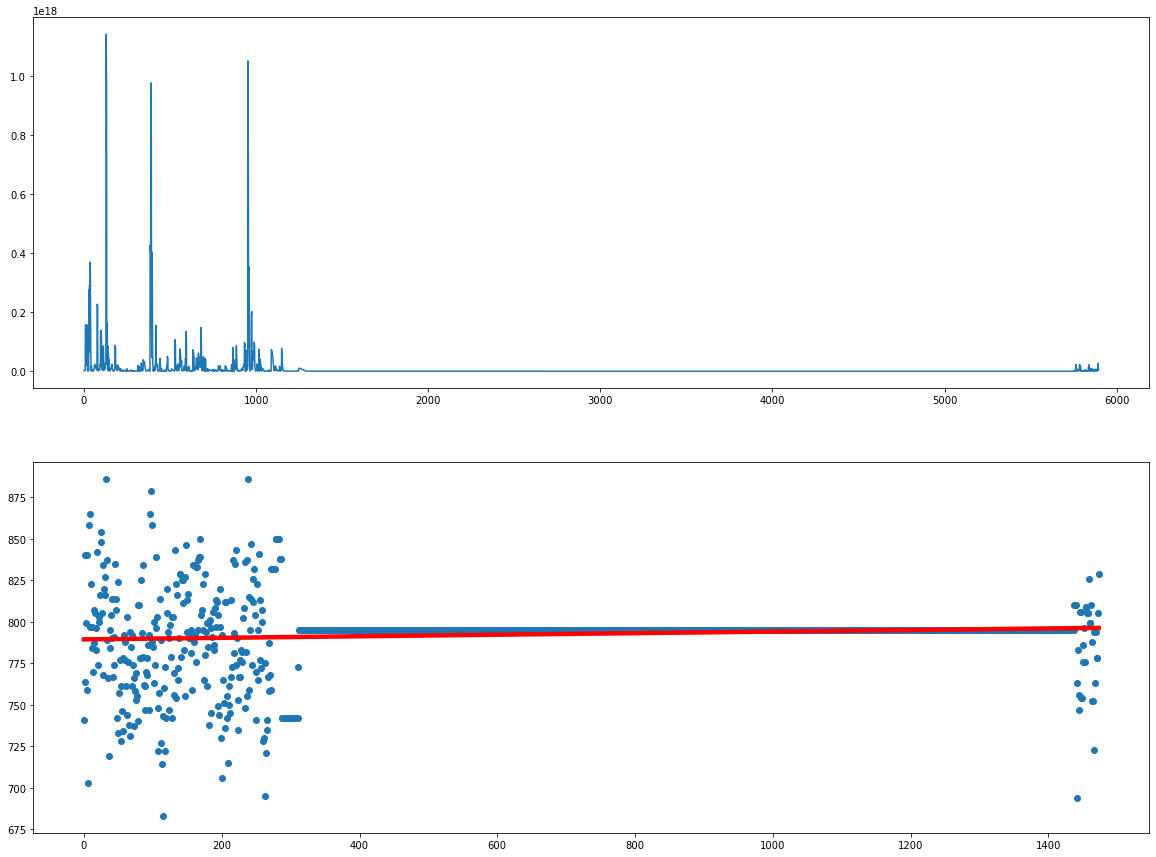

1
Epoch 1475: Current Learning Rate: [0.00043147118427347853, 0.006730950474666268, 0.00034517694741878377], Current Success Rate: 829


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1500  is done!


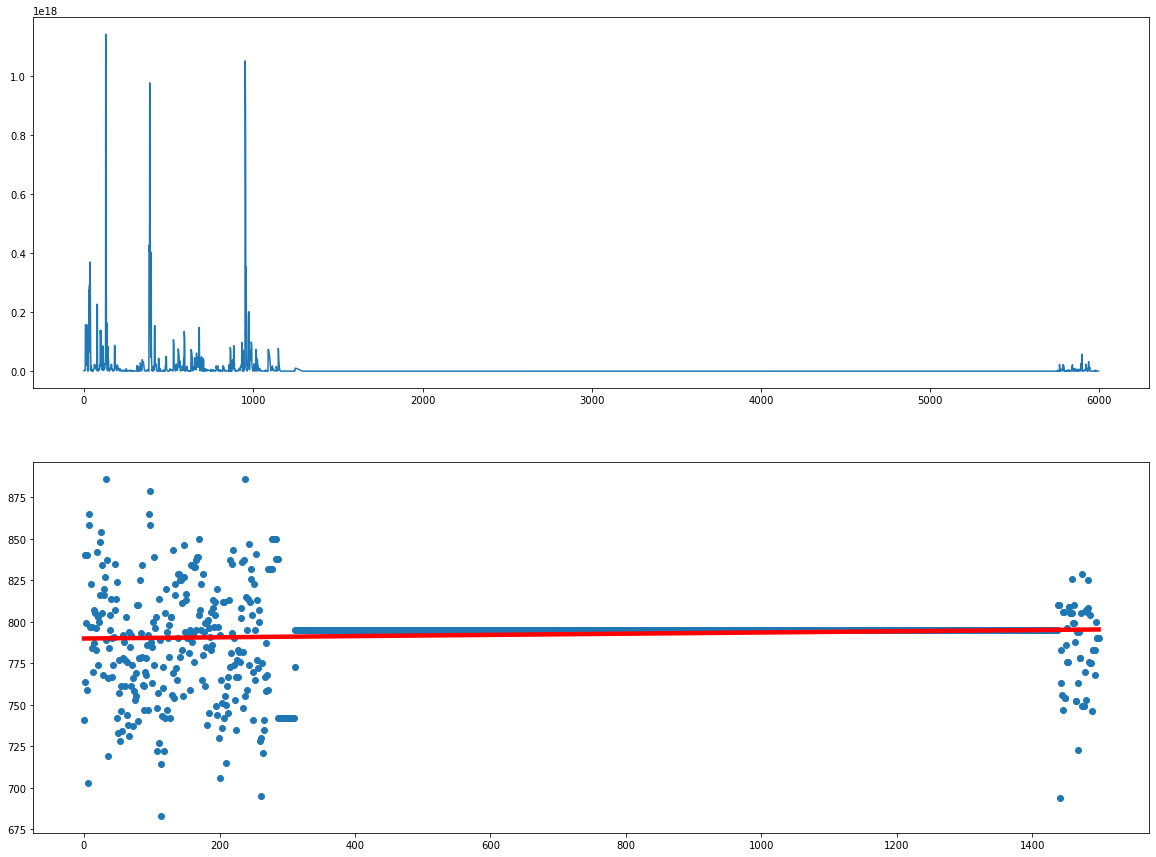

1
Epoch 1500: Current Learning Rate: [0.0004303937997345096, 0.006714143275858355, 0.0003443150397876087], Current Success Rate: 790


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1525  is done!


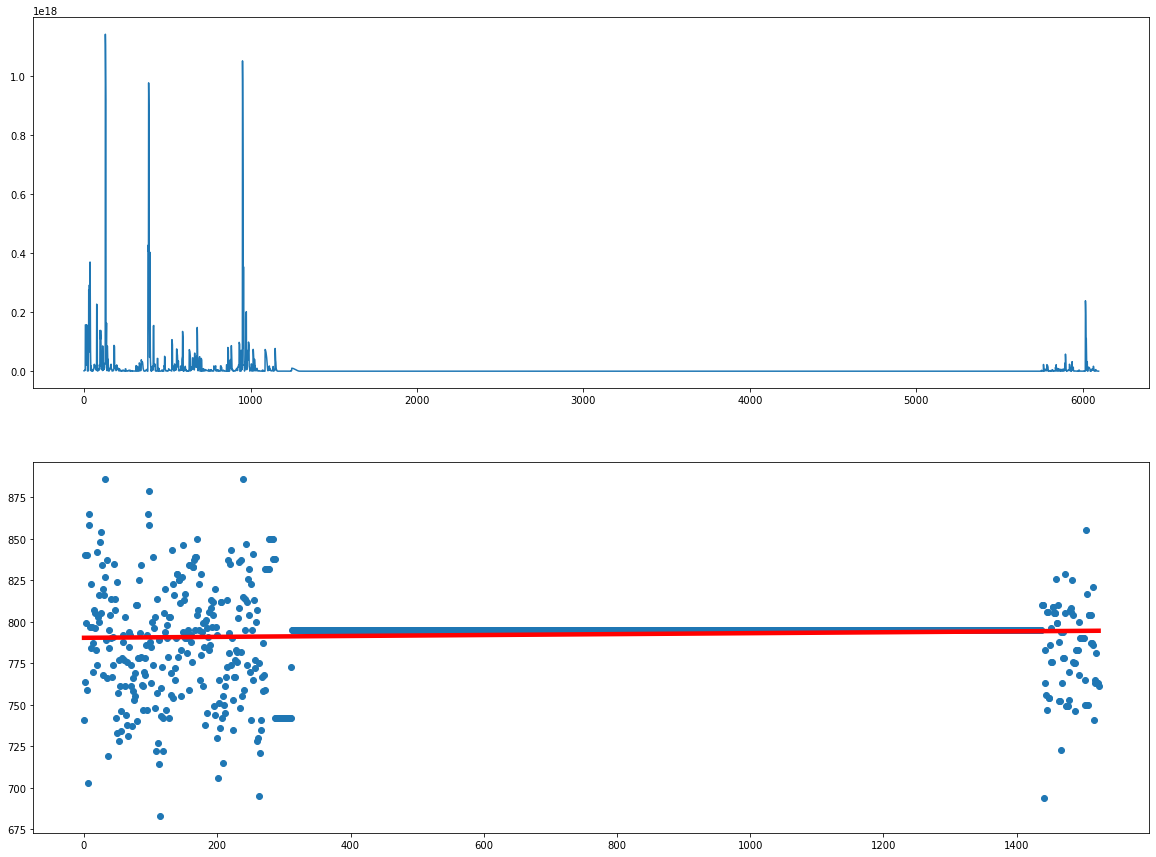

1
Epoch 1525: Current Learning Rate: [0.00042931910542721123, 0.006697378044664499, 0.00034345528434176974], Current Success Rate: 761


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1550  is done!


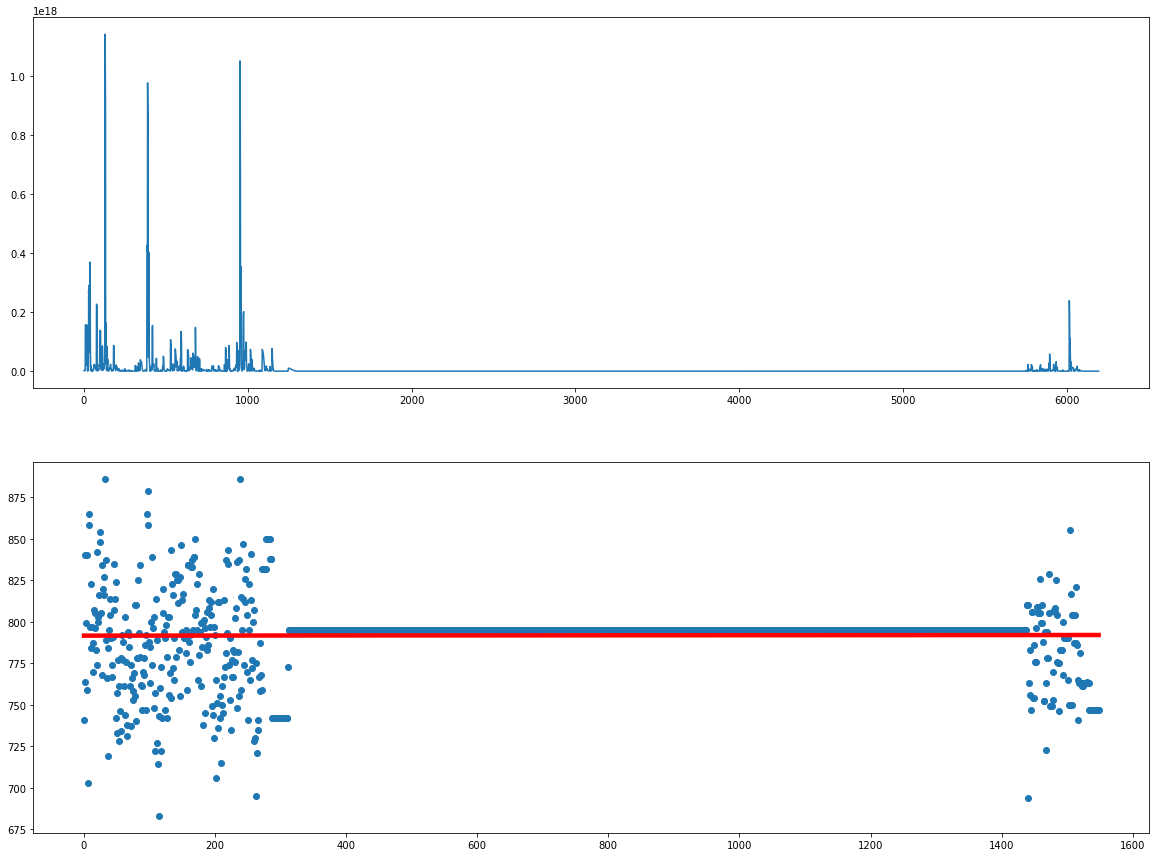

1
Epoch 1550: Current Learning Rate: [0.0004282470946340686, 0.006680654676291473, 0.0003425976757072556], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1575  is done!


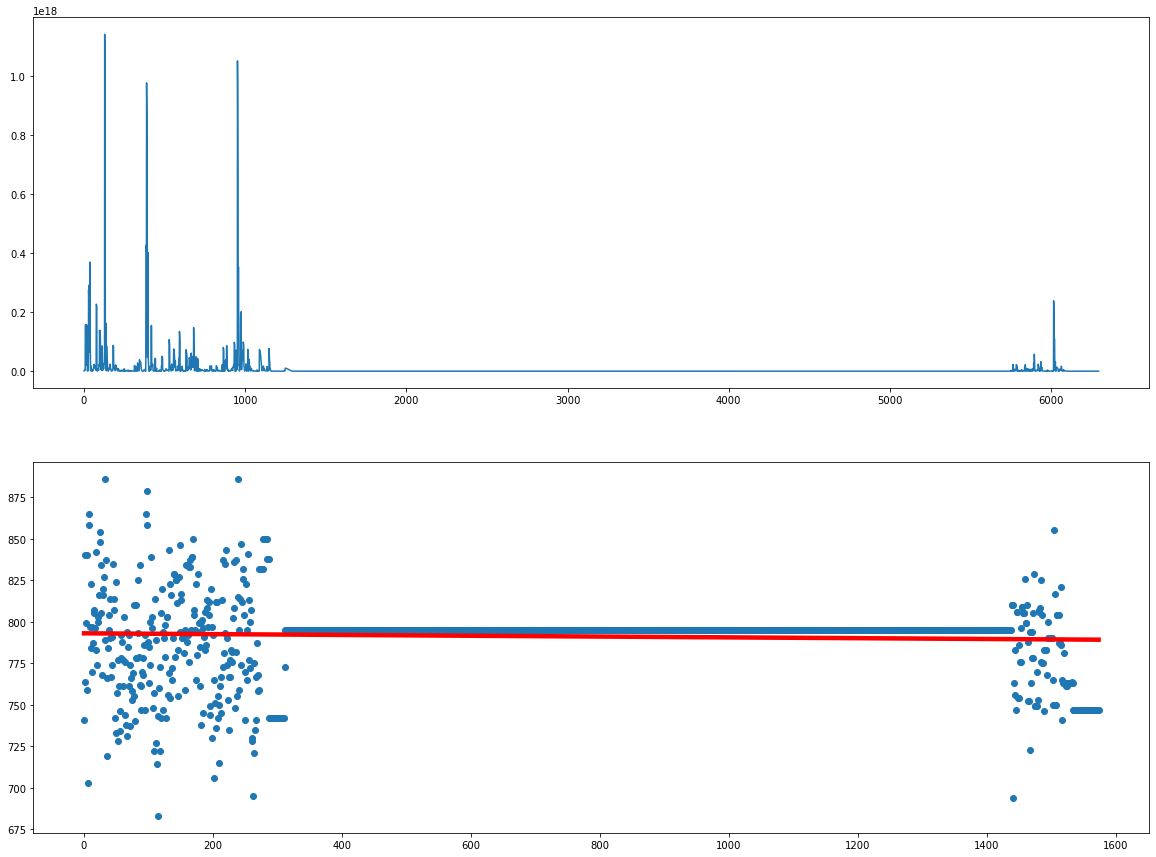

1
Epoch 1575: Current Learning Rate: [0.00042717776065434067, 0.006663973066207718, 0.0003417422085234733], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1600  is done!


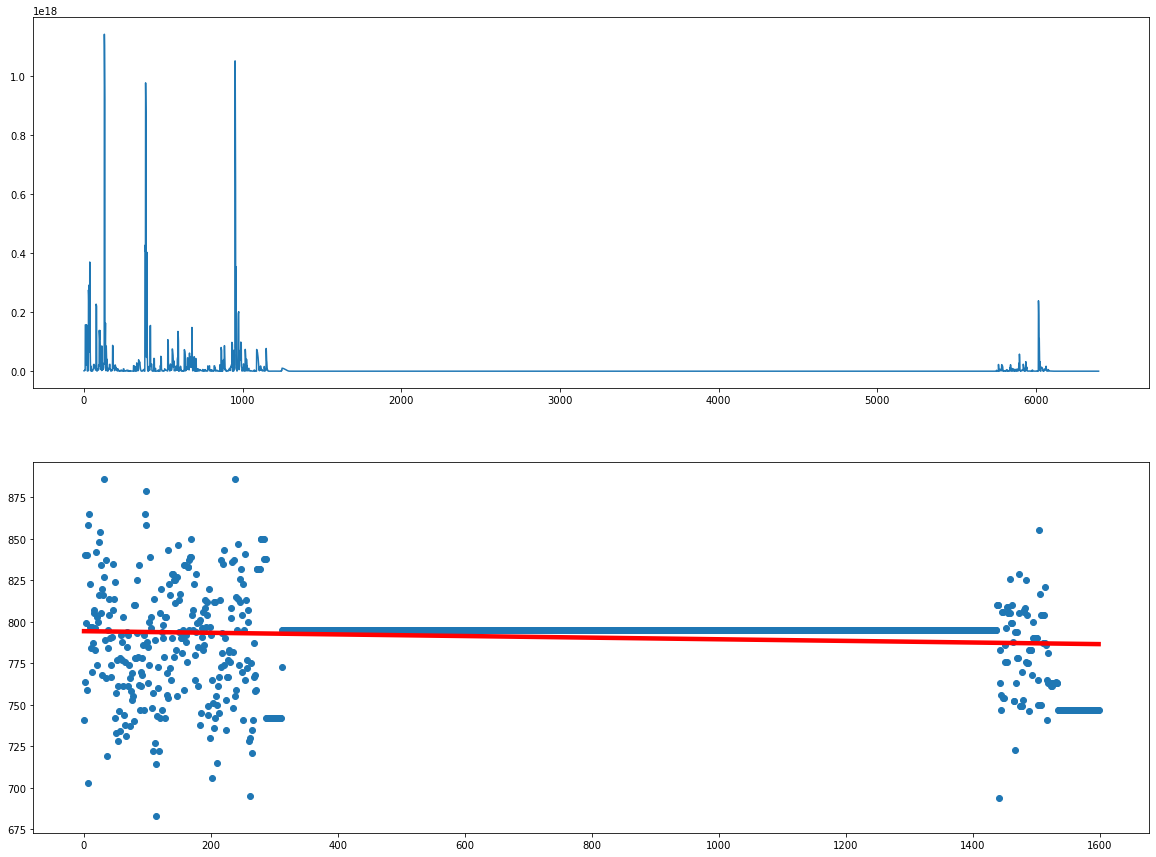

1
Epoch 1600: Current Learning Rate: [0.00042611109680401816, 0.00664733311014269, 0.00034088887744321533], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1625  is done!


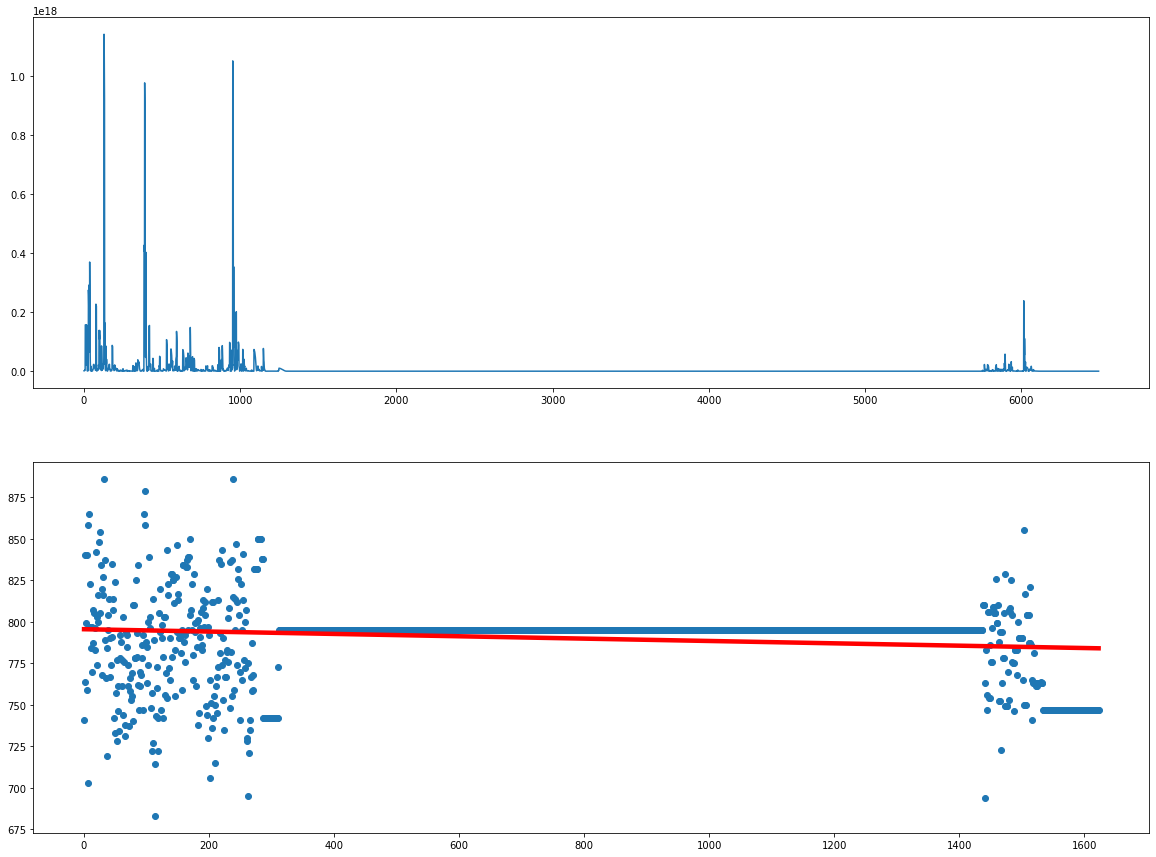

1
Epoch 1625: Current Learning Rate: [0.0004250470964157819, 0.006630734704086205, 0.00034003767713262646], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1650  is done!


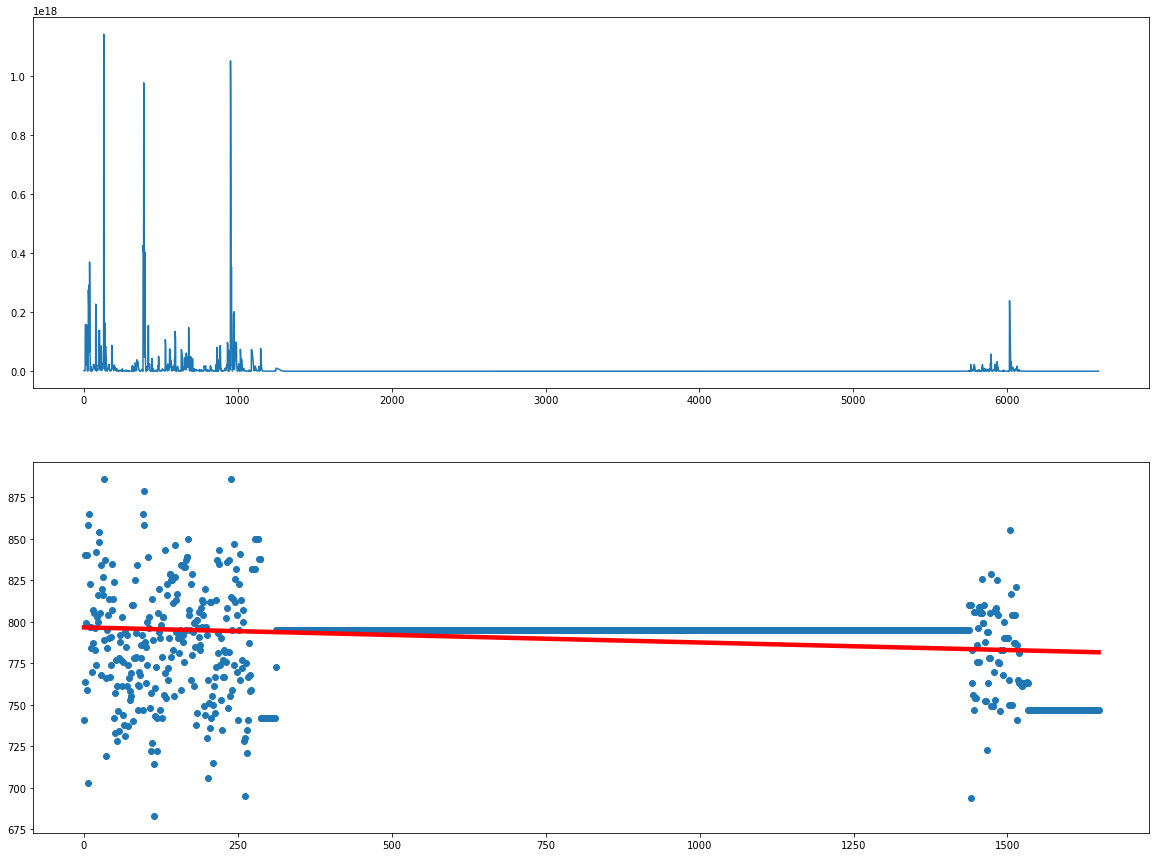

1
Epoch 1650: Current Learning Rate: [0.0004239857528389609, 0.006614177744287799, 0.00033918860227116976], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1675  is done!


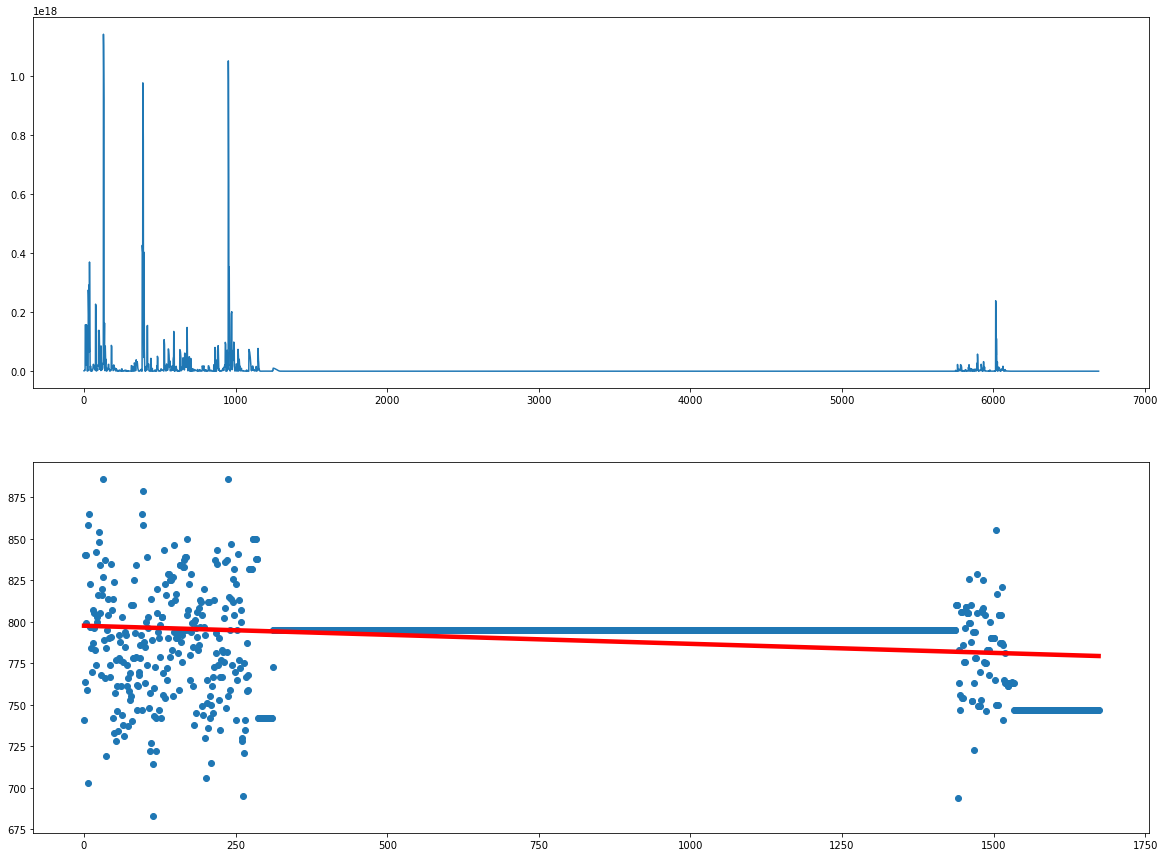

1
Epoch 1675: Current Learning Rate: [0.00042292705943949095, 0.0065976621272560675, 0.0003383416475515938], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1700  is done!


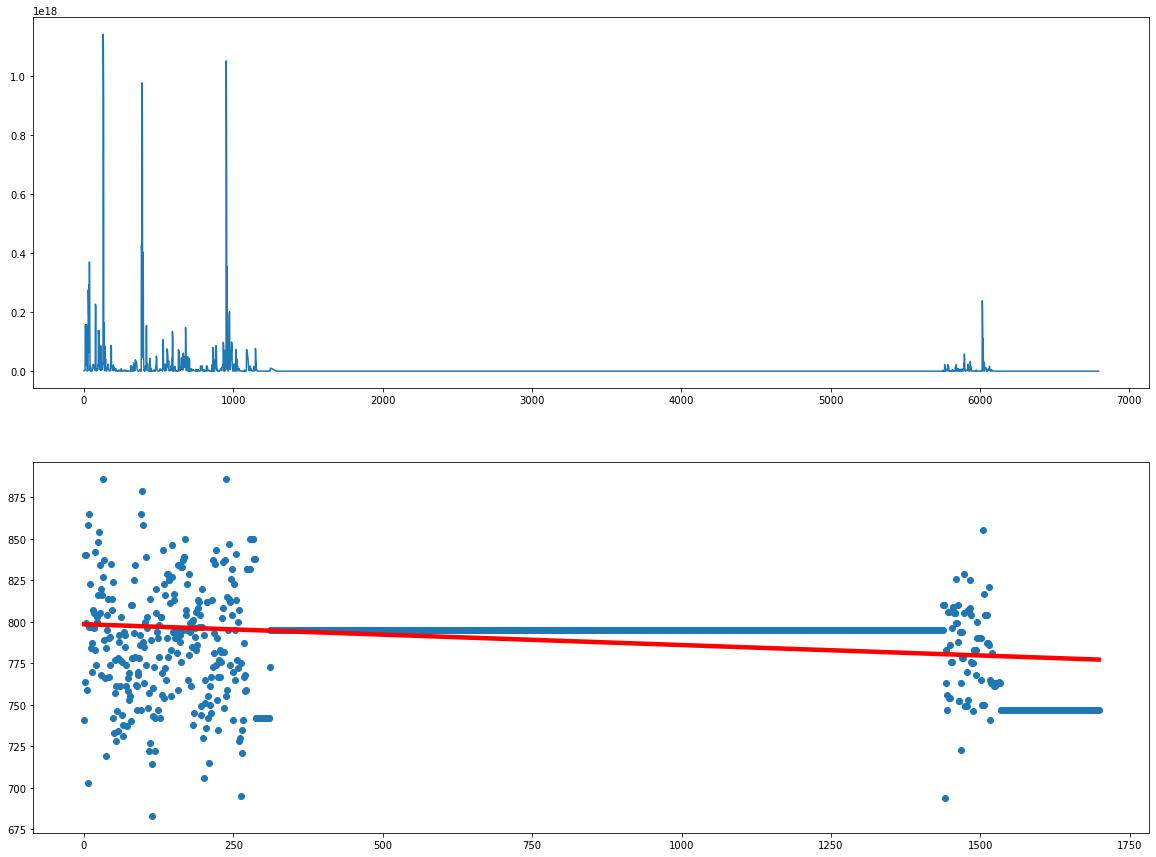

1
Epoch 1700: Current Learning Rate: [0.00042187100959987324, 0.006581187749758032, 0.0003374968076798995], Current Success Rate: 747


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1725  is done!


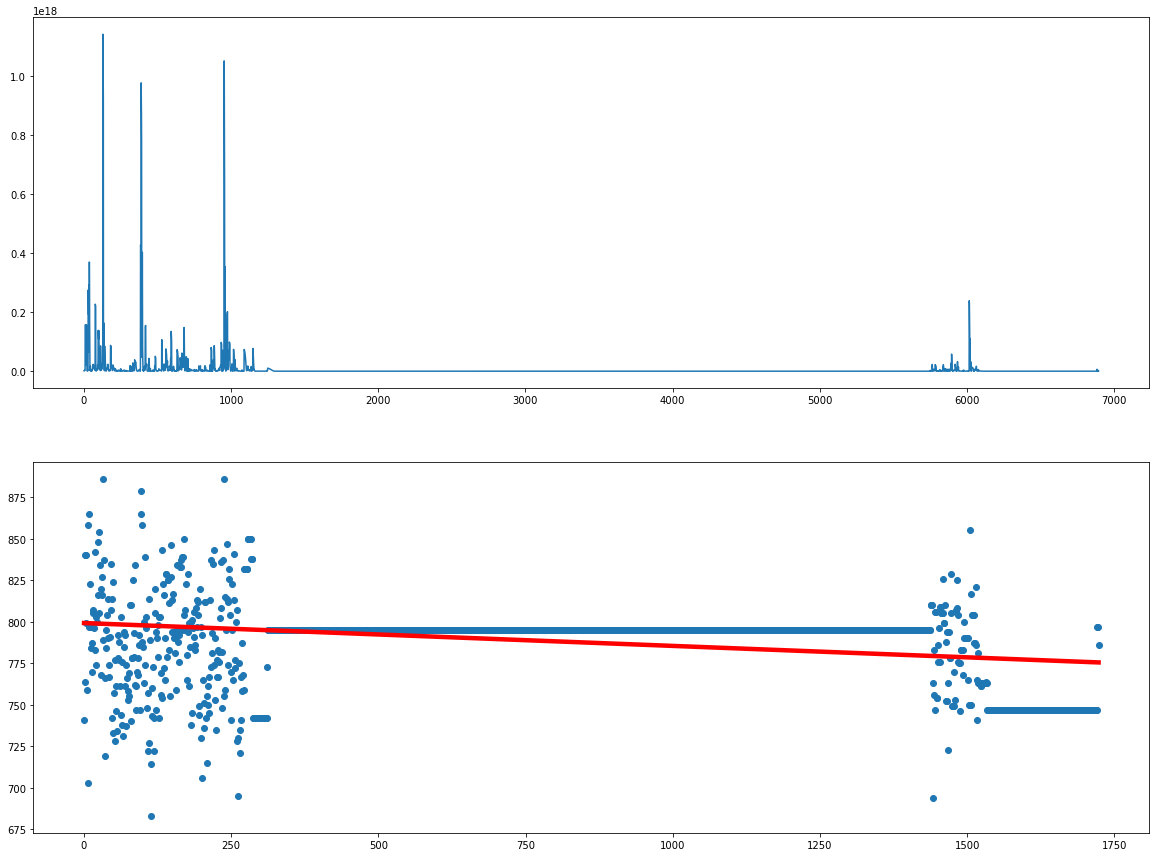

1
Epoch 1725: Current Learning Rate: [0.0004208175967191327, 0.006564754508818478, 0.00033665407737530693], Current Success Rate: 786


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1750  is done!


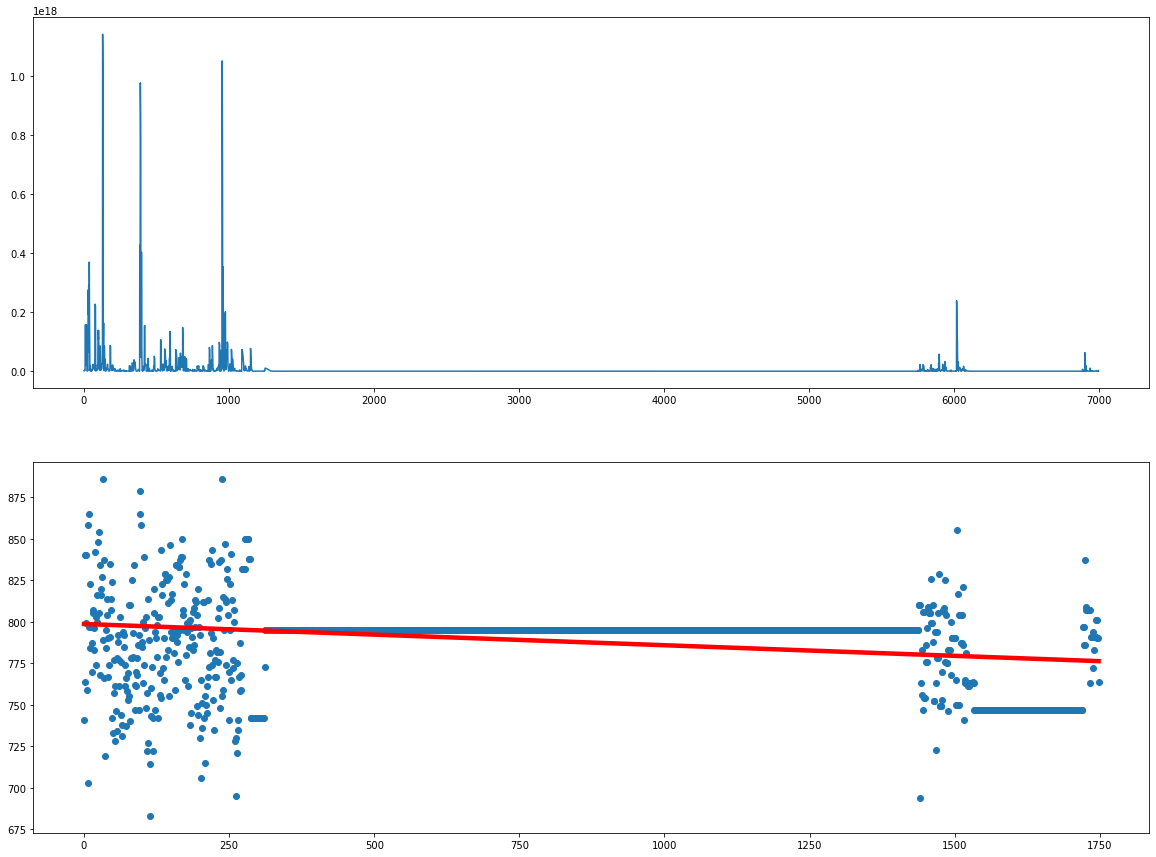

1
Epoch 1750: Current Learning Rate: [0.00041976681421277676, 0.006548362301719325, 0.0003358134513702222], Current Success Rate: 764


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1775  is done!


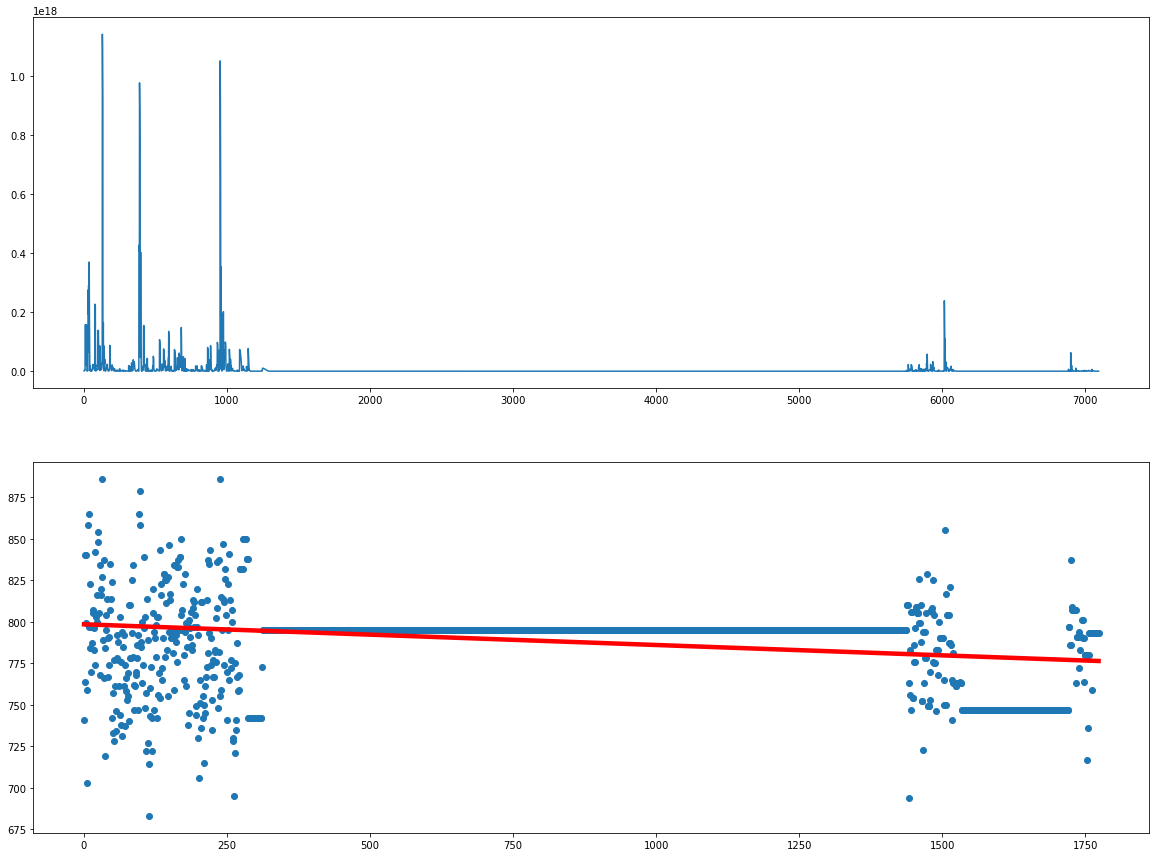

1
Epoch 1775: Current Learning Rate: [0.0004187186555127547, 0.00653201102599898, 0.0003349749244102046], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1800  is done!


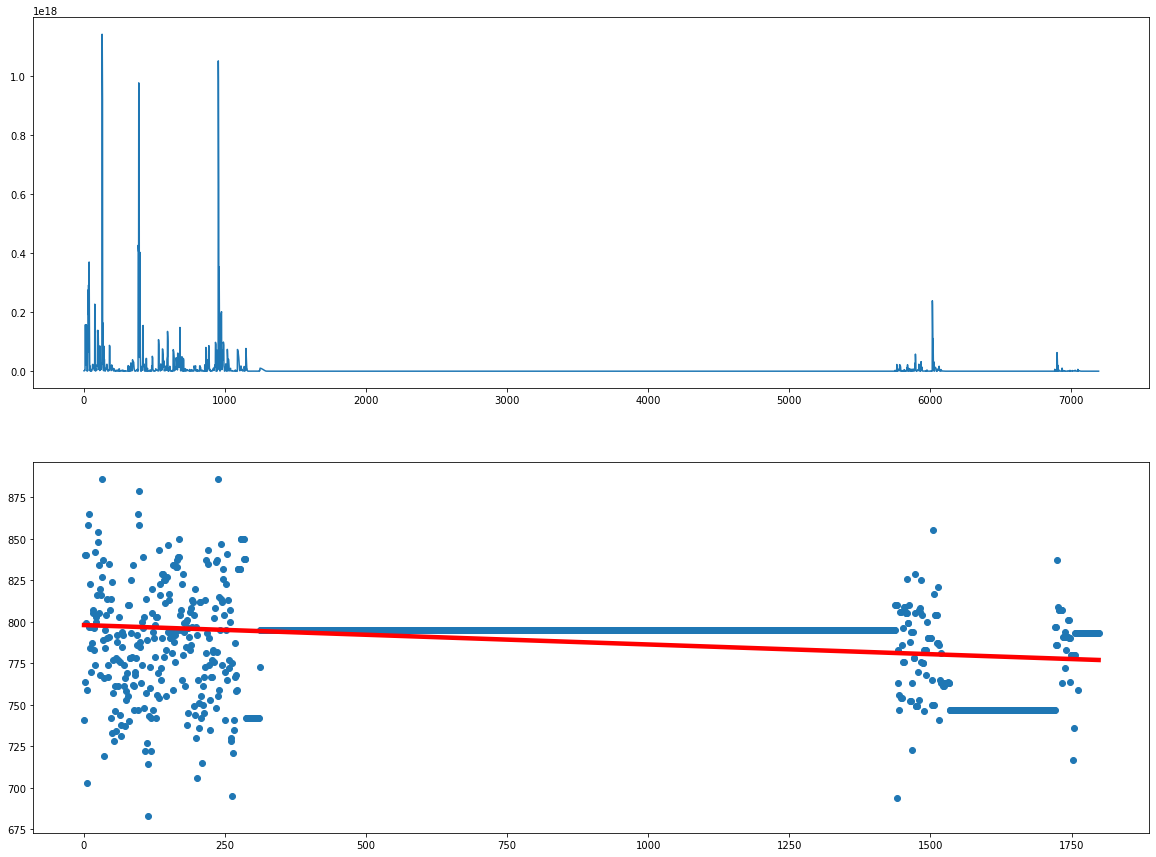

1
Epoch 1800: Current Learning Rate: [0.0004176731140674159, 0.006515700579451698, 0.00033413849125393385], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1825  is done!


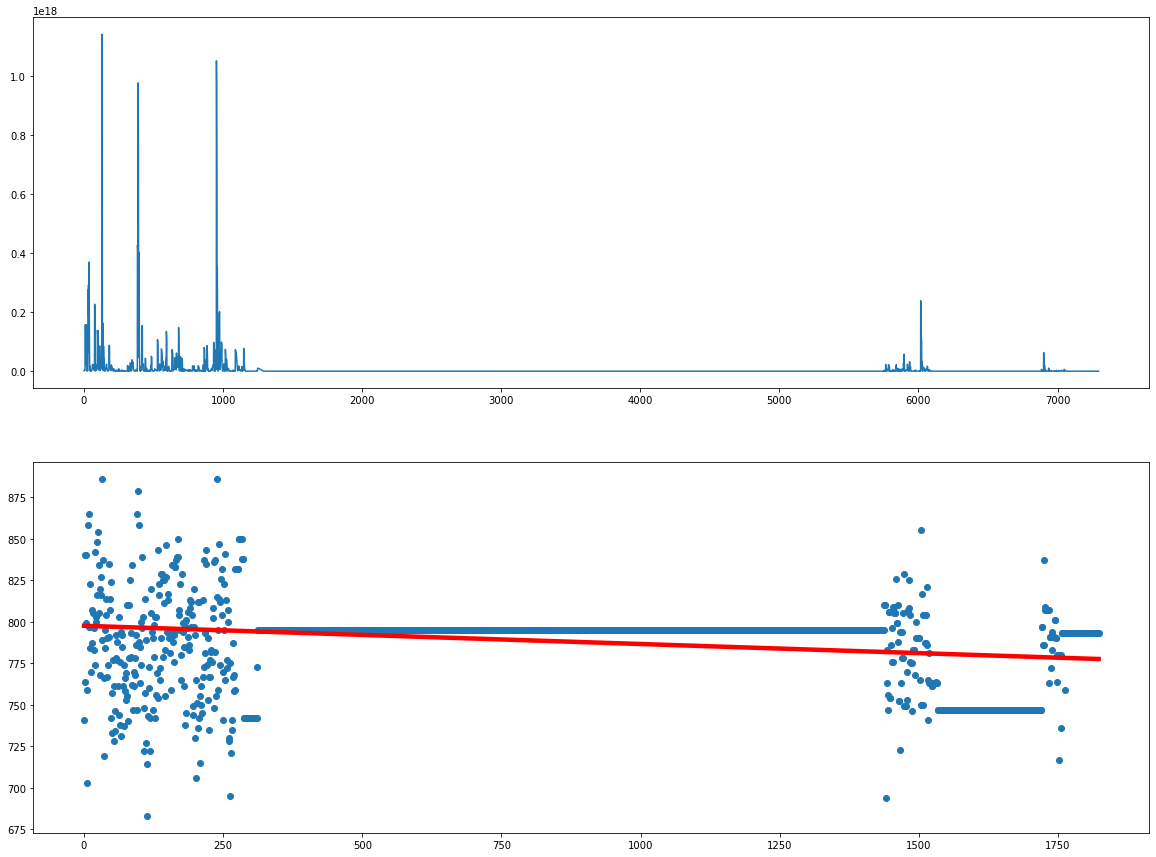

1
Epoch 1825: Current Learning Rate: [0.00041663018334146964, 0.0064994308601269354, 0.000333304146673177], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1850  is done!


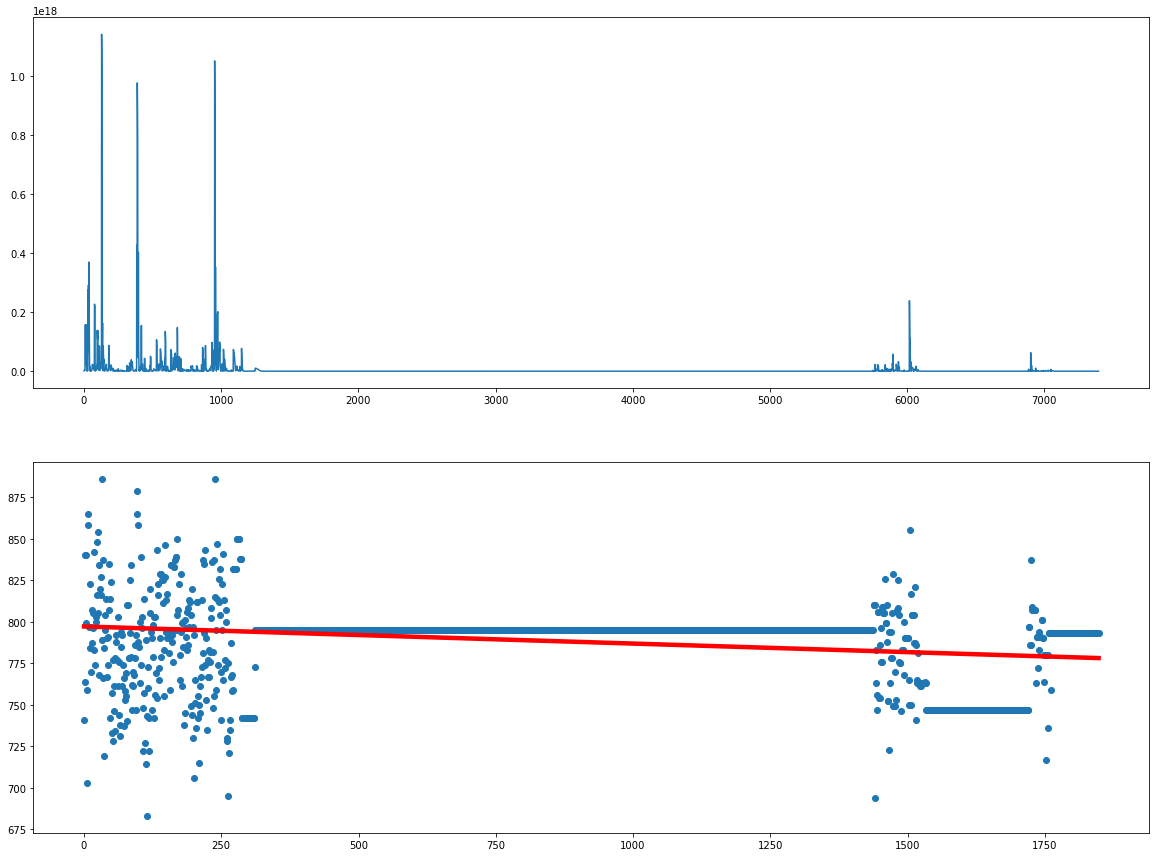

1
Epoch 1850: Current Learning Rate: [0.0004155898568159434, 0.006483201766328728, 0.0003324718854527561], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1875  is done!


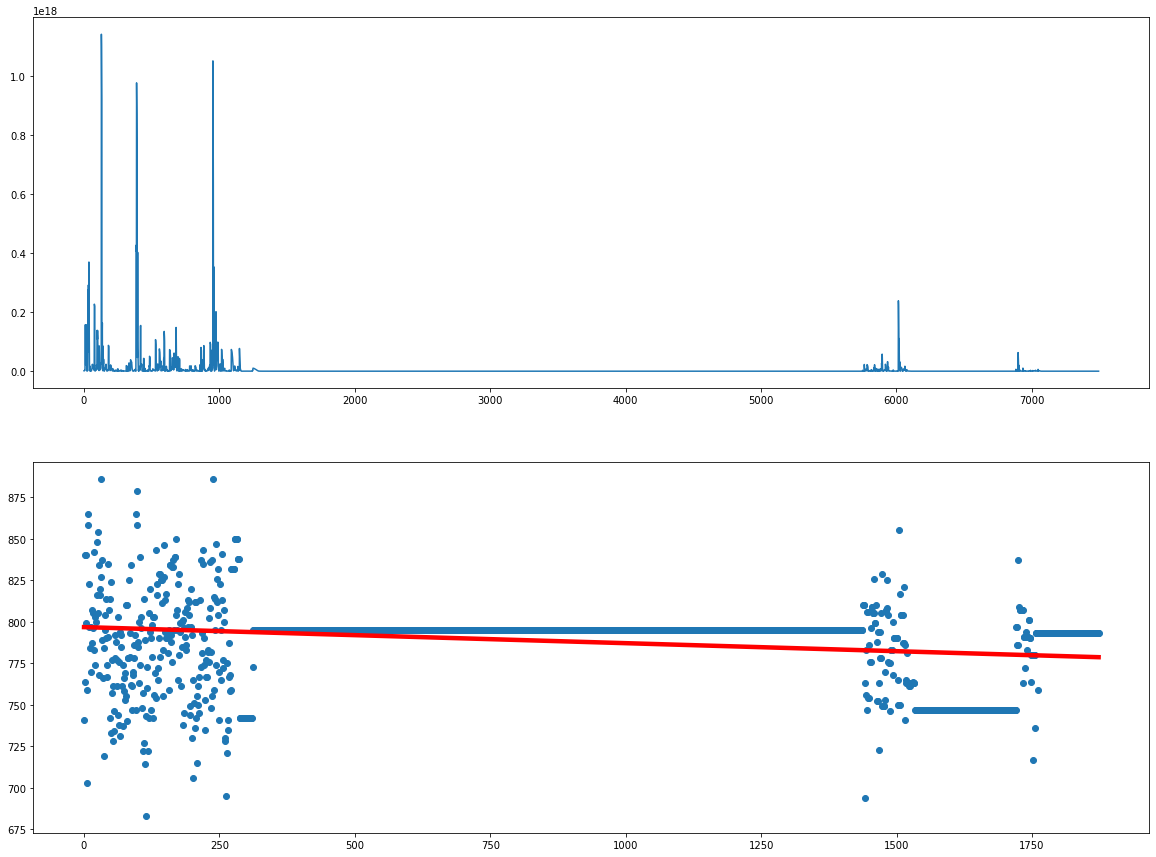

1
Epoch 1875: Current Learning Rate: [0.000414552127988143, 0.006467013196615041, 0.0003316417023905159], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1900  is done!


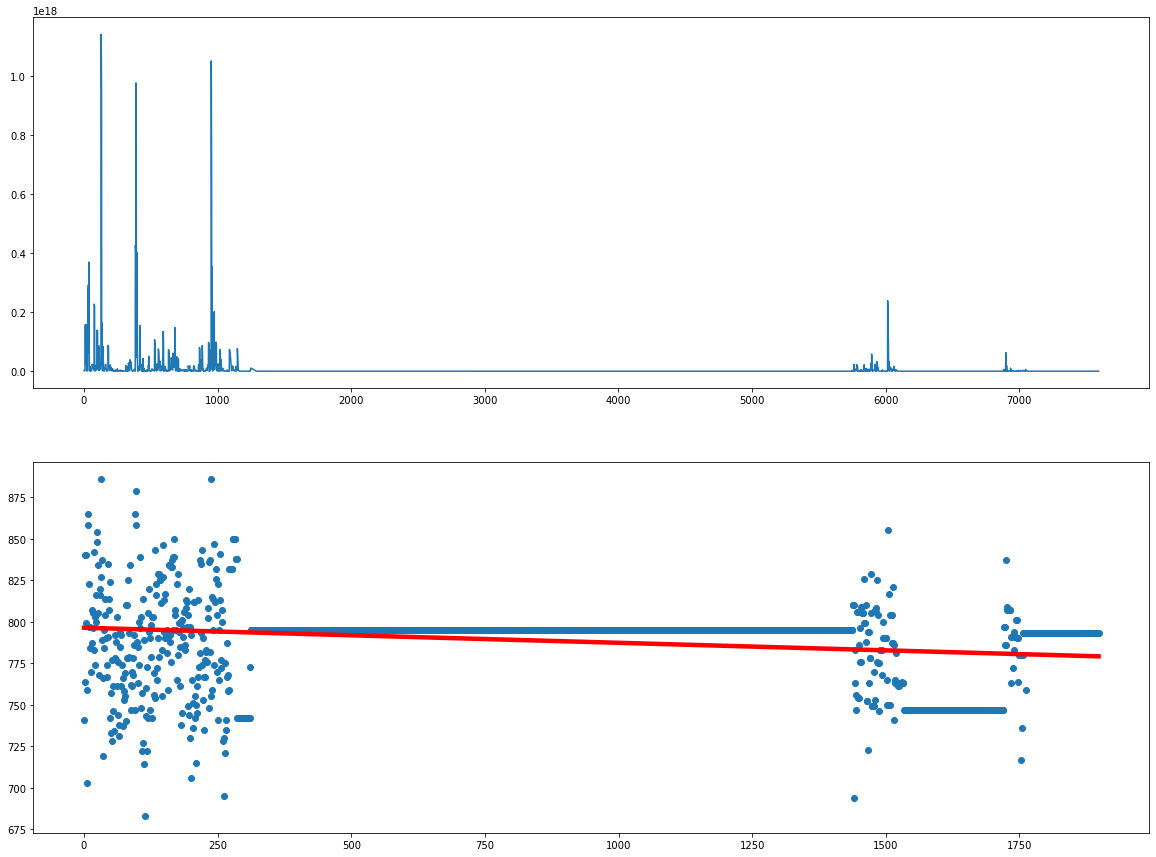

1
Epoch 1900: Current Learning Rate: [0.00041351699037161095, 0.006450865049797143, 0.0003308135922972902], Current Success Rate: 793


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1925  is done!


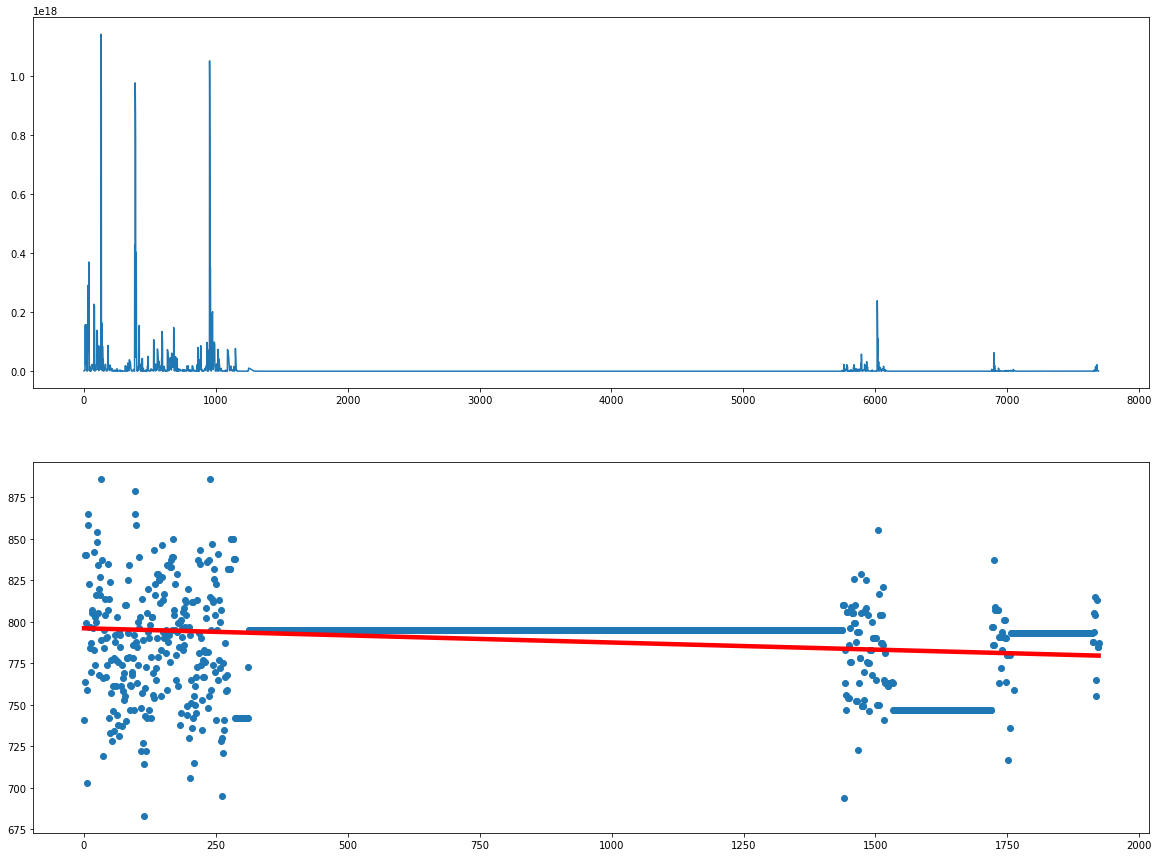

1
Epoch 1925: Current Learning Rate: [0.0004124844374960869, 0.0064347572249389695, 0.00032998754999687103], Current Success Rate: 787


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1950  is done!


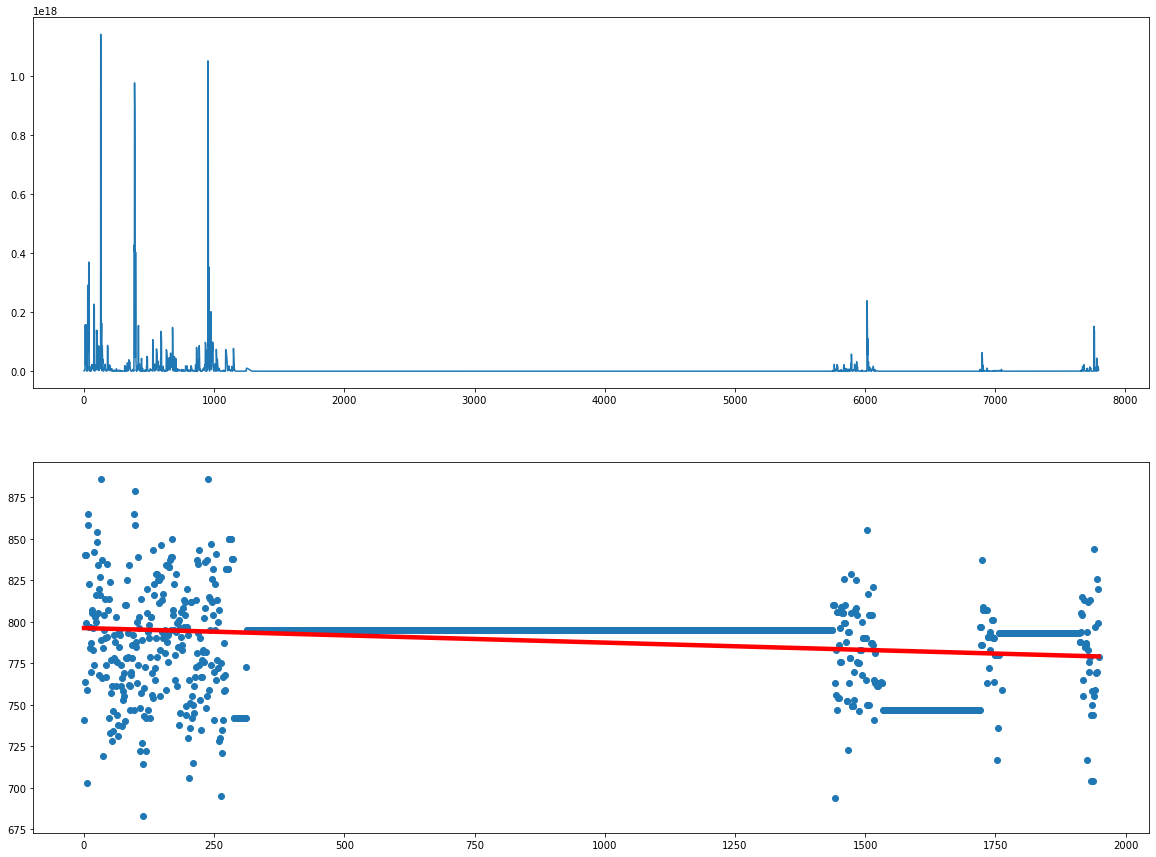

1
Epoch 1950: Current Learning Rate: [0.00041145446290746665, 0.006418689621356491, 0.0003291635703259748], Current Success Rate: 779


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1975  is done!


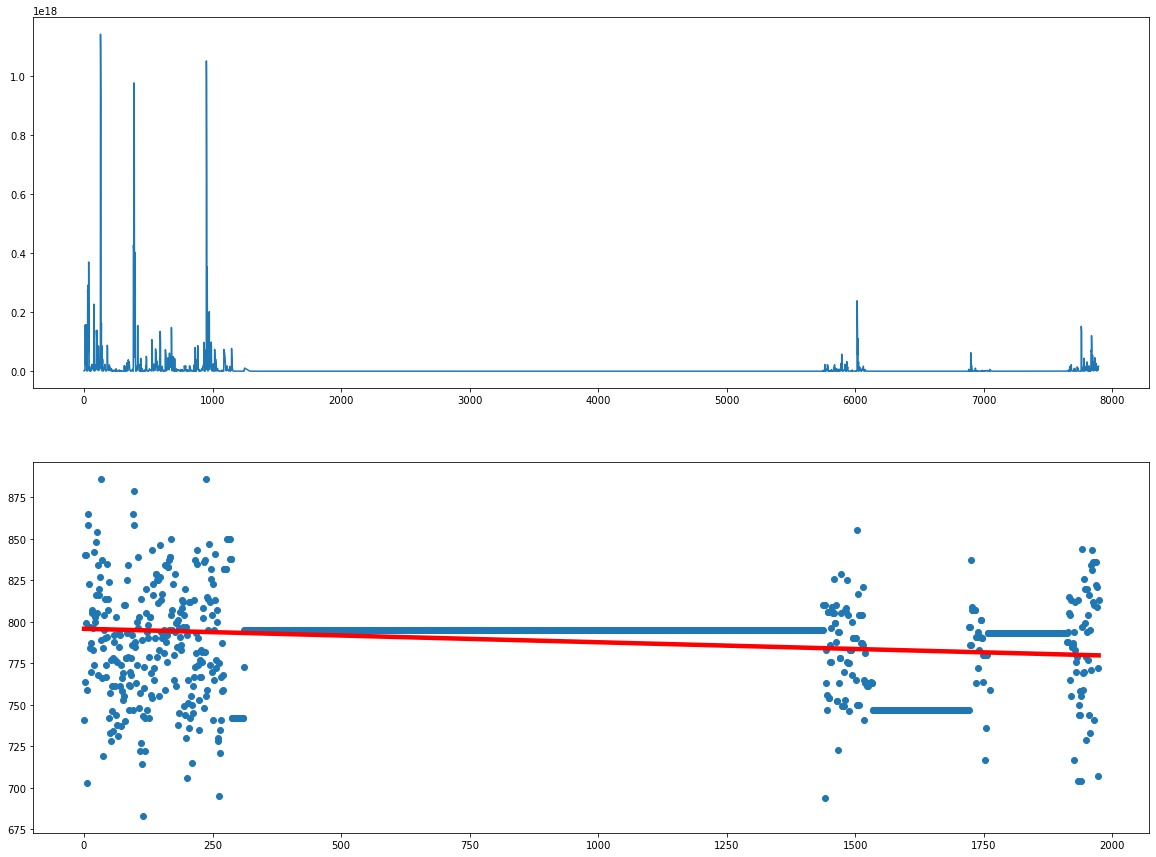

1
Epoch 1975: Current Learning Rate: [0.0004104270601677619, 0.006402662138617096, 0.0003283416481342111], Current Success Rate: 813


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2000  is done!


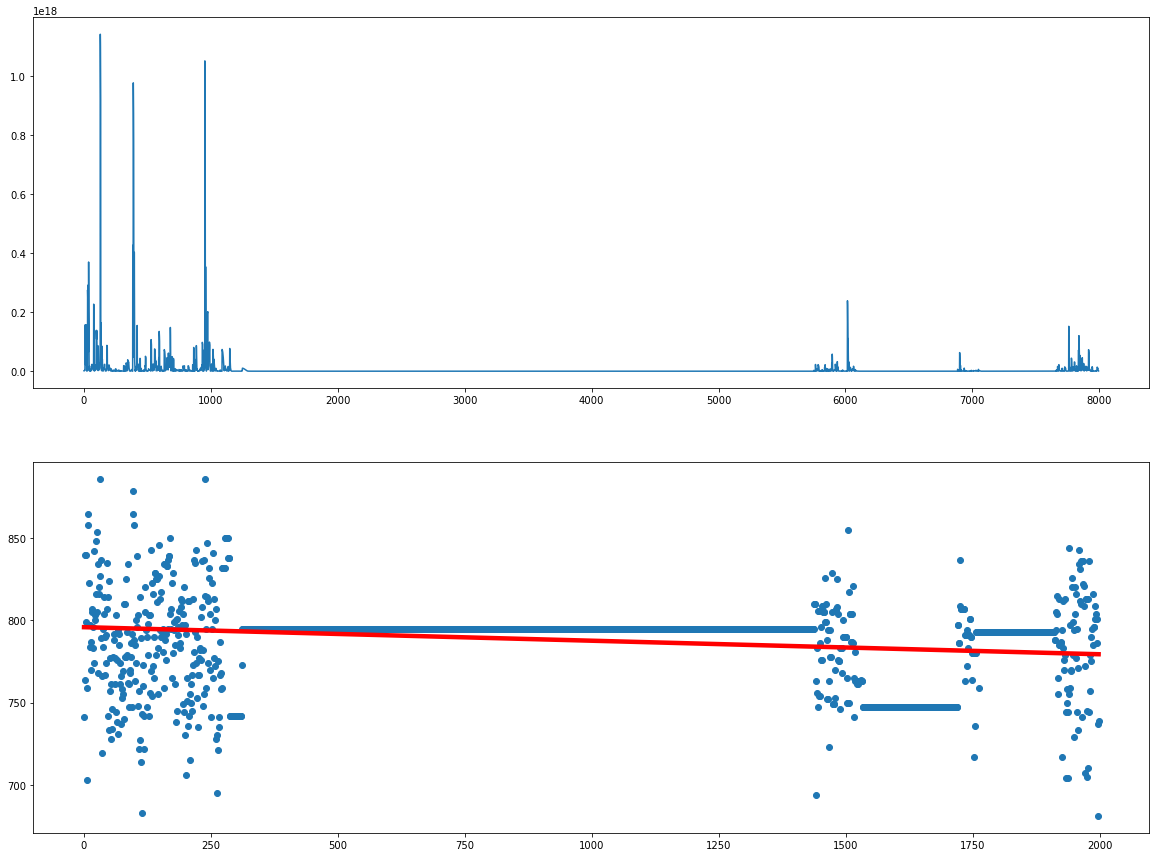

1
Epoch 2000: Current Learning Rate: [0.00040940222285505977, 0.006386674676538943, 0.0003275217782840495], Current Success Rate: 739


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75583/983755289.py:66: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [93]:
# Initialize your environment and the PPO agent
env = sim_constrained.Env(visualise=False, verbose=False, model=True,goal="min_time", graph = True)
node_feature_dim = env.node_feature_dim
gnn_output_dim = 256 # Proposed gnn output 

print(node_feature_dim)



n_states = env.n_states

n_actions = env.n_actions

ppo_agent = PPO(node_feature_dim, gnn_output_dim, n_actions, lr_actor=5e-4, lr_critic=78e-4, lr_graph=4e-4, gamma=0.97, K_epochs=4, eps_clip=0.18, gae_lambda=0.97)
memory = Memory()

initial_temperature = 2  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.002          # Rate of temperature decay
current_temperature = initial_temperature

# Training loop
num_episodes = 2000
success_rates = []
losses = []
success_rate = 0

for episode in range(num_episodes):
    if not (episode + 1) % 25:
        print("episode ", episode+1, " is done!")
        show(losses, success_rates)
        print(current_temperature)
        # Optional: print the current learning rate
        current_lr = ppo_agent.scheduler.get_last_lr()  # get_last_lr returns a list for each param group
        print(f"Epoch {episode+1}: Current Learning Rate: {current_lr}, Current Success Rate: {success_rate}")
    
    current_temperature = max(final_temperature, initial_temperature * (1 - decay_rate * episode))


    _, state_data, action_mask = env.reset()


    #print(current_temperature)
        
    done = False

    while not done:
        action = ppo_agent.select_action(state_data, memory, action_mask)
        #print(action)
        state_data, reward, done, action_mask, success_rate = env.step(action)
        
        #print(state_data, reward, done, success_rate )
        
        if done:
            #reward += math.exp(success_rate / 10 )
            reward -= 5 * math.exp(success_rate/100)

        # Save in memory
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        state_temp = ppo_agent.gnn_processor(state_data)
        with torch.no_grad():
            _, state_value = ppo_agent.policy_old(torch.FloatTensor(state_temp).unsqueeze(0), action_mask)
            memory.values.append(state_value)
        
        
        
    
    success_rates.append(success_rate)
    #print(success_rate)
    
    # Update PPO agent
    losses += ppo_agent.update(memory)
    
    ppo_agent.scheduler.step()
    
    memory.clear_memory()

    # Log results, etc.


In [ ]:
test_env = sim_constrained.Env(visualise=True, verbose=False, model=True, test=True, goal="min_time",graph = True)
_, state_data, action_mask = env.reset()

done = False

while not done:
    action = ppo_agent.select_action(state_data, memory, action_mask)
    #print(action)
    state_data, reward, done, action_mask, success_rate = test_env.step(action)
    #print(state, reward, done, action_mask, success_rate )


In [42]:
#torch.save(ppo_agent, '/Users/hazarckr/Documents/Semester_3/idp/schedulingGNN/trainedModel2.pth')

Freezed Values:
    
self.actor = nn.Sequential(
            nn.Linear(n_states, 512),
            
            nn.PReLU(),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
    
    
ppo_agent = PPO(n_states, n_actions, lr_actor=0.00007, lr_critic=0.003, gamma=0.98, K_epochs=10, eps_clip=0.08, gae_lambda=0.97)
memory = Memory()

initial_temperature = 3  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.001          # Rate of temperature decay
current_temperature = initial_temperature